### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import math

In [3]:
import pandas as pd
import numpy as np

In [4]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

In [5]:
pd.__version__

'0.23.4'

In [6]:
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit

In [7]:
from category_encoders import TargetEncoder

In [8]:
import sys
sys.path.append('../src')

In [9]:
from workflow.data_utils import load_csv

In [10]:
from workflow.log_utils import get_logger

In [11]:
# from workflow.structured import add_datepart, train_cats, proc_df, apply_cats

In [12]:
from fastai.structured import add_datepart, train_cats, proc_df, apply_cats

In [13]:
import lightgbm as lgb

### Constants

In [14]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [15]:
def half_bool_columns_to_float_type(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            unqs = df[col].unique()
            if len(unqs) == 2 and (False in unqs or True in unqs):
                print(col)
                df[col] = df[col].astype(float)

In [16]:
def check_columns_and_types_same_in(a,b):
    same_names = all(a.columns == b.columns)
    same_types = [a[col].dtype == b[col].dtype for col in a.columns]
    return same_names, all(same_types)

In [17]:
# some duplicated info
drop_columns = ['date', 'sessionId', 'visitId']
LN_SPLITTER ='\n====\n'

In [18]:
logger = get_logger('new')

### Loads 

In [19]:
%%time
full_train = load_csv('../data/processed_data/processed_train.csv',
                      low_memory=False, nrows=None)

CPU times: user 5.01 s, sys: 913 ms, total: 5.92 s
Wall time: 7.03 s


In [20]:
full_train.drop(columns=drop_columns, inplace=True)

In [21]:
half_bool_columns_to_float_type(full_train)

trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [22]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 32 columns):
channelGrouping                                 903653 non-null object
fullVisitorId                                   903653 non-null object
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device_browser                                  903653 non-null object
device_deviceCategory                           903653 non-null object
device_isMobile                                 903653 non-null bool
device_operatingSystem                          903653 non-null object
geoNetwork_city                                 903653 non-null object
geoNetwork_continent                            903653 non-null object
geoNetwork_country                              903653 non-null object
geoNetwork_metro                                903653 non-null object
geoNetwork_networkDomain                 

In [23]:
display_all(full_train.head())

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,totals_transactionRevenue
0,Organic Search,1131660440785968503,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
1,Organic Search,377306020877927890,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
2,Organic Search,3895546263509774583,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
3,Organic Search,4763447161404445595,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google,NaN
4,Organic Search,27294437909732085,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN


In [24]:
%%time
test_df = load_csv('../data/processed_data/processed_test.csv', low_memory=False, nrows=None)

CPU times: user 4.75 s, sys: 745 ms, total: 5.5 s
Wall time: 6.48 s


In [25]:
test_df.drop(columns=drop_columns, inplace=True)

In [26]:
half_bool_columns_to_float_type(test_df)

trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 31 columns):
channelGrouping                                 804684 non-null object
fullVisitorId                                   804684 non-null object
visitNumber                                     804684 non-null int64
visitStartTime                                  804684 non-null int64
device_browser                                  804684 non-null object
device_deviceCategory                           804684 non-null object
device_isMobile                                 804684 non-null bool
device_operatingSystem                          804684 non-null object
geoNetwork_city                                 804684 non-null object
geoNetwork_continent                            804684 non-null object
geoNetwork_country                              804684 non-null object
geoNetwork_metro                                804684 non-null object
geoNetwork_networkDomain                 

#### Check column names and types are == for train and test

In [27]:
check_columns_and_types_same_in(full_train.drop('totals_transactionRevenue', axis=1), test_df)

(True, True)

In [23]:
display_all(full_train.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
channelGrouping,903653,8,Organic Search,381561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fullVisitorId,903653,714167,1957458976293878100,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitNumber,903653,NaN,NaN,NaN,2.2649,9.28373,1,1,1,1,395
visitStartTime,903653,NaN,NaN,NaN,1.48501e+09,9.02212e+06,1.47003e+09,1.47756e+09,1.48395e+09,1.49276e+09,1.50166e+09
device_browser,903653,54,Chrome,620364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_deviceCategory,903653,3,desktop,664479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_isMobile,903653,2,False,664530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_operatingSystem,903653,20,Windows,350072,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geoNetwork_city,903653,649,not available in demo dataset,508229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geoNetwork_continent,903653,6,Americas,450377,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Workflow

In [28]:
full_train['totals_transactionRevenue'] = full_train['totals_transactionRevenue'].fillna(value=0)

In [29]:
# posix seconds to datetime
full_train['visitStartTime'] = pd.to_datetime(full_train.visitStartTime, unit='s')

In [30]:
test_df['visitStartTime'] = pd.to_datetime(test_df.visitStartTime, unit='s')

#### Take fullVisitorId -> validation ids, if it has transaction after 2017-04-30 

In [28]:
validationIds = full_train[full_train.visitStartTime > '2017-04-30'].fullVisitorId.unique()

In [29]:
validationIds.shape

(161118,)

In [30]:
# save for later use
np.save('../data/tmp/validIds.npy',validationIds)

#### Continue workflow: make time feature columns

In [31]:
# make time features
add_datepart(full_train, 'visitStartTime', time=True, drop=False)

In [32]:
# make time features
add_datepart(test_df, 'visitStartTime', time=True, drop=False)

In [33]:
set(full_train.drop('totals_transactionRevenue', axis=1).columns) - set(test_df.columns)

set()

#### Drop fullVisitorId columns to not categorize them

In [34]:
train_visitorIds = full_train.fullVisitorId
test_visitorIds = test_df.fullVisitorId

In [35]:
full_train.drop(columns=['fullVisitorId'], inplace=True)
test_df.drop(columns=['fullVisitorId'], inplace=True)

In [36]:
# make categorical data
train_cats(full_train)

In [37]:
apply_cats(test_df, full_train)

In [43]:
display_all(full_train.isnull().sum().sort_index()/len(full_train))

channelGrouping                                 0.000000
device_browser                                  0.000000
device_deviceCategory                           0.000000
device_isMobile                                 0.000000
device_operatingSystem                          0.000000
geoNetwork_city                                 0.000000
geoNetwork_continent                            0.000000
geoNetwork_country                              0.000000
geoNetwork_metro                                0.000000
geoNetwork_networkDomain                        0.000000
geoNetwork_region                               0.000000
geoNetwork_subContinent                         0.000000
totals_bounces                                  0.501324
totals_hits                                     0.000000
totals_newVisits                                0.221980
totals_pageviews                                0.000111
totals_transactionRevenue                       0.000000
trafficSource_adContent        

In [44]:
display_all(test_df.isnull().sum().sort_index()/len(test_df))

channelGrouping                                 0.000000
device_browser                                  0.019764
device_deviceCategory                           0.000000
device_isMobile                                 0.000000
device_operatingSystem                          0.001150
geoNetwork_city                                 0.009569
geoNetwork_continent                            0.000000
geoNetwork_country                              0.000034
geoNetwork_metro                                0.001099
geoNetwork_networkDomain                        0.031993
geoNetwork_region                               0.007047
geoNetwork_subContinent                         0.000000
totals_bounces                                  0.476878
totals_hits                                     0.000000
totals_newVisits                                0.248935
totals_pageviews                                0.000173
trafficSource_adContent                         0.994974
trafficSource_adwordsClickInfo.

In [38]:
# add back fullVisitosIds
full_train['fullVisitorId'] = train_visitorIds
test_df['fullVisitorId'] = test_visitorIds

In [39]:
# sort train dataframe by time
full_train.sort_values(by='visitStartTime', inplace=True)

In [40]:
full_train.reset_index(drop=True, inplace=True)

In [41]:
full_train.head()

,channelGrouping,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,...,visitStartTimeIs_month_start,visitStartTimeIs_quarter_end,visitStartTimeIs_quarter_start,visitStartTimeIs_year_end,visitStartTimeIs_year_start,visitStartTimeHour,visitStartTimeMinute,visitStartTimeSecond,visitStartTimeElapsed,fullVisitorId
0,Direct,3,2016-08-01 07:00:12,Safari,mobile,True,iOS,not available in demo dataset,Americas,United States,...,True,False,False,False,False,7,0,12,1470034812,0423043652415339154
1,Social,1,2016-08-01 07:04:26,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Thailand,...,True,False,False,False,False,7,4,26,1470035066,8294721032567046680
2,Organic Search,1,2016-08-01 07:04:41,Amazon Silk,tablet,True,Android,not available in demo dataset,Americas,United States,...,True,False,False,False,False,7,4,41,1470035081,7718623669497357235
3,Organic Search,1,2016-08-01 07:06:01,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Canada,...,True,False,False,False,False,7,6,1,1470035161,4798058133221713505
4,Direct,1,2016-08-01 07:06:10,Chrome,desktop,False,Windows,Quezon City,Asia,Philippines,...,True,False,False,False,False,7,6,10,1470035170,5076747981380011349


In [42]:
check_columns_and_types_same_in(full_train.drop(columns=['totals_transactionRevenue']), test_df)

(True, True)

In [43]:
%%time
os.makedirs('../data/tmp', exist_ok=True)
full_train.to_feather('../data/tmp/raw_train')

CPU times: user 204 ms, sys: 121 ms, total: 325 ms
Wall time: 2.71 s


In [44]:
%%time
os.makedirs('../data/tmp', exist_ok=True)
test_df.to_feather('../data/tmp/raw_test')

CPU times: user 187 ms, sys: 96.8 ms, total: 284 ms
Wall time: 1.94 s


#### Preprocess

In [19]:
%time full_train = pd.read_feather('../data/tmp/raw_train', nthreads=-1)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 271 ms, sys: 125 ms, total: 397 ms
Wall time: 618 ms


In [20]:
%time test_df = pd.read_feather('../data/tmp/raw_test', nthreads=-1)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 242 ms, sys: 110 ms, total: 352 ms
Wall time: 438 ms


#####  TimeSeries Split way to make Validation dataset

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

In [53]:
# sanity check
for i, (tr_index, val_index) in enumerate(tscv.split(full_train.visitStartTime)):
    logger.debug(f'Working with fold {i}\n===========\n')
    print(f'Train max time: {full_train.iloc[tr_index].visitStartTime.max()}, Valid max time: {full_train.iloc[val_index].visitStartTime.min()}')
    print(f'train_set length: {len(tr_index)}, valid_set length: {len(val_index)}')

2018-10-05 13:16:48,720 - new - DEBUG - Working with fold 0

Train max time: 2016-10-03 21:24:49, Valid max time: 2016-10-03 21:25:22
train_set length: 150613, valid_set length: 150608
2018-10-05 13:16:48,768 - new - DEBUG - Working with fold 1

Train max time: 2016-11-16 16:56:29, Valid max time: 2016-11-16 16:56:35
train_set length: 301221, valid_set length: 150608
2018-10-05 13:16:48,840 - new - DEBUG - Working with fold 2

Train max time: 2017-01-09 08:03:25, Valid max time: 2017-01-09 08:03:30
train_set length: 451829, valid_set length: 150608
2018-10-05 13:16:48,937 - new - DEBUG - Working with fold 3

Train max time: 2017-03-19 05:10:52, Valid max time: 2017-03-19 05:13:08
train_set length: 602437, valid_set length: 150608
2018-10-05 13:16:49,060 - new - DEBUG - Working with fold 4

Train max time: 2017-05-25 16:53:03, Valid max time: 2017-05-25 16:53:20
train_set length: 753045, valid_set length: 150608


##### Working on validation pipeline for feature selection

In [62]:
trn_sample_sz = 100000
# trn_sample_sz = len(full_train)

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

In [63]:
train_smpl_data = full_train.iloc[:trn_sample_sz].copy()

In [66]:
tmp = train_smpl_data.visitStartTime

In [67]:
train_smpl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
channelGrouping                                 100000 non-null category
visitNumber                                     100000 non-null int64
visitStartTime                                  100000 non-null datetime64[ns]
device_browser                                  100000 non-null category
device_deviceCategory                           100000 non-null category
device_isMobile                                 100000 non-null bool
device_operatingSystem                          100000 non-null category
geoNetwork_city                                 100000 non-null category
geoNetwork_continent                            100000 non-null category
geoNetwork_country                              100000 non-null category
geoNetwork_metro                                100000 non-null category
geoNetwork_networkDomain                        100000 non-null category
geoNetwork_regi

In [68]:
train_smpl_data.drop(columns=[c for c in train_smpl_data.columns 
                              if c.startswith('visitStartTime')], inplace=True)

In [69]:
train_smpl_data['visitStartTime'] = tmp

In [70]:
all_features = train_smpl_data.drop(columns=[
    'visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']).columns

In [71]:
stats_cols = ['col_name', 'val_mean_rmse', 'val_var_rmse', 'rmse_delta']

In [72]:
lgb_params = {'learning_rate':0.1}

In [73]:
%%time
# conduct 20 experiments to find columns that reduce rmse better
for j in range(20):
    logger.debug(f'Experiment #: {j}{LN_SPLITTER}')
    # cancel the dict
    stats_dict = {name:[] for name in stats_cols}
    # cancel columns to use
    columns_to_use = ['visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']
    # cancel best rmse
    best_rmse = None
    
    # permutate features 
    feature_ids = np.random.permutation(range(len(all_features)))

    for idx in feature_ids:
        # randomly pick feature
        feature_name = all_features[idx]

        logger.debug(f'Adding feature name: {feature_name}{LN_SPLITTER}')
        # append feature name
        columns_to_use.append(feature_name)

        # create sample to train and validate model on
        full_train_smpl = train_smpl_data[columns_to_use].copy()

        # test_preds = np.zeros(len(test_smpl))

        # create array to collect metrics for every new data sample
        metrics = np.zeros((N_SPLITS, 2))

        stats_dict['col_name'].append(feature_name)

        for i, (tr_index, val_index) in enumerate(tscv.split(full_train_smpl.visitStartTime)):

            logger.debug(f'Process train split on fold {i}{LN_SPLITTER}')
            X_train, y_train, nas = proc_df(full_train_smpl.iloc[tr_index], 'totals_transactionRevenue',
                                            skip_flds=['fullVisitorId', 'visitStartTime'], max_n_cat=None)

            logger.debug(f'Process valid split on fold {i}{LN_SPLITTER}')
            X_valid, y_valid, _ = proc_df(full_train_smpl.iloc[val_index], 'totals_transactionRevenue',
                                          skip_flds=['fullVisitorId', 'visitStartTime'],
                                          max_n_cat=None, na_dict=nas)
            if i == 0:
                logger.debug(f'Number of featues: {len(X_train.columns)}{LN_SPLITTER}')

            print('Sanity check for column names and types for train and valid')
            print(f'{check_columns_and_types_same_in(X_train, X_valid)}')


            # log(y) for training the model IMPORTANT!!!
            y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

            # train model
            m = lgb.LGBMRegressor(n_estimators=10000, **lgb_params)
            if i == 0:
                print(m)

            m.fit(X_train, y_train, eval_metric='rmse',
                  early_stopping_rounds=200,
                  eval_set=[(X_valid, y_valid),
                            (X_train, y_train)],
                  eval_names=['valid', 'train'], verbose=100)

            # Record the best iteration
            best_iteration = m.best_iteration_

            metrics[i] = [m.best_score_['train']
                          ['rmse'], m.best_score_['valid']['rmse']]


        if best_rmse is None:
            best_rmse = metrics[:,1].mean()

        delta = best_rmse - metrics[:,1].mean()
        if delta > 0:
            best_rmse = metrics[:,1].mean()

        stats_dict['rmse_delta'].append(delta)
        stats_dict['val_mean_rmse'].append(metrics[:,1].mean())
        stats_dict['val_var_rmse'].append(metrics[:,1].var())


    stats_df = pd.DataFrame(stats_dict)
    
    if j == 0:
        # it's ONLY for the first time
        os.makedirs('../log', exist_ok=True)
        stats_df.to_csv('../log/lgb_feature_selection.csv', index=False, header=True)

    else:
        # this for the rest of experiments
        with open('../log/lgb_feature_selection.csv', mode='a') as fin:
            stats_df.to_csv(fin, index=False, header=False)

2018-10-12 13:52:45,247 - new - DEBUG - Experiment #: 0
====

2018-10-12 13:52:45,248 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.page
====

2018-10-12 13:52:45,256 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:52:45,266 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:52:45,276 - new - DEBUG - Number of featues: 2
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.65198	train's rmse: 1.62849	valid's l2: 

[200]	train's l2: 2.60412	train's rmse: 1.61373	valid's l2: 5.17178	valid's rmse: 2.27415
Early stopping, best iteration is:
[55]	train's l2: 2.61081	train's rmse: 1.6158	valid's l2: 5.16758	valid's rmse: 2.27323
2018-10-12 13:52:48,442 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:52:48,456 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.85909	train's rmse: 1.96446	valid's l2: 5.39909	valid's rmse: 2.32359
[200]	train's l2: 3.85766	train's rmse: 1.96409	valid's l2: 5.40143	valid's rmse: 2.3241
Early stopping, best iteration is:
[61]	train's l2: 3.86004	train's rmse: 1.9647	valid's l2: 5.39836	valid's rmse: 2.32344
2018-10-12 13:52:48,850 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:52:48,866 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for t

[200]	train's l2: 4.06567	train's rmse: 2.01635	valid's l2: 5.6043	valid's rmse: 2.36734
Early stopping, best iteration is:
[52]	train's l2: 4.14542	train's rmse: 2.03603	valid's l2: 5.57357	valid's rmse: 2.36084
2018-10-12 13:52:54,733 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:52:54,756 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.42433	train's rmse: 2.10341	valid's l2: 3.66271	valid's rmse: 1.91382
[200]	train's l2: 4.38598	train's rmse: 2.09427	valid's l2: 3.68295	valid's rmse: 1.9191
Early stopping, best iteration is:
[33]	train's l2: 4.49966	train's rmse: 2.12124	valid's l2: 3.63864	valid's rmse: 1.90752
2018-10-12 13:52:55,307 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:52:55,333 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for 

[200]	train's l2: 4.20934	train's rmse: 2.05167	valid's l2: 3.73545	valid's rmse: 1.93273
Early stopping, best iteration is:
[28]	train's l2: 4.32613	train's rmse: 2.07994	valid's l2: 3.72048	valid's rmse: 1.92885
2018-10-12 13:53:00,947 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.gclId
====

2018-10-12 13:53:00,955 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:53:00,975 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:53:00,995 - new - DEBUG - Number of featues: 9
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_

[200]	train's l2: 1.24152	train's rmse: 1.11424	valid's l2: 4.65507	valid's rmse: 2.15756
Early stopping, best iteration is:
[27]	train's l2: 1.78905	train's rmse: 1.33755	valid's l2: 4.33607	valid's rmse: 2.08232
2018-10-12 13:53:06,606 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:53:06,634 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.26555	train's rmse: 1.50517	valid's l2: 4.50035	valid's rmse: 2.1214
[200]	train's l2: 2.07094	train's rmse: 1.43908	valid's l2: 4.67051	valid's rmse: 2.16114
Early stopping, best iteration is:
[35]	train's l2: 2.55408	train's rmse: 1.59815	valid's l2: 4.30516	valid's rmse: 2.07489
2018-10-12 13:53:07,064 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:53:07,095 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for

[200]	train's l2: 2.16373	train's rmse: 1.47096	valid's l2: 3.90701	valid's rmse: 1.97662
Early stopping, best iteration is:
[61]	train's l2: 2.55581	train's rmse: 1.59869	valid's l2: 3.82161	valid's rmse: 1.95489
2018-10-12 13:53:13,513 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:53:13,553 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.58366	train's rmse: 1.60738	valid's l2: 2.98156	valid's rmse: 1.72672
[200]	train's l2: 2.3291	train's rmse: 1.52614	valid's l2: 3.02079	valid's rmse: 1.73804
Early stopping, best iteration is:
[21]	train's l2: 3.14858	train's rmse: 1.77443	valid's l2: 2.93556	valid's rmse: 1.71335
2018-10-12 13:53:14,223 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:53:14,268 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for

[200]	train's l2: 2.34187	train's rmse: 1.53032	valid's l2: 3.14832	valid's rmse: 1.77435
Early stopping, best iteration is:
[27]	train's l2: 2.99466	train's rmse: 1.73051	valid's l2: 2.88821	valid's rmse: 1.69947
2018-10-12 13:53:21,341 - new - DEBUG - Adding feature name: trafficSource_adContent
====

2018-10-12 13:53:21,351 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:53:21,386 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:53:21,420 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, 

[200]	train's l2: 0.958078	train's rmse: 0.978815	valid's l2: 4.48524	valid's rmse: 2.11784
Early stopping, best iteration is:
[30]	train's l2: 1.52953	train's rmse: 1.23674	valid's l2: 4.1911	valid's rmse: 2.04722
2018-10-12 13:53:28,983 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:53:29,027 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.92508	train's rmse: 1.38747	valid's l2: 4.14536	valid's rmse: 2.03601
[200]	train's l2: 1.69515	train's rmse: 1.30198	valid's l2: 4.32006	valid's rmse: 2.07848
Early stopping, best iteration is:
[33]	train's l2: 2.31202	train's rmse: 1.52053	valid's l2: 4.04579	valid's rmse: 2.01142
2018-10-12 13:53:29,600 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:53:29,649 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types f

[200]	train's l2: 2.08574	train's rmse: 1.44421	valid's l2: 3.88129	valid's rmse: 1.9701
Early stopping, best iteration is:
[72]	train's l2: 2.44579	train's rmse: 1.5639	valid's l2: 3.81645	valid's rmse: 1.95357
2018-10-12 13:53:38,500 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:53:38,566 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.52767	train's rmse: 1.58986	valid's l2: 2.93163	valid's rmse: 1.7122
[200]	train's l2: 2.2692	train's rmse: 1.50639	valid's l2: 2.97114	valid's rmse: 1.7237
Early stopping, best iteration is:
[37]	train's l2: 2.84618	train's rmse: 1.68706	valid's l2: 2.91513	valid's rmse: 1.70738
2018-10-12 13:53:39,516 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:53:39,587 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for tra

[100]	train's l2: 2.4489	train's rmse: 1.5649	valid's l2: 3.02602	valid's rmse: 1.73955
[200]	train's l2: 2.21944	train's rmse: 1.48978	valid's l2: 3.13336	valid's rmse: 1.77013
Early stopping, best iteration is:
[25]	train's l2: 2.96635	train's rmse: 1.72231	valid's l2: 2.89598	valid's rmse: 1.70176
2018-10-12 13:53:49,026 - new - DEBUG - Adding feature name: device_browser
====

2018-10-12 13:53:49,038 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:53:49,083 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:53:49,128 - new - DEBUG - Number of featues: 27
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0

[100]	train's l2: 1.06585	train's rmse: 1.0324	valid's l2: 4.37084	valid's rmse: 2.09066
[200]	train's l2: 0.824622	train's rmse: 0.908087	valid's l2: 4.52723	valid's rmse: 2.12773
Early stopping, best iteration is:
[33]	train's l2: 1.42678	train's rmse: 1.19448	valid's l2: 4.2086	valid's rmse: 2.05149
2018-10-12 13:53:58,626 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:53:58,682 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.80286	train's rmse: 1.3427	valid's l2: 4.1356	valid's rmse: 2.03362
[200]	train's l2: 1.53938	train's rmse: 1.24072	valid's l2: 4.28002	valid's rmse: 2.06882
Early stopping, best iteration is:
[35]	train's l2: 2.21935	train's rmse: 1.48975	valid's l2: 4.01633	valid's rmse: 2.00408
2018-10-12 13:53:59,451 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:53:59,518 - new 

[100]	train's l2: 2.24398	train's rmse: 1.49799	valid's l2: 3.80938	valid's rmse: 1.95176
[200]	train's l2: 1.93957	train's rmse: 1.39268	valid's l2: 3.853	valid's rmse: 1.96291
Early stopping, best iteration is:
[79]	train's l2: 2.34342	train's rmse: 1.53082	valid's l2: 3.79764	valid's rmse: 1.94875
2018-10-12 13:54:09,523 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:54:09,602 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.4327	train's rmse: 1.55971	valid's l2: 2.90793	valid's rmse: 1.70526
[200]	train's l2: 2.14318	train's rmse: 1.46396	valid's l2: 2.94798	valid's rmse: 1.71697
Early stopping, best iteration is:
[38]	train's l2: 2.80987	train's rmse: 1.67627	valid's l2: 2.88602	valid's rmse: 1.69883
2018-10-12 13:54:10,500 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:54:10,587 - new -

[100]	train's l2: 2.40061	train's rmse: 1.54939	valid's l2: 2.95851	valid's rmse: 1.72003
[200]	train's l2: 2.12369	train's rmse: 1.45729	valid's l2: 3.03297	valid's rmse: 1.74154
Early stopping, best iteration is:
[29]	train's l2: 2.88639	train's rmse: 1.69894	valid's l2: 2.87121	valid's rmse: 1.69446
2018-10-12 13:54:20,648 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.slot
====

2018-10-12 13:54:20,661 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:54:20,717 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:54:20,772 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_st

[4000]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26875	valid's rmse: 2.29538
[4100]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26875	valid's rmse: 2.29538
[4200]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26875	valid's rmse: 2.29538
[4300]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26875	valid's rmse: 2.29538
[4400]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26875	valid's rmse: 2.29538
[4500]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26875	valid's rmse: 2.29537
[4600]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26875	valid's rmse: 2.29537
[4700]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26874	valid's rmse: 2.29537
[4800]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26874	valid's rmse: 2.29537
[4900]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26874	valid's rmse: 2.29537
[5000]	train's l2: 2.63614	train's rmse: 1.62362	valid's l2: 5.26874	valid's rmse: 2.29537

[2700]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57079	valid's rmse: 2.36025
[2800]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57079	valid's rmse: 2.36025
[2900]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57079	valid's rmse: 2.36025
[3000]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57079	valid's rmse: 2.36025
[3100]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57079	valid's rmse: 2.36025
[3200]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57079	valid's rmse: 2.36025
[3300]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57078	valid's rmse: 2.36025
[3400]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57078	valid's rmse: 2.36025
[3500]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57078	valid's rmse: 2.36025
[3600]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57078	valid's rmse: 2.36025
[3700]	train's l2: 3.94398	train's rmse: 1.98595	valid's l2: 5.57078	valid's rmse: 2.36025

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.62934	train's rmse: 2.15159	valid's l2: 3.89124	valid's rmse: 1.97262
[200]	train's l2: 4.62934	train's rmse: 2.15159	valid's l2: 3.89124	valid's rmse: 1.97262
Early stopping, best iteration is:
[16]	train's l2: 4.63058	train's rmse: 2.15188	valid's l2: 3.8901	valid's rmse: 1.97233
2018-10-12 13:54:39,392 - new - DEBUG - Adding feature name: geoNetwork_subContinent
====

2018-10-12 13:54:39,399 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:54:39,410 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:54:39,420 - new - DEBUG - Number of featues: 2
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_chi

[100]	train's l2: 2.59983	train's rmse: 1.6124	valid's l2: 5.18554	valid's rmse: 2.27718
[200]	train's l2: 2.59923	train's rmse: 1.61221	valid's l2: 5.18563	valid's rmse: 2.2772
[300]	train's l2: 2.59903	train's rmse: 1.61215	valid's l2: 5.18609	valid's rmse: 2.2773
Early stopping, best iteration is:
[133]	train's l2: 2.59955	train's rmse: 1.61231	valid's l2: 5.18547	valid's rmse: 2.27716
2018-10-12 13:54:44,372 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:54:44,387 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.87551	train's rmse: 1.96863	valid's l2: 5.48278	valid's rmse: 2.34153
[200]	train's l2: 3.87533	train's rmse: 1.96859	valid's l2: 5.48316	valid's rmse: 2.34162
Early stopping, best iteration is:
[53]	train's l2: 3.87599	train's rmse: 1.96875	valid's l2: 5.48181	valid's rmse: 2.34133
2018-10-12 13:54

[100]	train's l2: 4.33217	train's rmse: 2.08139	valid's l2: 5.65937	valid's rmse: 2.37894
[200]	train's l2: 4.32656	train's rmse: 2.08004	valid's l2: 5.66871	valid's rmse: 2.38091
Early stopping, best iteration is:
[64]	train's l2: 4.33544	train's rmse: 2.08217	valid's l2: 5.65651	valid's rmse: 2.37834
2018-10-12 13:54:50,231 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:54:50,254 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.65665	train's rmse: 2.15793	valid's l2: 3.72141	valid's rmse: 1.92909
[200]	train's l2: 4.65131	train's rmse: 2.15669	valid's l2: 3.7255	valid's rmse: 1.93016
Early stopping, best iteration is:
[25]	train's l2: 4.66746	train's rmse: 2.16043	valid's l2: 3.7154	valid's rmse: 1.92754
2018-10-12 13:54:50,807 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:54:50,833 - new 

[100]	train's l2: 4.39318	train's rmse: 2.09599	valid's l2: 3.73676	valid's rmse: 1.93307
[200]	train's l2: 4.38502	train's rmse: 2.09404	valid's l2: 3.74099	valid's rmse: 1.93417
Early stopping, best iteration is:
[39]	train's l2: 4.40751	train's rmse: 2.09941	valid's l2: 3.731	valid's rmse: 1.93158
2018-10-12 13:54:57,014 - new - DEBUG - Adding feature name: trafficSource_adContent
====

2018-10-12 13:54:57,023 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:54:57,045 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:54:57,067 - new - DEBUG - Number of featues: 10
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_

[100]	train's l2: 2.31661	train's rmse: 1.52204	valid's l2: 5.16534	valid's rmse: 2.27274
[200]	train's l2: 2.26852	train's rmse: 1.50616	valid's l2: 5.18758	valid's rmse: 2.27762
Early stopping, best iteration is:
[30]	train's l2: 2.41347	train's rmse: 1.55354	valid's l2: 5.1402	valid's rmse: 2.2672
2018-10-12 13:55:02,864 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:55:02,891 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.55723	train's rmse: 1.88606	valid's l2: 5.426	valid's rmse: 2.32938
[200]	train's l2: 3.4984	train's rmse: 1.8704	valid's l2: 5.45017	valid's rmse: 2.33456
Early stopping, best iteration is:
[41]	train's l2: 3.62456	train's rmse: 1.90383	valid's l2: 5.40055	valid's rmse: 2.32391
2018-10-12 13:55:03,318 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:55:03,349 - new - DE

[100]	train's l2: 2.73484	train's rmse: 1.65374	valid's l2: 4.4121	valid's rmse: 2.1005
[200]	train's l2: 2.51362	train's rmse: 1.58544	valid's l2: 4.47167	valid's rmse: 2.11463
Early stopping, best iteration is:
[43]	train's l2: 2.96322	train's rmse: 1.7214	valid's l2: 4.36621	valid's rmse: 2.08955
2018-10-12 13:55:10,039 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:55:10,086 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.96983	train's rmse: 1.72332	valid's l2: 3.16402	valid's rmse: 1.77877
[200]	train's l2: 2.7623	train's rmse: 1.66202	valid's l2: 3.20716	valid's rmse: 1.79085
Early stopping, best iteration is:
[24]	train's l2: 3.37912	train's rmse: 1.83824	valid's l2: 3.07715	valid's rmse: 1.75418
2018-10-12 13:55:10,760 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:55:10,807 - new - 

[100]	train's l2: 2.96819	train's rmse: 1.72284	valid's l2: 3.0462	valid's rmse: 1.74534
[200]	train's l2: 2.78922	train's rmse: 1.6701	valid's l2: 3.06505	valid's rmse: 1.75073
Early stopping, best iteration is:
[37]	train's l2: 3.17526	train's rmse: 1.78192	valid's l2: 3.03315	valid's rmse: 1.74159
2018-10-12 13:55:18,378 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.slot
====

2018-10-12 13:55:18,388 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:55:18,423 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:55:18,459 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_stat

[100]	train's l2: 1.16536	train's rmse: 1.07952	valid's l2: 4.32422	valid's rmse: 2.07948
[200]	train's l2: 0.962894	train's rmse: 0.981272	valid's l2: 4.44056	valid's rmse: 2.10726
Early stopping, best iteration is:
[33]	train's l2: 1.49138	train's rmse: 1.22122	valid's l2: 4.18056	valid's rmse: 2.04464
2018-10-12 13:55:26,171 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:55:26,215 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.94849	train's rmse: 1.39588	valid's l2: 4.24175	valid's rmse: 2.05955
[200]	train's l2: 1.72007	train's rmse: 1.31151	valid's l2: 4.3819	valid's rmse: 2.0933
Early stopping, best iteration is:
[42]	train's l2: 2.21827	train's rmse: 1.48938	valid's l2: 4.12577	valid's rmse: 2.0312
2018-10-12 13:55:26,802 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:55:26,853 - new

[100]	train's l2: 2.39754	train's rmse: 1.5484	valid's l2: 3.7959	valid's rmse: 1.94831
[200]	train's l2: 2.17611	train's rmse: 1.47516	valid's l2: 3.87318	valid's rmse: 1.96804
Early stopping, best iteration is:
[61]	train's l2: 2.5476	train's rmse: 1.59612	valid's l2: 3.7853	valid's rmse: 1.94559
2018-10-12 13:55:35,706 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:55:35,768 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.56086	train's rmse: 1.60027	valid's l2: 2.87696	valid's rmse: 1.69616
[200]	train's l2: 2.29872	train's rmse: 1.51615	valid's l2: 2.90571	valid's rmse: 1.70462
Early stopping, best iteration is:
[42]	train's l2: 2.82841	train's rmse: 1.68179	valid's l2: 2.85684	valid's rmse: 1.69022
2018-10-12 13:55:36,615 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:55:36,684 - new - 

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.49048	train's rmse: 1.57813	valid's l2: 2.94243	valid's rmse: 1.71535
[200]	train's l2: 2.24847	train's rmse: 1.49949	valid's l2: 3.01977	valid's rmse: 1.73775
Early stopping, best iteration is:
[44]	train's l2: 2.76552	train's rmse: 1.66298	valid's l2: 2.8565	valid's rmse: 1.69012
2018-10-12 13:55:46,140 - new - DEBUG - Adding feature name: trafficSource_campaign
====

2018-10-12 13:55:46,153 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:55:46,202 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:55:46,248 - new - DEBUG - Number of featues: 28
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1

[100]	train's l2: 1.10983	train's rmse: 1.05349	valid's l2: 4.30904	valid's rmse: 2.07582
[200]	train's l2: 0.909025	train's rmse: 0.953428	valid's l2: 4.44601	valid's rmse: 2.10856
Early stopping, best iteration is:
[34]	train's l2: 1.44045	train's rmse: 1.20019	valid's l2: 4.159	valid's rmse: 2.03936
2018-10-12 13:55:56,130 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:55:56,190 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.8399	train's rmse: 1.35643	valid's l2: 4.2101	valid's rmse: 2.05185
[200]	train's l2: 1.61375	train's rmse: 1.27034	valid's l2: 4.36544	valid's rmse: 2.08936
Early stopping, best iteration is:
[39]	train's l2: 2.17804	train's rmse: 1.47582	valid's l2: 4.06592	valid's rmse: 2.01641
2018-10-12 13:55:56,855 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:55:56,923 - new 

[100]	train's l2: 2.2928	train's rmse: 1.5142	valid's l2: 3.86048	valid's rmse: 1.96481
[200]	train's l2: 2.03111	train's rmse: 1.42517	valid's l2: 3.91573	valid's rmse: 1.97882
Early stopping, best iteration is:
[55]	train's l2: 2.49758	train's rmse: 1.58037	valid's l2: 3.82787	valid's rmse: 1.95649
2018-10-12 13:56:06,849 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:56:06,928 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.48528	train's rmse: 1.57648	valid's l2: 2.90057	valid's rmse: 1.70311
[200]	train's l2: 2.20074	train's rmse: 1.48349	valid's l2: 2.94465	valid's rmse: 1.716
Early stopping, best iteration is:
[31]	train's l2: 2.91522	train's rmse: 1.7074	valid's l2: 2.88687	valid's rmse: 1.69908
2018-10-12 13:56:07,872 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:56:07,962 - new - D

[100]	train's l2: 2.40061	train's rmse: 1.54939	valid's l2: 2.95937	valid's rmse: 1.72028
[200]	train's l2: 2.12369	train's rmse: 1.45729	valid's l2: 3.03351	valid's rmse: 1.7417
Early stopping, best iteration is:
[29]	train's l2: 2.88639	train's rmse: 1.69894	valid's l2: 2.87201	valid's rmse: 1.6947
2018-10-12 13:56:18,645 - new - DEBUG - Experiment #: 2
====

2018-10-12 13:56:18,646 - new - DEBUG - Adding feature name: device_isMobile
====

2018-10-12 13:56:18,654 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:56:18,663 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:56:18,672 - new - DEBUG - Number of featues: 1
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leav

[200]	train's l2: 2.15272	train's rmse: 1.46721	valid's l2: 4.60124	valid's rmse: 2.14505
Early stopping, best iteration is:
[40]	train's l2: 2.20795	train's rmse: 1.48592	valid's l2: 4.51991	valid's rmse: 2.12601
2018-10-12 13:56:22,036 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:56:22,049 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.12675	train's rmse: 1.76826	valid's l2: 4.68006	valid's rmse: 2.16335
[200]	train's l2: 3.09482	train's rmse: 1.75921	valid's l2: 4.7111	valid's rmse: 2.17051
Early stopping, best iteration is:
[42]	train's l2: 3.16555	train's rmse: 1.7792	valid's l2: 4.65637	valid's rmse: 2.15786
2018-10-12 13:56:22,564 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:56:22,580 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for 

[200]	train's l2: 3.43473	train's rmse: 1.8533	valid's l2: 4.58493	valid's rmse: 2.14124
Early stopping, best iteration is:
[33]	train's l2: 3.51969	train's rmse: 1.87608	valid's l2: 4.52602	valid's rmse: 2.12745
2018-10-12 13:56:29,011 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:56:29,035 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.67703	train's rmse: 1.91756	valid's l2: 3.24578	valid's rmse: 1.8016
[200]	train's l2: 3.65247	train's rmse: 1.91114	valid's l2: 3.2575	valid's rmse: 1.80486
Early stopping, best iteration is:
[23]	train's l2: 3.75441	train's rmse: 1.93763	valid's l2: 3.20767	valid's rmse: 1.791
2018-10-12 13:56:29,697 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:56:29,725 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for tra

[200]	train's l2: 3.54331	train's rmse: 1.88237	valid's l2: 3.24258	valid's rmse: 1.80072
Early stopping, best iteration is:
[24]	train's l2: 3.63142	train's rmse: 1.90563	valid's l2: 3.21375	valid's rmse: 1.79269
2018-10-12 13:56:36,776 - new - DEBUG - Adding feature name: visitNumber
====

2018-10-12 13:56:36,785 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:56:36,807 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:56:36,830 - new - DEBUG - Number of featues: 10
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_fr

[200]	train's l2: 1.554	train's rmse: 1.2466	valid's l2: 4.64305	valid's rmse: 2.15477
Early stopping, best iteration is:
[26]	train's l2: 1.90092	train's rmse: 1.37874	valid's l2: 4.40826	valid's rmse: 2.09959
2018-10-12 13:56:43,476 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:56:43,506 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.57189	train's rmse: 1.60371	valid's l2: 4.56771	valid's rmse: 2.13722
[200]	train's l2: 2.4538	train's rmse: 1.56646	valid's l2: 4.63567	valid's rmse: 2.15306
Early stopping, best iteration is:
[21]	train's l2: 2.87977	train's rmse: 1.69699	valid's l2: 4.48643	valid's rmse: 2.11812
2018-10-12 13:56:43,982 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:56:44,016 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for tr

[200]	train's l2: 2.8748	train's rmse: 1.69552	valid's l2: 4.51013	valid's rmse: 2.12371
Early stopping, best iteration is:
[46]	train's l2: 3.11564	train's rmse: 1.76512	valid's l2: 4.41489	valid's rmse: 2.10116
2018-10-12 13:56:51,028 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:56:51,070 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.23752	train's rmse: 1.79931	valid's l2: 3.0592	valid's rmse: 1.74906
[200]	train's l2: 3.11336	train's rmse: 1.76447	valid's l2: 3.08968	valid's rmse: 1.75775
Early stopping, best iteration is:
[23]	train's l2: 3.49976	train's rmse: 1.87076	valid's l2: 3.03857	valid's rmse: 1.74315
2018-10-12 13:56:51,710 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:56:51,757 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for 

[200]	train's l2: 2.57242	train's rmse: 1.60388	valid's l2: 3.13439	valid's rmse: 1.77042
Early stopping, best iteration is:
[27]	train's l2: 3.03007	train's rmse: 1.74071	valid's l2: 2.92008	valid's rmse: 1.70882
2018-10-12 13:57:00,893 - new - DEBUG - Adding feature name: device_browser
====

2018-10-12 13:57:00,904 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:57:00,940 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:57:00,976 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample

[100]	train's l2: 1.29722	train's rmse: 1.13896	valid's l2: 4.31813	valid's rmse: 2.07801
[200]	train's l2: 1.10564	train's rmse: 1.0515	valid's l2: 4.44924	valid's rmse: 2.10932
Early stopping, best iteration is:
[33]	train's l2: 1.58155	train's rmse: 1.2576	valid's l2: 4.15049	valid's rmse: 2.03728
2018-10-12 13:57:08,910 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:57:08,953 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.08103	train's rmse: 1.44258	valid's l2: 4.15571	valid's rmse: 2.03855
[200]	train's l2: 1.86255	train's rmse: 1.36475	valid's l2: 4.33817	valid's rmse: 2.08283
Early stopping, best iteration is:
[33]	train's l2: 2.38563	train's rmse: 1.54455	valid's l2: 4.07201	valid's rmse: 2.01792
2018-10-12 13:57:09,498 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:57:09,548 - new 

[100]	train's l2: 2.35487	train's rmse: 1.53456	valid's l2: 3.85819	valid's rmse: 1.96423
[200]	train's l2: 2.14321	train's rmse: 1.46397	valid's l2: 3.91998	valid's rmse: 1.97989
Early stopping, best iteration is:
[78]	train's l2: 2.42773	train's rmse: 1.55812	valid's l2: 3.8445	valid's rmse: 1.96074
2018-10-12 13:57:17,997 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:57:18,056 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.53236	train's rmse: 1.59134	valid's l2: 2.91482	valid's rmse: 1.70728
[200]	train's l2: 2.29817	train's rmse: 1.51597	valid's l2: 2.94639	valid's rmse: 1.7165
Early stopping, best iteration is:
[25]	train's l2: 3.03481	train's rmse: 1.74207	valid's l2: 2.89168	valid's rmse: 1.7005
2018-10-12 13:57:18,814 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:57:18,879 - new -

2018-10-12 13:57:27,155 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.47189	train's rmse: 1.57222	valid's l2: 2.98378	valid's rmse: 1.72736
[200]	train's l2: 2.21554	train's rmse: 1.48847	valid's l2: 3.06678	valid's rmse: 1.75122
Early stopping, best iteration is:
[23]	train's l2: 3.01089	train's rmse: 1.73519	valid's l2: 2.89117	valid's rmse: 1.70034
2018-10-12 13:57:28,060 - new - DEBUG - Adding feature name: geoNetwork_country
====

2018-10-12 13:57:28,073 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:57:28,119 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:57:28,164 - new - DEBUG - Number of featues: 27
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='spli

[100]	train's l2: 1.06164	train's rmse: 1.03036	valid's l2: 4.28571	valid's rmse: 2.0702
[200]	train's l2: 0.81948	train's rmse: 0.905251	valid's l2: 4.40583	valid's rmse: 2.09901
Early stopping, best iteration is:
[33]	train's l2: 1.4319	train's rmse: 1.19662	valid's l2: 4.15359	valid's rmse: 2.03804
2018-10-12 13:57:37,223 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:57:37,277 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.75601	train's rmse: 1.32514	valid's l2: 4.11862	valid's rmse: 2.02944
[200]	train's l2: 1.46415	train's rmse: 1.21002	valid's l2: 4.27771	valid's rmse: 2.06826
Early stopping, best iteration is:
[42]	train's l2: 2.10006	train's rmse: 1.44916	valid's l2: 4.01563	valid's rmse: 2.0039
2018-10-12 13:57:37,938 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:57:38,001 - new 

[100]	train's l2: 2.20147	train's rmse: 1.48373	valid's l2: 3.83225	valid's rmse: 1.95761
[200]	train's l2: 1.89675	train's rmse: 1.37723	valid's l2: 3.90107	valid's rmse: 1.97511
Early stopping, best iteration is:
[74]	train's l2: 2.30987	train's rmse: 1.51983	valid's l2: 3.81647	valid's rmse: 1.95358
2018-10-12 13:57:47,402 - new - DEBUG - Process train split on fold 3
====

2018-10-12 13:57:47,483 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.39467	train's rmse: 1.54747	valid's l2: 2.96409	valid's rmse: 1.72165
[200]	train's l2: 2.09477	train's rmse: 1.44733	valid's l2: 3.01589	valid's rmse: 1.73663
Early stopping, best iteration is:
[25]	train's l2: 2.97766	train's rmse: 1.72559	valid's l2: 2.93011	valid's rmse: 1.71176
2018-10-12 13:57:48,310 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:57:48,398 - ne

[100]	train's l2: 2.40552	train's rmse: 1.55097	valid's l2: 2.96182	valid's rmse: 1.72099
[200]	train's l2: 2.14032	train's rmse: 1.46298	valid's l2: 3.04499	valid's rmse: 1.74499
Early stopping, best iteration is:
[38]	train's l2: 2.76873	train's rmse: 1.66395	valid's l2: 2.86006	valid's rmse: 1.69117
2018-10-12 13:57:58,981 - new - DEBUG - Adding feature name: trafficSource_keyword
====

2018-10-12 13:57:58,995 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:57:59,052 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:57:59,108 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_

2018-10-12 13:58:05,188 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:58:05,200 - new - DEBUG - Number of featues: 2
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.62215	train's rmse: 1.6193	valid's l2: 5.2052	valid's rmse: 2.28149
[200]	train's l2: 2.62215	train's rmse: 1.6193	valid's l2: 5.20519	valid's rmse: 2.28149
[300]	train's l2: 2.62214	train's rmse: 1.6193	valid's l2: 5.20519	valid's rmse: 2.28149
[400]	train's l2: 2.62214	train's r

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.44732	train's rmse: 2.10887	valid's l2: 3.82137	valid's rmse: 1.95483
[200]	train's l2: 4.43794	train's rmse: 2.10664	valid's l2: 3.82531	valid's rmse: 1.95584
Early stopping, best iteration is:
[23]	train's l2: 4.47079	train's rmse: 2.11442	valid's l2: 3.81585	valid's rmse: 1.95342
2018-10-12 13:58:11,538 - new - DEBUG - Adding feature name: totals_bounces
====

2018-10-12 13:58:11,545 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:58:11,559 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:58:11,574 - new - DEBUG - Number of featues: 5
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weigh

[200]	train's l2: 2.42904	train's rmse: 1.55854	valid's l2: 5.1711	valid's rmse: 2.274
Early stopping, best iteration is:
[38]	train's l2: 2.48894	train's rmse: 1.57764	valid's l2: 5.1526	valid's rmse: 2.26993
2018-10-12 13:58:16,093 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:58:16,112 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.67842	train's rmse: 1.91792	valid's l2: 5.33718	valid's rmse: 2.31023
[200]	train's l2: 3.6515	train's rmse: 1.91089	valid's l2: 5.34979	valid's rmse: 2.31296
Early stopping, best iteration is:
[38]	train's l2: 3.72163	train's rmse: 1.92915	valid's l2: 5.32459	valid's rmse: 2.30751
2018-10-12 13:58:16,496 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:58:16,518 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for tra

2018-10-12 13:58:21,705 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.48481	train's rmse: 2.11774	valid's l2: 3.7363	valid's rmse: 1.93295
[200]	train's l2: 4.46099	train's rmse: 2.1121	valid's l2: 3.75203	valid's rmse: 1.93702
Early stopping, best iteration is:
[16]	train's l2: 4.55945	train's rmse: 2.13529	valid's l2: 3.70702	valid's rmse: 1.92536
2018-10-12 13:58:22,208 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:58:22,239 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.32622	train's rmse: 2.07996	valid's l2: 3.74988	valid's rmse: 1.93646
[200]	train's l2: 4.30504	train's rmse: 2.07486	valid's l2: 3.75599	valid's rmse: 1.93804
Early stopping, be

2018-10-12 13:58:28,377 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:58:28,403 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:58:28,429 - new - DEBUG - Number of featues: 13
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.30019	train's rmse: 1.51664	valid's l2: 5.12515	valid's rmse: 2.26388
[200]	train's l2: 2.22997	train's rmse: 1.49331	valid's l2: 5.15539	valid's rmse: 2.27055
Early stopping, best iteration is:
[28]	trai

2018-10-12 13:58:34,131 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.49621	train's rmse: 1.86982	valid's l2: 5.29829	valid's rmse: 2.3018
[200]	train's l2: 3.42664	train's rmse: 1.85112	valid's l2: 5.32514	valid's rmse: 2.30763
Early stopping, best iteration is:
[41]	train's l2: 3.57946	train's rmse: 1.89195	valid's l2: 5.2932	valid's rmse: 2.3007
2018-10-12 13:58:34,557 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:58:34,596 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.01287	train's rmse: 2.00321	valid's l2: 5.49781	valid's rmse: 2.34474
[200]	train's l2: 3.95081	train's rmse: 1.98767	valid's l2: 5.5349	valid's rmse: 2.35264
Early stopping, best

2018-10-12 13:58:40,881 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.86224	train's rmse: 1.69181	valid's l2: 3.06782	valid's rmse: 1.75152
[200]	train's l2: 2.6408	train's rmse: 1.62505	valid's l2: 3.13777	valid's rmse: 1.77138
Early stopping, best iteration is:
[53]	train's l2: 3.03886	train's rmse: 1.74323	valid's l2: 3.0267	valid's rmse: 1.73974
2018-10-12 13:58:41,561 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:58:41,618 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.86981	train's rmse: 1.69405	valid's l2: 3.14286	valid's rmse: 1.77281
[200]	train's l2: 2.66698	train's rmse: 1.63309	valid's l2: 3.25401	valid's rmse: 1.80389
Early stopping, be

2018-10-12 13:58:49,021 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:58:49,060 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:58:49,098 - new - DEBUG - Number of featues: 23
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.12337	train's rmse: 1.05989	valid's l2: 4.35398	valid's rmse: 2.08662
[200]	train's l2: 0.901029	train's rmse: 0.949226	valid's l2: 4.46629	valid's rmse: 2.11336
Early stopping, best iteration is:
[42]	tr

2018-10-12 13:58:56,926 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.8548	train's rmse: 1.36191	valid's l2: 4.10733	valid's rmse: 2.02666
[200]	train's l2: 1.59556	train's rmse: 1.26315	valid's l2: 4.25628	valid's rmse: 2.06307
Early stopping, best iteration is:
[50]	train's l2: 2.09896	train's rmse: 1.44878	valid's l2: 4.0082	valid's rmse: 2.00205
2018-10-12 13:58:57,508 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:58:57,565 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.29166	train's rmse: 1.51382	valid's l2: 3.81696	valid's rmse: 1.9537
[200]	train's l2: 2.04178	train's rmse: 1.42891	valid's l2: 3.87859	valid's rmse: 1.96941
Early stopping, bes

2018-10-12 13:59:05,734 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.44682	train's rmse: 1.56423	valid's l2: 2.89905	valid's rmse: 1.70266
[200]	train's l2: 2.15452	train's rmse: 1.46783	valid's l2: 2.94958	valid's rmse: 1.71743
Early stopping, best iteration is:
[29]	train's l2: 2.93011	train's rmse: 1.71176	valid's l2: 2.86578	valid's rmse: 1.69286
2018-10-12 13:59:06,477 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:59:06,553 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.47385	train's rmse: 1.57285	valid's l2: 2.96691	valid's rmse: 1.72247
[200]	train's l2: 2.22239	train's rmse: 1.49077	valid's l2: 3.09182	valid's rmse: 1.75836
Early stopping, 

2018-10-12 13:59:15,495 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:59:15,545 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:59:15,604 - new - DEBUG - Number of featues: 31
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.06708	train's rmse: 1.03299	valid's l2: 4.31064	valid's rmse: 2.07621
[200]	train's l2: 0.84546	train's rmse: 0.919489	valid's l2: 4.44672	valid's rmse: 2.10872
Early stopping, best iteration is:
[34]	tra

2018-10-12 13:59:24,977 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.7852	train's rmse: 1.33611	valid's l2: 4.09128	valid's rmse: 2.02269
[200]	train's l2: 1.54033	train's rmse: 1.2411	valid's l2: 4.2586	valid's rmse: 2.06364
Early stopping, best iteration is:
[42]	train's l2: 2.1053	train's rmse: 1.45097	valid's l2: 3.98784	valid's rmse: 1.99696
2018-10-12 13:59:25,664 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:59:25,735 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.21711	train's rmse: 1.489	valid's l2: 3.82107	valid's rmse: 1.95475
[200]	train's l2: 1.92392	train's rmse: 1.38705	valid's l2: 3.87641	valid's rmse: 1.96886
Early stopping, best i

2018-10-12 13:59:36,420 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.38861	train's rmse: 1.54551	valid's l2: 2.98404	valid's rmse: 1.72744
[200]	train's l2: 2.13408	train's rmse: 1.46085	valid's l2: 2.99249	valid's rmse: 1.72988
Early stopping, best iteration is:
[21]	train's l2: 3.05876	train's rmse: 1.74893	valid's l2: 2.92476	valid's rmse: 1.71019
2018-10-12 13:59:37,391 - new - DEBUG - Process train split on fold 4
====

2018-10-12 13:59:37,482 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40061	train's rmse: 1.54939	valid's l2: 2.95854	valid's rmse: 1.72004
[200]	train's l2: 2.12369	train's rmse: 1.45729	valid's l2: 3.03273	valid's rmse: 1.74147
Early stopping, 

[100]	train's l2: 4.53897	train's rmse: 2.13049	valid's l2: 3.85037	valid's rmse: 1.96223
[200]	train's l2: 4.53845	train's rmse: 2.13036	valid's l2: 3.85032	valid's rmse: 1.96222
Early stopping, best iteration is:
[19]	train's l2: 4.54221	train's rmse: 2.13125	valid's l2: 3.84822	valid's rmse: 1.96169
2018-10-12 13:59:41,341 - new - DEBUG - Adding feature name: geoNetwork_metro
====

2018-10-12 13:59:41,348 - new - DEBUG - Process train split on fold 0
====

2018-10-12 13:59:41,360 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 13:59:41,372 - new - DEBUG - Number of featues: 3
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=

[200]	train's l2: 2.61232	train's rmse: 1.61627	valid's l2: 5.20662	valid's rmse: 2.2818
Early stopping, best iteration is:
[85]	train's l2: 2.61281	train's rmse: 1.61642	valid's l2: 5.20601	valid's rmse: 2.28167
2018-10-12 13:59:48,940 - new - DEBUG - Process train split on fold 1
====

2018-10-12 13:59:48,955 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.88098	train's rmse: 1.97002	valid's l2: 5.49328	valid's rmse: 2.34377
[200]	train's l2: 3.88062	train's rmse: 1.96993	valid's l2: 5.4957	valid's rmse: 2.34429
[300]	train's l2: 3.88054	train's rmse: 1.96991	valid's l2: 5.49662	valid's rmse: 2.34449
Early stopping, best iteration is:
[102]	train's l2: 3.88096	train's rmse: 1.97001	valid's l2: 5.49319	valid's rmse: 2.34376
2018-10-12 13:59:49,375 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:59:49,392 - new

2018-10-12 13:59:54,728 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.66872	train's rmse: 1.91539	valid's l2: 5.41732	valid's rmse: 2.32751
[200]	train's l2: 3.63588	train's rmse: 1.9068	valid's l2: 5.44146	valid's rmse: 2.33269
Early stopping, best iteration is:
[24]	train's l2: 3.73431	train's rmse: 1.93244	valid's l2: 5.40589	valid's rmse: 2.32506
2018-10-12 13:59:55,072 - new - DEBUG - Process train split on fold 2
====

2018-10-12 13:59:55,095 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.17328	train's rmse: 2.04286	valid's l2: 5.63947	valid's rmse: 2.37476
[200]	train's l2: 4.14269	train's rmse: 2.03536	valid's l2: 5.66747	valid's rmse: 2.38065
Early stopping, b

2018-10-12 14:00:01,144 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.40358	train's rmse: 2.09847	valid's l2: 3.61521	valid's rmse: 1.90137
[200]	train's l2: 4.37288	train's rmse: 2.09114	valid's l2: 3.62707	valid's rmse: 1.90449
Early stopping, best iteration is:
[37]	train's l2: 4.44788	train's rmse: 2.109	valid's l2: 3.59803	valid's rmse: 1.89685
2018-10-12 14:00:01,730 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:00:01,767 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.2284	train's rmse: 2.05631	valid's l2: 3.68988	valid's rmse: 1.92091
[200]	train's l2: 4.20079	train's rmse: 2.04958	valid's l2: 3.70034	valid's rmse: 1.92363
Early stopping, bes

2018-10-12 14:00:08,302 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:00:08,329 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:00:08,355 - new - DEBUG - Number of featues: 13
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.4443	train's rmse: 1.20179	valid's l2: 4.5811	valid's rmse: 2.14035
[200]	train's l2: 1.26882	train's rmse: 1.12642	valid's l2: 4.72091	valid's rmse: 2.17277
Early stopping, best iteration is:
[24]	train'

2018-10-12 14:00:14,742 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.29343	train's rmse: 1.51441	valid's l2: 4.56957	valid's rmse: 2.13765
[200]	train's l2: 2.12426	train's rmse: 1.45748	valid's l2: 4.70654	valid's rmse: 2.16946
Early stopping, best iteration is:
[32]	train's l2: 2.62241	train's rmse: 1.61939	valid's l2: 4.45422	valid's rmse: 2.1105
2018-10-12 14:00:15,220 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:00:15,260 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.80117	train's rmse: 1.67367	valid's l2: 4.29204	valid's rmse: 2.07172
[200]	train's l2: 2.6042	train's rmse: 1.61375	valid's l2: 4.40067	valid's rmse: 2.09778
Early stopping, be

2018-10-12 14:00:22,312 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.56667	train's rmse: 1.60208	valid's l2: 2.97953	valid's rmse: 1.72613
[200]	train's l2: 2.34143	train's rmse: 1.53017	valid's l2: 3.02002	valid's rmse: 1.73782
Early stopping, best iteration is:
[21]	train's l2: 3.11013	train's rmse: 1.76356	valid's l2: 2.92634	valid's rmse: 1.71066
2018-10-12 14:00:23,005 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:00:23,064 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.56578	train's rmse: 1.60181	valid's l2: 3.05554	valid's rmse: 1.74801
[200]	train's l2: 2.36834	train's rmse: 1.53894	valid's l2: 3.16331	valid's rmse: 1.77857
Early stopping, 

2018-10-12 14:00:31,060 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:00:31,099 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:00:31,137 - new - DEBUG - Number of featues: 22
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.20631	train's rmse: 1.09832	valid's l2: 4.34068	valid's rmse: 2.08343
[200]	train's l2: 1.00606	train's rmse: 1.00302	valid's l2: 4.48244	valid's rmse: 2.11718
Early stopping, best iteration is:
[28]	trai

2018-10-12 14:00:39,404 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.9238	train's rmse: 1.38701	valid's l2: 4.18078	valid's rmse: 2.04469
[200]	train's l2: 1.67839	train's rmse: 1.29553	valid's l2: 4.36949	valid's rmse: 2.09033
Early stopping, best iteration is:
[34]	train's l2: 2.29381	train's rmse: 1.51453	valid's l2: 4.0514	valid's rmse: 2.01281
2018-10-12 14:00:39,986 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:00:40,044 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.34221	train's rmse: 1.53043	valid's l2: 3.83443	valid's rmse: 1.95817
[200]	train's l2: 2.09359	train's rmse: 1.44692	valid's l2: 3.89396	valid's rmse: 1.97331
Early stopping, be

2018-10-12 14:00:49,239 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.53005	train's rmse: 1.59061	valid's l2: 2.93419	valid's rmse: 1.71295
[200]	train's l2: 2.27765	train's rmse: 1.50919	valid's l2: 2.96714	valid's rmse: 1.72254
Early stopping, best iteration is:
[77]	train's l2: 2.61546	train's rmse: 1.61724	valid's l2: 2.93064	valid's rmse: 1.71191
2018-10-12 14:00:50,265 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:00:50,342 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.52045	train's rmse: 1.58759	valid's l2: 3.00206	valid's rmse: 1.73264
[200]	train's l2: 2.29508	train's rmse: 1.51495	valid's l2: 3.11829	valid's rmse: 1.76587
Early stopping, 

2018-10-12 14:01:00,277 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:01:00,328 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:01:00,379 - new - DEBUG - Number of featues: 30
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.08835	train's rmse: 1.04324	valid's l2: 4.33971	valid's rmse: 2.0832
[200]	train's l2: 0.854866	train's rmse: 0.92459	valid's l2: 4.47788	valid's rmse: 2.1161
Early stopping, best iteration is:
[33]	train

2018-10-12 14:01:09,575 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.8227	train's rmse: 1.35007	valid's l2: 4.18929	valid's rmse: 2.04678
[200]	train's l2: 1.53251	train's rmse: 1.23795	valid's l2: 4.34577	valid's rmse: 2.08465
Early stopping, best iteration is:
[44]	train's l2: 2.12577	train's rmse: 1.458	valid's l2: 4.06937	valid's rmse: 2.01727
2018-10-12 14:01:10,283 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:01:10,356 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.23497	train's rmse: 1.49498	valid's l2: 3.83277	valid's rmse: 1.95775
[200]	train's l2: 1.97266	train's rmse: 1.40452	valid's l2: 3.86555	valid's rmse: 1.9661
Early stopping, best

2018-10-12 14:01:20,807 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.38861	train's rmse: 1.54551	valid's l2: 2.98494	valid's rmse: 1.7277
[200]	train's l2: 2.13408	train's rmse: 1.46085	valid's l2: 2.99332	valid's rmse: 1.73012
Early stopping, best iteration is:
[21]	train's l2: 3.05876	train's rmse: 1.74893	valid's l2: 2.92568	valid's rmse: 1.71046
2018-10-12 14:01:21,781 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:01:21,873 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40061	train's rmse: 1.54939	valid's l2: 2.95854	valid's rmse: 1.72004
[200]	train's l2: 2.12369	train's rmse: 1.45729	valid's l2: 3.03273	valid's rmse: 1.74147
Early stopping, b

[2000]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2100]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2200]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2300]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2400]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2500]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2600]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2700]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2800]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[2900]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386
[3000]	train's l2: 3.91916	train's rmse: 1.97969	valid's l2: 5.54066	valid's rmse: 2.35386

[2000]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80788	valid's rmse: 2.40995
[2100]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80788	valid's rmse: 2.40995
[2200]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80788	valid's rmse: 2.40995
[2300]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80788	valid's rmse: 2.40995
[2400]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80788	valid's rmse: 2.40995
[2500]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80787	valid's rmse: 2.40995
[2600]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80787	valid's rmse: 2.40995
[2700]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80787	valid's rmse: 2.40995
[2800]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80787	valid's rmse: 2.40995
[2900]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80787	valid's rmse: 2.40995
[3000]	train's l2: 4.45798	train's rmse: 2.11139	valid's l2: 5.80787	valid's rmse: 2.40995

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.59213	train's rmse: 2.14293	valid's l2: 3.84875	valid's rmse: 1.96182
[200]	train's l2: 4.59213	train's rmse: 2.14293	valid's l2: 3.84875	valid's rmse: 1.96182
Early stopping, best iteration is:
[29]	train's l2: 4.5923	train's rmse: 2.14296	valid's l2: 3.84857	valid's rmse: 1.96178
2018-10-12 14:01:48,018 - new - DEBUG - Adding feature name: channelGrouping
====

2018-10-12 14:01:48,025 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:01:48,036 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:01:48,047 - new - DEBUG - Number of featues: 3
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weigh

Early stopping, best iteration is:
[20]	train's l2: 4.4883	train's rmse: 2.11856	valid's l2: 3.78849	valid's rmse: 1.94641
2018-10-12 14:01:53,539 - new - DEBUG - Adding feature name: device_isMobile
====

2018-10-12 14:01:53,547 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:01:53,560 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:01:53,574 - new - DEBUG - Number of featues: 5
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2

2018-10-12 14:01:59,640 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.79435	train's rmse: 1.94791	valid's l2: 5.38121	valid's rmse: 2.31974
[200]	train's l2: 3.78897	train's rmse: 1.94653	valid's l2: 5.38775	valid's rmse: 2.32115
Early stopping, best iteration is:
[39]	train's l2: 3.80191	train's rmse: 1.94985	valid's l2: 5.37211	valid's rmse: 2.31778
2018-10-12 14:02:00,153 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:02:00,175 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.2954	train's rmse: 2.07254	valid's l2: 5.64695	valid's rmse: 2.37633
[200]	train's l2: 4.2901	train's rmse: 2.07125	valid's l2: 5.64684	valid's rmse: 2.37631
Early stopping, be

2018-10-12 14:02:06,021 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.52848	train's rmse: 2.12802	valid's l2: 3.65091	valid's rmse: 1.91074
[200]	train's l2: 4.52016	train's rmse: 2.12607	valid's l2: 3.65851	valid's rmse: 1.91272
Early stopping, best iteration is:
[19]	train's l2: 4.55771	train's rmse: 2.13488	valid's l2: 3.63335	valid's rmse: 1.90613
2018-10-12 14:02:06,595 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:02:06,630 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.34809	train's rmse: 2.08521	valid's l2: 3.70711	valid's rmse: 1.92538
[200]	train's l2: 4.34141	train's rmse: 2.08361	valid's l2: 3.70912	valid's rmse: 1.92591
Early stopping, 

2018-10-12 14:02:13,210 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:02:13,239 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:02:13,267 - new - DEBUG - Number of featues: 14
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.45943	train's rmse: 1.56826	valid's l2: 5.09479	valid's rmse: 2.25716
[200]	train's l2: 2.4343	train's rmse: 1.56022	valid's l2: 5.10514	valid's rmse: 2.25946
Early stopping, best iteration is:
[41]	train

2018-10-12 14:02:19,906 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.62484	train's rmse: 1.9039	valid's l2: 5.29403	valid's rmse: 2.30088
[200]	train's l2: 3.5965	train's rmse: 1.89644	valid's l2: 5.30844	valid's rmse: 2.304
Early stopping, best iteration is:
[38]	train's l2: 3.65863	train's rmse: 1.91276	valid's l2: 5.28276	valid's rmse: 2.29842
2018-10-12 14:02:20,401 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:02:20,443 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.12782	train's rmse: 2.0317	valid's l2: 5.4889	valid's rmse: 2.34284
[200]	train's l2: 4.10187	train's rmse: 2.02531	valid's l2: 5.49842	valid's rmse: 2.34487
Early stopping, best i

2018-10-12 14:02:27,656 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.40254	train's rmse: 2.09822	valid's l2: 3.61458	valid's rmse: 1.90121
[200]	train's l2: 4.37391	train's rmse: 2.09139	valid's l2: 3.63378	valid's rmse: 1.90625
Early stopping, best iteration is:
[25]	train's l2: 4.46686	train's rmse: 2.11349	valid's l2: 3.5925	valid's rmse: 1.89539
2018-10-12 14:02:28,363 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:02:28,415 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.23444	train's rmse: 2.05778	valid's l2: 3.65798	valid's rmse: 1.91258
[200]	train's l2: 4.21165	train's rmse: 2.05223	valid's l2: 3.66042	valid's rmse: 1.91322
Early stopping, b

2018-10-12 14:02:36,142 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:02:36,181 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:02:36,220 - new - DEBUG - Number of featues: 21
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.16953	train's rmse: 1.47293	valid's l2: 5.07019	valid's rmse: 2.25171
[200]	train's l2: 2.06524	train's rmse: 1.43709	valid's l2: 5.12558	valid's rmse: 2.26397
Early stopping, best iteration is:
[34]	trai

2018-10-12 14:02:43,792 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.34806	train's rmse: 1.82977	valid's l2: 5.2981	valid's rmse: 2.30176
[200]	train's l2: 3.24522	train's rmse: 1.80145	valid's l2: 5.35064	valid's rmse: 2.31315
Early stopping, best iteration is:
[27]	train's l2: 3.50397	train's rmse: 1.87189	valid's l2: 5.25254	valid's rmse: 2.29184
2018-10-12 14:02:44,336 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:02:44,389 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.8929	train's rmse: 1.97304	valid's l2: 5.47439	valid's rmse: 2.33974
[200]	train's l2: 3.79484	train's rmse: 1.94803	valid's l2: 5.52519	valid's rmse: 2.35057
Early stopping, be

2018-10-12 14:02:52,464 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.73022	train's rmse: 1.65234	valid's l2: 3.04316	valid's rmse: 1.74446
[200]	train's l2: 2.4791	train's rmse: 1.57452	valid's l2: 3.12561	valid's rmse: 1.76794
Early stopping, best iteration is:
[19]	train's l2: 3.26596	train's rmse: 1.8072	valid's l2: 2.96522	valid's rmse: 1.72198
2018-10-12 14:02:53,245 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:02:53,317 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.72178	train's rmse: 1.64978	valid's l2: 3.02122	valid's rmse: 1.73816
[200]	train's l2: 2.51918	train's rmse: 1.58719	valid's l2: 3.09191	valid's rmse: 1.75838
Early stopping, be

2018-10-12 14:03:03,157 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:03:03,215 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:03:03,267 - new - DEBUG - Number of featues: 31
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.13695	train's rmse: 1.06628	valid's l2: 4.2816	valid's rmse: 2.0692
[200]	train's l2: 0.930942	train's rmse: 0.964853	valid's l2: 4.41229	valid's rmse: 2.10054
Early stopping, best iteration is:
[33]	trai

2018-10-12 14:03:12,560 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.79189	train's rmse: 1.33862	valid's l2: 4.1785	valid's rmse: 2.04414
[200]	train's l2: 1.50973	train's rmse: 1.22871	valid's l2: 4.313	valid's rmse: 2.07678
Early stopping, best iteration is:
[39]	train's l2: 2.16252	train's rmse: 1.47055	valid's l2: 4.05034	valid's rmse: 2.01254
2018-10-12 14:03:13,261 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:03:13,333 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.19116	train's rmse: 1.48026	valid's l2: 3.822	valid's rmse: 1.95499
[200]	train's l2: 1.90306	train's rmse: 1.37951	valid's l2: 3.87093	valid's rmse: 1.96747
Early stopping, best 

[300]	train's l2: 4.41785	train's rmse: 2.10187	valid's l2: 5.7788	valid's rmse: 2.40391
[400]	train's l2: 4.41785	train's rmse: 2.10187	valid's l2: 5.7788	valid's rmse: 2.40391
Early stopping, best iteration is:
[248]	train's l2: 4.41785	train's rmse: 2.10187	valid's l2: 5.7788	valid's rmse: 2.40391
2018-10-12 14:03:22,037 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:03:22,049 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.75732	train's rmse: 2.18113	valid's l2: 3.76371	valid's rmse: 1.94003
[200]	train's l2: 4.75732	train's rmse: 2.18113	valid's l2: 3.76371	valid's rmse: 1.94003
Early stopping, best iteration is:
[21]	train's l2: 4.75866	train's rmse: 2.18143	valid's l2: 3.76245	valid's rmse: 1.9397
2018-10-12 14:03:22,311 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:03:22,326 - new -

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[200]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[300]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[400]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[500]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[600]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[700]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[800]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[900]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[1000]	train's l2: 4.41752	train's rmse: 2.10179	valid

[200]	train's l2: 4.75709	train's rmse: 2.18108	valid's l2: 3.76365	valid's rmse: 1.94001
Early stopping, best iteration is:
[21]	train's l2: 4.75843	train's rmse: 2.18138	valid's l2: 3.76237	valid's rmse: 1.93968
2018-10-12 14:03:35,959 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:03:35,975 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.55825	train's rmse: 2.13501	valid's l2: 3.83094	valid's rmse: 1.95728
[200]	train's l2: 4.55825	train's rmse: 2.13501	valid's l2: 3.83094	valid's rmse: 1.95728
Early stopping, best iteration is:
[23]	train's l2: 4.55909	train's rmse: 2.1352	valid's l2: 3.83015	valid's rmse: 1.95708
2018-10-12 14:03:36,380 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.adNetworkType
====

2018-10-12 14:03:36,387 - new - DEBUG - Process train split on fold 0
====

2018-10

2018-10-12 14:03:41,657 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[200]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[300]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[400]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[500]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[600]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[700]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[800]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[900]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	

[9000]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[9100]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
[9200]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
Early stopping, best iteration is:
[9084]	train's l2: 4.41752	train's rmse: 2.10179	valid's l2: 5.77893	valid's rmse: 2.40394
2018-10-12 14:03:53,938 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:03:53,954 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.75709	train's rmse: 2.18108	valid's l2: 3.76365	valid's rmse: 1.94001
[200]	train's l2: 4.75709	train's rmse: 2.18108	valid's l2: 3.76365	valid's rmse: 1.94001
Early stopping, best iteration is:
[21]	train's l2: 4.75843	train's rmse: 2.18138	valid's l2: 3.76237	valid's rmse: 1.93968
2018-10-1

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.46279	train's rmse: 2.11253	valid's l2: 3.7472	valid's rmse: 1.93577
[200]	train's l2: 4.46235	train's rmse: 2.11243	valid's l2: 3.74731	valid's rmse: 1.9358
Early stopping, best iteration is:
[29]	train's l2: 4.46394	train's rmse: 2.1128	valid's l2: 3.74699	valid's rmse: 1.93572
2018-10-12 14:04:00,596 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.page
====

2018-10-12 14:04:00,604 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:04:00,622 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:04:00,640 - new - DEBUG - Number of featues: 8
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=2

[100]	train's l2: 2.55757	train's rmse: 1.59924	valid's l2: 5.11429	valid's rmse: 2.26148
[200]	train's l2: 2.54683	train's rmse: 1.59588	valid's l2: 5.12293	valid's rmse: 2.26339
Early stopping, best iteration is:
[41]	train's l2: 2.56883	train's rmse: 1.60276	valid's l2: 5.10884	valid's rmse: 2.26027
2018-10-12 14:04:06,100 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:04:06,123 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.78915	train's rmse: 1.94657	valid's l2: 5.3114	valid's rmse: 2.30465
[200]	train's l2: 3.78282	train's rmse: 1.94495	valid's l2: 5.31524	valid's rmse: 2.30548
Early stopping, best iteration is:
[70]	train's l2: 3.79187	train's rmse: 1.94727	valid's l2: 5.3106	valid's rmse: 2.30447
2018-10-12 14:04:06,539 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:04:06,565 - new 

2018-10-12 14:04:12,034 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.08805	train's rmse: 1.75729	valid's l2: 4.36737	valid's rmse: 2.08982
[200]	train's l2: 3.0075	train's rmse: 1.73421	valid's l2: 4.45753	valid's rmse: 2.11129
Early stopping, best iteration is:
[32]	train's l2: 3.20577	train's rmse: 1.79047	valid's l2: 4.29875	valid's rmse: 2.07334
2018-10-12 14:04:12,477 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:04:12,514 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.26757	train's rmse: 1.80764	valid's l2: 3.07591	valid's rmse: 1.75383
[200]	train's l2: 3.18292	train's rmse: 1.78408	valid's l2: 3.09739	valid's rmse: 1.75994
Early stopping, b

2018-10-12 14:04:18,929 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.03117	train's rmse: 1.74102	valid's l2: 3.19734	valid's rmse: 1.78811
[200]	train's l2: 2.90679	train's rmse: 1.70493	valid's l2: 3.27005	valid's rmse: 1.80833
Early stopping, best iteration is:
[23]	train's l2: 3.30389	train's rmse: 1.81766	valid's l2: 3.07011	valid's rmse: 1.75217
2018-10-12 14:04:19,707 - new - DEBUG - Adding feature name: visitNumber
====

2018-10-12 14:04:19,718 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:04:19,747 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:04:19,777 - new - DEBUG - Number of featues: 16
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', lea

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.46047	train's rmse: 1.2085	valid's l2: 4.50964	valid's rmse: 2.12359
[200]	train's l2: 1.27127	train's rmse: 1.12751	valid's l2: 4.59952	valid's rmse: 2.14465
Early stopping, best iteration is:
[27]	train's l2: 1.77604	train's rmse: 1.33268	valid's l2: 4.37462	valid's rmse: 2.09156
2018-10-12 14:04:26,627 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:04:26,667 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.23884	train's rmse: 1.49627	valid's l2: 4.52561	valid's rmse: 2.12735
[200]	train's l2: 2.02438	train's rmse: 1.42281	valid's l2: 4.74827	valid's rmse: 2.17905
Early stopping, best iteration is:
[33]	train's l2: 2.57754	train's rmse: 1.60547	valid's l2: 4.33938	valid's rmse: 2.08312
2018-10-12 14:04:27,138 - new - DEBUG - Pr

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.56029	train's rmse: 1.60009	valid's l2: 4.2802	valid's rmse: 2.06886
[200]	train's l2: 2.30846	train's rmse: 1.51936	valid's l2: 4.3945	valid's rmse: 2.09631
Early stopping, best iteration is:
[41]	train's l2: 2.83109	train's rmse: 1.68258	valid's l2: 4.17362	valid's rmse: 2.04294
2018-10-12 14:04:34,271 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:04:34,331 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.78759	train's rmse: 1.66961	valid's l2: 3.04312	valid's rmse: 1.74445
[200]	train's l2: 2.54077	train's rmse: 1.59398	valid's l2: 3.12281	valid's rmse: 1.76715
Early stopping, best iteration is:
[24]	train's l2: 3.24372	train's rmse: 1.80103	valid's l2: 2.98282	valid's rmse: 1.72708
2018-10-12 14:04:35,088 - new - DEBUG - Pro

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.76618	train's rmse: 1.66318	valid's l2: 3.04884	valid's rmse: 1.74609
[200]	train's l2: 2.55974	train's rmse: 1.59992	valid's l2: 3.1417	valid's rmse: 1.77248
Early stopping, best iteration is:
[26]	train's l2: 3.13764	train's rmse: 1.77134	valid's l2: 2.9562	valid's rmse: 1.71936
2018-10-12 14:04:43,233 - new - DEBUG - Adding feature name: totals_hits
====

2018-10-12 14:04:43,244 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:04:43,287 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:04:43,329 - new - DEBUG - Number of featues: 25
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.125	train's rmse: 1.06066	valid's l2: 4.26363	valid's rmse: 2.06486
[200]	train's l2: 0.921537	train's rmse: 0.959967	valid's l2: 4.38573	valid's rmse: 2.09421
Early stopping, best iteration is:
[36]	train's l2: 1.42914	train's rmse: 1.19547	valid's l2: 4.128	valid's rmse: 2.03175
2018-10-12 14:04:52,006 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:04:52,059 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.86591	train's rmse: 1.36598	valid's l2: 4.12931	valid's rmse: 2.03207
[200]	train's l2: 1.58472	train's rmse: 1.25886	valid's l2: 4.29027	valid's rmse: 2.0713
Early stopping, best iteration is:
[39]	train's l2: 2.19723	train's rmse: 1.48231	valid's l2: 4.02321	valid's rmse: 2.0058
2018-10-12 14:04:52,692 - new - DEBUG - Proce

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.27843	train's rmse: 1.50945	valid's l2: 3.85341	valid's rmse: 1.96301
[200]	train's l2: 2.01365	train's rmse: 1.41903	valid's l2: 3.89476	valid's rmse: 1.97351
Early stopping, best iteration is:
[67]	train's l2: 2.41867	train's rmse: 1.55521	valid's l2: 3.8318	valid's rmse: 1.9575
2018-10-12 14:05:02,399 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:05:02,475 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.477	train's rmse: 1.57385	valid's l2: 2.9577	valid's rmse: 1.7198
[200]	train's l2: 2.20068	train's rmse: 1.48347	valid's l2: 2.99023	valid's rmse: 1.72923
Early stopping, best iteration is:
[36]	train's l2: 2.84194	train's rmse: 1.68581	valid's l2: 2.90294	valid's rmse: 1.7038
2018-10-12 14:05:03,332 - new - DEBUG - Process 

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.49252	train's rmse: 1.57877	valid's l2: 2.91746	valid's rmse: 1.70806
[200]	train's l2: 2.26549	train's rmse: 1.50515	valid's l2: 3.00252	valid's rmse: 1.73278
Early stopping, best iteration is:
[49]	train's l2: 2.70855	train's rmse: 1.64577	valid's l2: 2.82962	valid's rmse: 1.68215
2018-10-12 14:05:13,486 - new - DEBUG - Adding feature name: trafficSource_referralPath
====

2018-10-12 14:05:13,499 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:05:13,552 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:05:13,608 - new - DEBUG - Number of featues: 33
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jo

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.05798	train's rmse: 1.02858	valid's l2: 4.28137	valid's rmse: 2.06915
[200]	train's l2: 0.814486	train's rmse: 0.902489	valid's l2: 4.41057	valid's rmse: 2.10014
Early stopping, best iteration is:
[35]	train's l2: 1.39311	train's rmse: 1.1803	valid's l2: 4.16936	valid's rmse: 2.0419
2018-10-12 14:05:23,435 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:05:23,500 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.79189	train's rmse: 1.33862	valid's l2: 4.17847	valid's rmse: 2.04413
[200]	train's l2: 1.50973	train's rmse: 1.22871	valid's l2: 4.31363	valid's rmse: 2.07693
Early stopping, best iteration is:
[39]	train's l2: 2.16252	train's rmse: 1.47055	valid's l2: 4.05034	valid's rmse: 2.01254
2018-10-12 14:05:24,192 - new - DEBUG - P

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.29802	train's rmse: 2.07317	valid's l2: 5.66902	valid's rmse: 2.38097
[200]	train's l2: 4.29086	train's rmse: 2.07144	valid's l2: 5.67133	valid's rmse: 2.38146
Early stopping, best iteration is:
[45]	train's l2: 4.3058	train's rmse: 2.07504	valid's l2: 5.66568	valid's rmse: 2.38027
2018-10-12 14:05:29,828 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:05:29,844 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.63073	train's rmse: 2.15191	valid's l2: 3.7045	valid's rmse: 1.92471
[200]	train's l2: 4.62527	train's rmse: 2.15064	valid's l2: 3.71333	valid's rmse: 1.927
Early stopping, best iteration is:
[34]	train's l2: 4.64084	train's rmse: 2.15426	valid's l2: 3.

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.14984	train's rmse: 1.77478	valid's l2: 3.12275	valid's rmse: 1.76713
[200]	train's l2: 3.0107	train's rmse: 1.73514	valid's l2: 3.17708	valid's rmse: 1.78244
Early stopping, best iteration is:
[75]	train's l2: 3.18472	train's rmse: 1.78458	valid's l2: 3.11407	valid's rmse: 1.76467
2018-10-12 14:05:35,322 - new - DEBUG - Adding feature name: geoNetwork_country
====

2018-10-12 14:05:35,330 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:05:35,345 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:05:35,359 - new - DEBUG - Number of featues: 5
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_we

[200]	train's l2: 1.35527	train's rmse: 1.16416	valid's l2: 4.79358	valid's rmse: 2.18942
Early stopping, best iteration is:
[33]	train's l2: 1.77626	train's rmse: 1.33276	valid's l2: 4.47547	valid's rmse: 2.11553
2018-10-12 14:05:40,444 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:05:40,467 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.44583	train's rmse: 1.56391	valid's l2: 4.62474	valid's rmse: 2.15052
[200]	train's l2: 2.29446	train's rmse: 1.51475	valid's l2: 4.76154	valid's rmse: 2.1821
Early stopping, best iteration is:
[34]	train's l2: 2.69524	train's rmse: 1.64172	valid's l2: 4.4741	valid's rmse: 2.11521
2018-10-12 14:05:40,852 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:05:40,878 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for 

Early stopping, best iteration is:
[33]	train's l2: 3.10574	train's rmse: 1.76231	valid's l2: 4.2311	valid's rmse: 2.05696
2018-10-12 14:05:46,393 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:05:46,435 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.09409	train's rmse: 1.759	valid's l2: 3.10671	valid's rmse: 1.76259
[200]	train's l2: 2.91903	train's rmse: 1.70852	valid's l2: 3.15196	valid's rmse: 1.77538
Early stopping, best iteration is:
[25]	train's l2: 3.40256	train's rmse: 1.8446	valid's l2: 3.04149	valid's rmse: 1.74399
2018-10-12 14:05:47,042 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:05:47,086 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.


2018-10-12 14:05:53,913 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:05:53,942 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:05:53,971 - new - DEBUG - Number of featues: 15
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.35789	train's rmse: 1.16529	valid's l2: 4.60614	valid's rmse: 2.14619
[200]	train's l2: 1.14841	train's rmse: 1.07164	valid's l2: 4.77006	valid's rmse: 2.18405
Early stopping, best iteration is:
[26]	trai

2018-10-12 14:06:00,574 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.2389	train's rmse: 1.4963	valid's l2: 4.61158	valid's rmse: 2.14746
[200]	train's l2: 2.01428	train's rmse: 1.41925	valid's l2: 4.73907	valid's rmse: 2.17694
Early stopping, best iteration is:
[30]	train's l2: 2.63411	train's rmse: 1.62299	valid's l2: 4.46313	valid's rmse: 2.11261
2018-10-12 14:06:01,140 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:06:01,184 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.71509	train's rmse: 1.64775	valid's l2: 4.28128	valid's rmse: 2.06913
[200]	train's l2: 2.46638	train's rmse: 1.57047	valid's l2: 4.37735	valid's rmse: 2.09221
Early stopping, be

2018-10-12 14:06:08,516 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.52153	train's rmse: 1.58793	valid's l2: 2.95654	valid's rmse: 1.71946
[200]	train's l2: 2.27643	train's rmse: 1.50879	valid's l2: 3.00762	valid's rmse: 1.73425
Early stopping, best iteration is:
[22]	train's l2: 3.07997	train's rmse: 1.75498	valid's l2: 2.91461	valid's rmse: 1.70722
2018-10-12 14:06:09,159 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:06:09,223 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.51752	train's rmse: 1.58667	valid's l2: 3.04521	valid's rmse: 1.74505
[200]	train's l2: 2.30978	train's rmse: 1.5198	valid's l2: 3.15269	valid's rmse: 1.77558
Early stopping, b

2018-10-12 14:06:16,771 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:06:16,812 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:06:16,852 - new - DEBUG - Number of featues: 24
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.04752	train's rmse: 1.02348	valid's l2: 4.34091	valid's rmse: 2.08349
[200]	train's l2: 0.823206	train's rmse: 0.907307	valid's l2: 4.43105	valid's rmse: 2.10501
Early stopping, best iteration is:
[31]	tr

2018-10-12 14:06:24,347 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.73113	train's rmse: 1.31572	valid's l2: 4.15936	valid's rmse: 2.03945
[200]	train's l2: 1.46404	train's rmse: 1.20998	valid's l2: 4.30289	valid's rmse: 2.07434
Early stopping, best iteration is:
[36]	train's l2: 2.15817	train's rmse: 1.46907	valid's l2: 4.04012	valid's rmse: 2.01001
2018-10-12 14:06:24,867 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:06:24,927 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.21215	train's rmse: 1.48733	valid's l2: 3.81171	valid's rmse: 1.95236
[200]	train's l2: 1.93527	train's rmse: 1.39114	valid's l2: 3.85879	valid's rmse: 1.96438
Early stopping, 

2018-10-12 14:06:33,654 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.38031	train's rmse: 1.54282	valid's l2: 2.92439	valid's rmse: 1.71008
[200]	train's l2: 2.08924	train's rmse: 1.44542	valid's l2: 2.9192	valid's rmse: 1.70857
Early stopping, best iteration is:
[41]	train's l2: 2.76142	train's rmse: 1.66175	valid's l2: 2.88322	valid's rmse: 1.69801
2018-10-12 14:06:34,511 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:06:34,590 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.39866	train's rmse: 1.54876	valid's l2: 2.9449	valid's rmse: 1.71607
[200]	train's l2: 2.15609	train's rmse: 1.46836	valid's l2: 3.04883	valid's rmse: 1.74609
Early stopping, be

2018-10-12 14:06:44,485 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:06:44,537 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:06:44,590 - new - DEBUG - Number of featues: 32
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.02399	train's rmse: 1.01192	valid's l2: 4.27512	valid's rmse: 2.06764
[200]	train's l2: 0.792806	train's rmse: 0.890396	valid's l2: 4.38585	valid's rmse: 2.09424
Early stopping, best iteration is:
[32]	tr

2018-10-12 14:06:54,019 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.7685	train's rmse: 1.32985	valid's l2: 4.18186	valid's rmse: 2.04496
[200]	train's l2: 1.45616	train's rmse: 1.20672	valid's l2: 4.3511	valid's rmse: 2.08593
Early stopping, best iteration is:
[35]	train's l2: 2.1963	train's rmse: 1.48199	valid's l2: 4.04883	valid's rmse: 2.01217
2018-10-12 14:06:54,733 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:06:54,806 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.21303	train's rmse: 1.48762	valid's l2: 3.83316	valid's rmse: 1.95784
[200]	train's l2: 1.89957	train's rmse: 1.37825	valid's l2: 3.89193	valid's rmse: 1.9728
Early stopping, best

2018-10-12 14:07:04,204 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.89775	train's rmse: 1.97427	valid's l2: 3.42795	valid's rmse: 1.85147
[200]	train's l2: 3.88785	train's rmse: 1.97176	valid's l2: 3.44142	valid's rmse: 1.85511
Early stopping, best iteration is:
[15]	train's l2: 3.9735	train's rmse: 1.99336	valid's l2: 3.37616	valid's rmse: 1.83743
2018-10-12 14:07:04,593 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:07:04,609 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.78561	train's rmse: 1.94566	valid's l2: 3.37431	valid's rmse: 1.83693
[200]	train's l2: 3.77649	train's rmse: 1.94332	valid's l2: 3.38088	valid's rmse: 1.83872
Early stopping, b

2018-10-12 14:07:09,846 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:07:09,860 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:07:09,874 - new - DEBUG - Number of featues: 5
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.89062	train's rmse: 1.375	valid's l2: 4.58653	valid's rmse: 2.14162
[200]	train's l2: 1.79623	train's rmse: 1.34023	valid's l2: 4.72277	valid's rmse: 2.17319
Early stopping, best iteration is:
[34]	train's

2018-10-12 14:07:14,705 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.70463	train's rmse: 1.64458	valid's l2: 4.70016	valid's rmse: 2.16798
[200]	train's l2: 2.60273	train's rmse: 1.6133	valid's l2: 4.78104	valid's rmse: 2.18656
Early stopping, best iteration is:
[23]	train's l2: 2.95369	train's rmse: 1.71863	valid's l2: 4.62081	valid's rmse: 2.14961
2018-10-12 14:07:15,143 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:07:15,166 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.1913	train's rmse: 1.78642	valid's l2: 4.64831	valid's rmse: 2.15599
[200]	train's l2: 3.08254	train's rmse: 1.75572	valid's l2: 4.71975	valid's rmse: 2.1725
Early stopping, bes

2018-10-12 14:07:21,588 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.30073	train's rmse: 1.81679	valid's l2: 3.18347	valid's rmse: 1.78423
[200]	train's l2: 3.18309	train's rmse: 1.78412	valid's l2: 3.21891	valid's rmse: 1.79413
Early stopping, best iteration is:
[22]	train's l2: 3.5716	train's rmse: 1.88987	valid's l2: 3.13623	valid's rmse: 1.77094
2018-10-12 14:07:22,211 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:07:22,248 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.23145	train's rmse: 1.79762	valid's l2: 3.18652	valid's rmse: 1.78508
[200]	train's l2: 3.13421	train's rmse: 1.77037	valid's l2: 3.23745	valid's rmse: 1.79929
Early stopping, b

2018-10-12 14:07:29,295 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:07:29,322 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:07:29,349 - new - DEBUG - Number of featues: 13
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.59477	train's rmse: 1.26284	valid's l2: 4.5661	valid's rmse: 2.13684
[200]	train's l2: 1.4184	train's rmse: 1.19097	valid's l2: 4.71893	valid's rmse: 2.17231
Early stopping, best iteration is:
[23]	train'

2018-10-12 14:07:36,105 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.29879	train's rmse: 1.51618	valid's l2: 4.67674	valid's rmse: 2.16258
[200]	train's l2: 2.12099	train's rmse: 1.45636	valid's l2: 4.7797	valid's rmse: 2.18625
Early stopping, best iteration is:
[34]	train's l2: 2.59832	train's rmse: 1.61193	valid's l2: 4.54098	valid's rmse: 2.13096
2018-10-12 14:07:36,630 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:07:36,670 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.78626	train's rmse: 1.66921	valid's l2: 4.54192	valid's rmse: 2.13118
[200]	train's l2: 2.5876	train's rmse: 1.6086	valid's l2: 4.6331	valid's rmse: 2.15246
Early stopping, best

2018-10-12 14:07:43,952 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.02356	train's rmse: 1.73884	valid's l2: 3.1813	valid's rmse: 1.78362
[200]	train's l2: 2.79516	train's rmse: 1.67187	valid's l2: 3.23718	valid's rmse: 1.79922
Early stopping, best iteration is:
[23]	train's l2: 3.43861	train's rmse: 1.85435	valid's l2: 3.10277	valid's rmse: 1.76147
2018-10-12 14:07:44,641 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:07:44,700 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.00533	train's rmse: 1.73359	valid's l2: 3.11022	valid's rmse: 1.76358
[200]	train's l2: 2.85006	train's rmse: 1.68821	valid's l2: 3.12397	valid's rmse: 1.76748
Early stopping, b

2018-10-12 14:07:52,952 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:07:52,992 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:07:53,032 - new - DEBUG - Number of featues: 23
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.2909	train's rmse: 1.13618	valid's l2: 4.6077	valid's rmse: 2.14656
[200]	train's l2: 1.03648	train's rmse: 1.01808	valid's l2: 4.756	valid's rmse: 2.18082
Early stopping, best iteration is:
[32]	train's 

2018-10-12 14:08:01,483 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.12819	train's rmse: 1.45883	valid's l2: 4.62179	valid's rmse: 2.14984
[200]	train's l2: 1.87065	train's rmse: 1.36772	valid's l2: 4.71769	valid's rmse: 2.17202
Early stopping, best iteration is:
[39]	train's l2: 2.4411	train's rmse: 1.5624	valid's l2: 4.52721	valid's rmse: 2.12772
2018-10-12 14:08:02,057 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:08:02,117 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.61615	train's rmse: 1.61745	valid's l2: 4.37712	valid's rmse: 2.09216
[200]	train's l2: 2.32717	train's rmse: 1.52551	valid's l2: 4.47999	valid's rmse: 2.1166
Early stopping, bes

2018-10-12 14:08:11,428 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.47601	train's rmse: 1.57353	valid's l2: 2.96805	valid's rmse: 1.7228
[200]	train's l2: 2.18461	train's rmse: 1.47804	valid's l2: 3.01359	valid's rmse: 1.73597
Early stopping, best iteration is:
[32]	train's l2: 2.91999	train's rmse: 1.7088	valid's l2: 2.95842	valid's rmse: 1.72001
2018-10-12 14:08:12,271 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:08:12,353 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.50013	train's rmse: 1.58118	valid's l2: 3.02087	valid's rmse: 1.73806
[200]	train's l2: 2.267	train's rmse: 1.50566	valid's l2: 3.12442	valid's rmse: 1.7676
Early stopping, best 

2018-10-12 14:08:22,105 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:08:22,157 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:08:22,208 - new - DEBUG - Number of featues: 31
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.03665	train's rmse: 1.01816	valid's l2: 4.31684	valid's rmse: 2.0777
[200]	train's l2: 0.810121	train's rmse: 0.900067	valid's l2: 4.45358	valid's rmse: 2.11035
Early stopping, best iteration is:
[39]	tra

2018-10-12 14:08:31,625 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.78494	train's rmse: 1.33602	valid's l2: 4.15094	valid's rmse: 2.03739
[200]	train's l2: 1.51535	train's rmse: 1.231	valid's l2: 4.30458	valid's rmse: 2.07475
Early stopping, best iteration is:
[47]	train's l2: 2.07343	train's rmse: 1.43994	valid's l2: 4.0368	valid's rmse: 2.00918
2018-10-12 14:08:32,312 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:08:32,384 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.20722	train's rmse: 1.48567	valid's l2: 3.90127	valid's rmse: 1.97516
[200]	train's l2: 1.93193	train's rmse: 1.38994	valid's l2: 3.93335	valid's rmse: 1.98327
Early stopping, bes

2018-10-12 14:08:43,508 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.38861	train's rmse: 1.54551	valid's l2: 2.98349	valid's rmse: 1.72728
[200]	train's l2: 2.13408	train's rmse: 1.46085	valid's l2: 2.99223	valid's rmse: 1.72981
Early stopping, best iteration is:
[21]	train's l2: 3.05876	train's rmse: 1.74893	valid's l2: 2.92278	valid's rmse: 1.70961
2018-10-12 14:08:44,405 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:08:44,497 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40061	train's rmse: 1.54939	valid's l2: 2.95851	valid's rmse: 1.72003
[200]	train's l2: 2.12369	train's rmse: 1.45729	valid's l2: 3.03297	valid's rmse: 1.74154
Early stopping, 

Early stopping, best iteration is:
[20]	train's l2: 4.74457	train's rmse: 2.1782	valid's l2: 3.75582	valid's rmse: 1.93799
2018-10-12 14:08:49,337 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:08:49,355 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.54549	train's rmse: 2.13202	valid's l2: 3.82164	valid's rmse: 1.9549
[200]	train's l2: 4.54549	train's rmse: 2.13202	valid's l2: 3.82164	valid's rmse: 1.9549
Early stopping, best iteration is:
[23]	train's l2: 4.54643	train's rmse: 2.13224	valid's l2: 3.82078	valid's rmse: 1.95468
2018-10-12 14:08:49,891 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.slot
====

2018-10-12 14:08:49,899 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:08:49,911 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:08:49,923 - new - 

[5800]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[5900]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6000]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6100]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6200]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6300]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6400]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6500]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6600]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6700]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999
[6800]	train's l2: 4.40468	train's rmse: 2.09873	valid's l2: 5.75996	valid's rmse: 2.39999

[100]	train's l2: 4.25041	train's rmse: 2.06165	valid's l2: 5.61523	valid's rmse: 2.36965
[200]	train's l2: 4.24317	train's rmse: 2.0599	valid's l2: 5.61686	valid's rmse: 2.36999
Early stopping, best iteration is:
[26]	train's l2: 4.26966	train's rmse: 2.06632	valid's l2: 5.60873	valid's rmse: 2.36828
2018-10-12 14:09:08,548 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:09:08,575 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.5761	train's rmse: 2.13918	valid's l2: 3.67846	valid's rmse: 1.91793
[200]	train's l2: 4.56985	train's rmse: 2.13772	valid's l2: 3.68528	valid's rmse: 1.91971
Early stopping, best iteration is:
[21]	train's l2: 4.59715	train's rmse: 2.1441	valid's l2: 3.6656	valid's rmse: 1.91458
2018-10-12 14:09:09,197 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:09:09,228 - new - 

[100]	train's l2: 4.33247	train's rmse: 2.08146	valid's l2: 3.71403	valid's rmse: 1.92718
[200]	train's l2: 4.32306	train's rmse: 2.0792	valid's l2: 3.73025	valid's rmse: 1.93138
Early stopping, best iteration is:
[24]	train's l2: 4.35872	train's rmse: 2.08775	valid's l2: 3.69769	valid's rmse: 1.92294
2018-10-12 14:09:15,341 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.page
====

2018-10-12 14:09:15,350 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:09:15,373 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:09:15,396 - new - DEBUG - Number of featues: 11
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_sta

[100]	train's l2: 2.32043	train's rmse: 1.52329	valid's l2: 5.10091	valid's rmse: 2.25852
[200]	train's l2: 2.2662	train's rmse: 1.50539	valid's l2: 5.14359	valid's rmse: 2.26795
Early stopping, best iteration is:
[27]	train's l2: 2.4052	train's rmse: 1.55087	valid's l2: 5.04347	valid's rmse: 2.24577
2018-10-12 14:09:21,722 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:09:21,753 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.53227	train's rmse: 1.87943	valid's l2: 5.32129	valid's rmse: 2.30679
[200]	train's l2: 3.47657	train's rmse: 1.86456	valid's l2: 5.35254	valid's rmse: 2.31356
Early stopping, best iteration is:
[35]	train's l2: 3.59652	train's rmse: 1.89645	valid's l2: 5.2918	valid's rmse: 2.30039
2018-10-12 14:09:22,284 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:09:22,323 - new -

[100]	train's l2: 4.01167	train's rmse: 2.00292	valid's l2: 5.48104	valid's rmse: 2.34116
[200]	train's l2: 3.94548	train's rmse: 1.98632	valid's l2: 5.51336	valid's rmse: 2.34805
Early stopping, best iteration is:
[49]	train's l2: 4.05659	train's rmse: 2.0141	valid's l2: 5.46491	valid's rmse: 2.33771
2018-10-12 14:09:29,201 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:09:29,249 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.31732	train's rmse: 2.07782	valid's l2: 3.5987	valid's rmse: 1.89702
[200]	train's l2: 4.26259	train's rmse: 2.0646	valid's l2: 3.6188	valid's rmse: 1.90231
Early stopping, best iteration is:
[25]	train's l2: 4.42522	train's rmse: 2.10362	valid's l2: 3.57636	valid's rmse: 1.89113
2018-10-12 14:09:29,927 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:09:29,979 - new - 

[100]	train's l2: 2.95526	train's rmse: 1.71909	valid's l2: 3.05194	valid's rmse: 1.74698
[200]	train's l2: 2.77394	train's rmse: 1.66551	valid's l2: 3.08921	valid's rmse: 1.75762
[300]	train's l2: 2.62652	train's rmse: 1.62065	valid's l2: 3.14399	valid's rmse: 1.77313
Early stopping, best iteration is:
[116]	train's l2: 2.91867	train's rmse: 1.70841	valid's l2: 3.04074	valid's rmse: 1.74377
2018-10-12 14:09:38,333 - new - DEBUG - Adding feature name: device_browser
====

2018-10-12 14:09:38,343 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:09:38,378 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:09:38,412 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estima

[100]	train's l2: 1.25025	train's rmse: 1.11814	valid's l2: 4.53137	valid's rmse: 2.1287
[200]	train's l2: 1.00803	train's rmse: 1.00401	valid's l2: 4.68539	valid's rmse: 2.16458
Early stopping, best iteration is:
[32]	train's l2: 1.59384	train's rmse: 1.26247	valid's l2: 4.43455	valid's rmse: 2.10584
2018-10-12 14:09:45,635 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:09:45,680 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.09136	train's rmse: 1.44615	valid's l2: 4.55504	valid's rmse: 2.13425
[200]	train's l2: 1.80992	train's rmse: 1.34533	valid's l2: 4.72068	valid's rmse: 2.17271
Early stopping, best iteration is:
[38]	train's l2: 2.4304	train's rmse: 1.55897	valid's l2: 4.41182	valid's rmse: 2.10043
2018-10-12 14:09:46,227 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:09:46,278 - new 

2018-10-12 14:09:53,569 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.59779	train's rmse: 1.61177	valid's l2: 4.3334	valid's rmse: 2.08168
[200]	train's l2: 2.31837	train's rmse: 1.52262	valid's l2: 4.43934	valid's rmse: 2.10697
Early stopping, best iteration is:
[44]	train's l2: 2.8788	train's rmse: 1.6967	valid's l2: 4.22578	valid's rmse: 2.05567
2018-10-12 14:09:54,194 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:09:54,253 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.84944	train's rmse: 1.68803	valid's l2: 3.15441	valid's rmse: 1.77607
[200]	train's l2: 2.5765	train's rmse: 1.60515	valid's l2: 3.20769	valid's rmse: 1.791
Early stopping, best i

2018-10-12 14:10:03,080 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.83851	train's rmse: 1.68479	valid's l2: 3.00758	valid's rmse: 1.73424
[200]	train's l2: 2.6145	train's rmse: 1.61694	valid's l2: 3.04922	valid's rmse: 1.7462
Early stopping, best iteration is:
[95]	train's l2: 2.85219	train's rmse: 1.68884	valid's l2: 3.00098	valid's rmse: 1.73234
2018-10-12 14:10:04,140 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.gclId
====

2018-10-12 14:10:04,153 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:10:04,203 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:10:04,248 - new - DEBUG - Number of featues: 26
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       impor

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.04285	train's rmse: 1.0212	valid's l2: 4.26242	valid's rmse: 2.06456
[200]	train's l2: 0.809436	train's rmse: 0.899686	valid's l2: 4.37837	valid's rmse: 2.09245
Early stopping, best iteration is:
[41]	train's l2: 1.3419	train's rmse: 1.1584	valid's l2: 4.1364	valid's rmse: 2.03381
2018-10-12 14:10:12,853 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:10:12,910 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.78549	train's rmse: 1.33622	valid's l2: 4.14354	valid's rmse: 2.03557
[200]	train's l2: 1.49401	train's rmse: 1.2223	valid's l2: 4.3151	valid's rmse: 2.07728
Early stopping, best iteration is:
[41]	train's l2: 2.13568	train's rmse: 1.4614	valid's l2: 4.03204	valid's rmse: 2.00799
2018-10-12 14:10:13,579 - new - DEBUG - Proces

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.2229	train's rmse: 1.49094	valid's l2: 3.86215	valid's rmse: 1.96524
[200]	train's l2: 1.93286	train's rmse: 1.39027	valid's l2: 3.90622	valid's rmse: 1.97642
Early stopping, best iteration is:
[61]	train's l2: 2.40819	train's rmse: 1.55184	valid's l2: 3.85164	valid's rmse: 1.96256
2018-10-12 14:10:23,371 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:10:23,449 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40064	train's rmse: 1.5494	valid's l2: 2.93333	valid's rmse: 1.7127
[200]	train's l2: 2.10704	train's rmse: 1.45156	valid's l2: 2.95864	valid's rmse: 1.72007
Early stopping, best iteration is:
[40]	train's l2: 2.76653	train's rmse: 1.66329	valid's l2: 2.90972	valid's rmse: 1.70579
2018-10-12 14:10:24,371 - new - DEBUG - Proc

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40767	train's rmse: 1.55167	valid's l2: 2.93527	valid's rmse: 1.71326
[200]	train's l2: 2.13574	train's rmse: 1.46142	valid's l2: 3.05318	valid's rmse: 1.74734
Early stopping, best iteration is:
[38]	train's l2: 2.7619	train's rmse: 1.6619	valid's l2: 2.83235	valid's rmse: 1.68296
2018-10-12 14:10:34,859 - new - DEBUG - Adding feature name: trafficSource_medium
====

2018-10-12 14:10:34,871 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:10:34,927 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:10:34,983 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, n

2018-10-12 14:10:40,935 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:10:40,947 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:10:40,958 - new - DEBUG - Number of featues: 3
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.6072	train's rmse: 1.61468	valid's l2: 5.20792	valid's rmse: 2.28209
[200]	train's l2: 2.60681	train's rmse: 1.61456	valid's l2: 5.20848	valid's rmse: 2.28221
Early stopping, best iteration is:
[72]	train'

[2000]	train's l2: 4.41977	train's rmse: 2.10233	valid's l2: 5.68195	valid's rmse: 2.38368
[2100]	train's l2: 4.41977	train's rmse: 2.10233	valid's l2: 5.68195	valid's rmse: 2.38368
[2200]	train's l2: 4.41977	train's rmse: 2.10233	valid's l2: 5.68195	valid's rmse: 2.38368
[2300]	train's l2: 4.41977	train's rmse: 2.10233	valid's l2: 5.68195	valid's rmse: 2.38368
[2400]	train's l2: 4.41977	train's rmse: 2.10233	valid's l2: 5.68195	valid's rmse: 2.38368
[2500]	train's l2: 4.41977	train's rmse: 2.10233	valid's l2: 5.68195	valid's rmse: 2.38368
Early stopping, best iteration is:
[2353]	train's l2: 4.41977	train's rmse: 2.10233	valid's l2: 5.68195	valid's rmse: 2.38368
2018-10-12 14:10:52,962 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:10:52,980 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.73433	train's rmse: 

2018-10-12 14:10:57,966 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.52292	train's rmse: 2.12672	valid's l2: 3.85037	valid's rmse: 1.96224
[200]	train's l2: 4.51961	train's rmse: 2.12594	valid's l2: 3.84954	valid's rmse: 1.96202
Early stopping, best iteration is:
[14]	train's l2: 4.54036	train's rmse: 2.13081	valid's l2: 3.84226	valid's rmse: 1.96017
2018-10-12 14:10:58,521 - new - DEBUG - Adding feature name: device_isMobile
====

2018-10-12 14:10:58,529 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:10:58,544 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:10:58,559 - new - DEBUG - Number of featues: 6
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', 

[100]	train's l2: 2.51308	train's rmse: 1.58527	valid's l2: 5.19271	valid's rmse: 2.27875
[200]	train's l2: 2.4934	train's rmse: 1.57905	valid's l2: 5.2062	valid's rmse: 2.28171
Early stopping, best iteration is:
[26]	train's l2: 2.55003	train's rmse: 1.59688	valid's l2: 5.17862	valid's rmse: 2.27566
2018-10-12 14:11:05,287 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:11:05,309 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.76471	train's rmse: 1.94029	valid's l2: 5.48886	valid's rmse: 2.34283
[200]	train's l2: 3.74389	train's rmse: 1.93491	valid's l2: 5.5068	valid's rmse: 2.34666
Early stopping, best iteration is:
[35]	train's l2: 3.79856	train's rmse: 1.94899	valid's l2: 5.47889	valid's rmse: 2.3407
2018-10-12 14:11:05,781 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:11:05,807 - new - 

[100]	train's l2: 4.31313	train's rmse: 2.07681	valid's l2: 5.65157	valid's rmse: 2.3773
[200]	train's l2: 4.2936	train's rmse: 2.0721	valid's l2: 5.6554	valid's rmse: 2.37811
Early stopping, best iteration is:
[59]	train's l2: 4.32624	train's rmse: 2.07996	valid's l2: 5.64884	valid's rmse: 2.37673
2018-10-12 14:11:12,394 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:11:12,426 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.62706	train's rmse: 2.15106	valid's l2: 3.74275	valid's rmse: 1.93462
[200]	train's l2: 4.6054	train's rmse: 2.14602	valid's l2: 3.75335	valid's rmse: 1.93736
Early stopping, best iteration is:
[19]	train's l2: 4.67493	train's rmse: 2.16216	valid's l2: 3.73365	valid's rmse: 1.93226
2018-10-12 14:11:13,118 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:11:13,155 - new - D

[100]	train's l2: 4.28588	train's rmse: 2.07024	valid's l2: 3.72107	valid's rmse: 1.92901
[200]	train's l2: 4.26426	train's rmse: 2.06501	valid's l2: 3.73332	valid's rmse: 1.93218
Early stopping, best iteration is:
[29]	train's l2: 4.32473	train's rmse: 2.0796	valid's l2: 3.70571	valid's rmse: 1.92502
2018-10-12 14:11:20,512 - new - DEBUG - Adding feature name: device_operatingSystem
====

2018-10-12 14:11:20,522 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:11:20,550 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:11:20,580 - new - DEBUG - Number of featues: 14
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_

[100]	train's l2: 2.28543	train's rmse: 1.51177	valid's l2: 5.1404	valid's rmse: 2.26725
[200]	train's l2: 2.22404	train's rmse: 1.49132	valid's l2: 5.17549	valid's rmse: 2.27497
Early stopping, best iteration is:
[33]	train's l2: 2.3705	train's rmse: 1.53964	valid's l2: 5.11588	valid's rmse: 2.26183
2018-10-12 14:11:27,422 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:11:27,457 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.50127	train's rmse: 1.87117	valid's l2: 5.29651	valid's rmse: 2.30142
[200]	train's l2: 3.43784	train's rmse: 1.85414	valid's l2: 5.324	valid's rmse: 2.30738
Early stopping, best iteration is:
[30]	train's l2: 3.59198	train's rmse: 1.89525	valid's l2: 5.26886	valid's rmse: 2.2954
2018-10-12 14:11:28,088 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:11:28,128 - new - D

[100]	train's l2: 4.00058	train's rmse: 2.00015	valid's l2: 5.47428	valid's rmse: 2.33972
[200]	train's l2: 3.94459	train's rmse: 1.9861	valid's l2: 5.50016	valid's rmse: 2.34524
Early stopping, best iteration is:
[52]	train's l2: 4.04922	train's rmse: 2.01227	valid's l2: 5.45661	valid's rmse: 2.33594
2018-10-12 14:11:35,862 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:11:35,910 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.31256	train's rmse: 2.07667	valid's l2: 3.62532	valid's rmse: 1.90403
[200]	train's l2: 4.26531	train's rmse: 2.06526	valid's l2: 3.63187	valid's rmse: 1.90575
Early stopping, best iteration is:
[16]	train's l2: 4.46841	train's rmse: 2.11386	valid's l2: 3.61033	valid's rmse: 1.90009
2018-10-12 14:11:36,590 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:11:36,642 - new

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.16103	train's rmse: 2.03986	valid's l2: 3.70915	valid's rmse: 1.92592
[200]	train's l2: 4.11018	train's rmse: 2.02736	valid's l2: 3.71997	valid's rmse: 1.92872
Early stopping, best iteration is:
[25]	train's l2: 4.25445	train's rmse: 2.06263	valid's l2: 3.68341	valid's rmse: 1.91922
2018-10-12 14:11:44,295 - new - DEBUG - Adding feature name: trafficSource_source
====

2018-10-12 14:11:44,308 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:11:44,348 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:11:44,387 - new - DEBUG - Number of featues: 22
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1,

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.19954	train's rmse: 1.48309	valid's l2: 5.12554	valid's rmse: 2.26397
[200]	train's l2: 2.12083	train's rmse: 1.45631	valid's l2: 5.16598	valid's rmse: 2.27288
Early stopping, best iteration is:
[27]	train's l2: 2.33663	train's rmse: 1.5286	valid's l2: 5.0872	valid's rmse: 2.25548
2018-10-12 14:11:51,858 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:11:51,907 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.42679	train's rmse: 1.85116	valid's l2: 5.29267	valid's rmse: 2.30058
[200]	train's l2: 3.35095	train's rmse: 1.83056	valid's l2: 5.33224	valid's rmse: 2.30916
Early stopping, best iteration is:
[28]	train's l2: 3.55048	train's rmse: 1.88427	valid's l2: 5.26698	valid's rmse: 2.29499
2018-10-12 14:11:52,495 - new - DEBUG - Pro

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.96965	train's rmse: 1.9924	valid's l2: 5.44455	valid's rmse: 2.33336
[200]	train's l2: 3.91137	train's rmse: 1.97772	valid's l2: 5.47606	valid's rmse: 2.3401
Early stopping, best iteration is:
[35]	train's l2: 4.05621	train's rmse: 2.014	valid's l2: 5.42334	valid's rmse: 2.32881
2018-10-12 14:12:01,160 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:12:01,227 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.26787	train's rmse: 2.06588	valid's l2: 3.62991	valid's rmse: 1.90523
[200]	train's l2: 4.19966	train's rmse: 2.04931	valid's l2: 3.6488	valid's rmse: 1.91018
Early stopping, best iteration is:
[16]	train's l2: 4.45133	train's rmse: 2.10982	valid's l2: 3.60278	valid's rmse: 1.8981
2018-10-12 14:12:02,111 - new - DEBUG - Process

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.81326	train's rmse: 1.67728	valid's l2: 3.05509	valid's rmse: 1.74788
[200]	train's l2: 2.6205	train's rmse: 1.6188	valid's l2: 3.09824	valid's rmse: 1.76018
Early stopping, best iteration is:
[40]	train's l2: 3.07619	train's rmse: 1.75391	valid's l2: 3.03706	valid's rmse: 1.74272
2018-10-12 14:12:11,663 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.page
====

2018-10-12 14:12:11,675 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:12:11,726 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:12:11,777 - new - DEBUG - Number of featues: 31
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000

[100]	train's l2: 1.04773	train's rmse: 1.02359	valid's l2: 4.27248	valid's rmse: 2.067
[200]	train's l2: 0.821984	train's rmse: 0.906633	valid's l2: 4.40658	valid's rmse: 2.09919
Early stopping, best iteration is:
[36]	train's l2: 1.3697	train's rmse: 1.17034	valid's l2: 4.1567	valid's rmse: 2.0388
2018-10-12 14:12:20,478 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:12:20,543 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.79189	train's rmse: 1.33862	valid's l2: 4.17847	valid's rmse: 2.04413
[200]	train's l2: 1.49505	train's rmse: 1.22272	valid's l2: 4.31382	valid's rmse: 2.07697
Early stopping, best iteration is:
[39]	train's l2: 2.16252	train's rmse: 1.47055	valid's l2: 4.05034	valid's rmse: 2.01254
2018-10-12 14:12:21,275 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:12:21,349 - new -

[1300]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23022	valid's rmse: 2.28697
[1400]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[1500]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[1600]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[1700]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[1800]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[1900]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[2000]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[2100]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[2200]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697
[2300]	train's l2: 2.62493	train's rmse: 1.62016	valid's l2: 5.23021	valid's rmse: 2.28697

[2600]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[2700]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[2800]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[2900]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[3000]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[3100]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[3200]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[3300]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[3400]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[3500]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748
[3600]	train's l2: 2.62398	train's rmse: 1.61987	valid's l2: 5.23255	valid's rmse: 2.28748

[6000]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6100]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6200]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6300]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6400]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6500]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6600]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6700]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6800]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[6900]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786
[7000]	train's l2: 3.91148	train's rmse: 1.97775	valid's l2: 5.51245	valid's rmse: 2.34786

2018-10-12 14:12:57,690 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.89062	train's rmse: 1.97247	valid's l2: 5.50309	valid's rmse: 2.34587
[200]	train's l2: 3.89039	train's rmse: 1.97241	valid's l2: 5.50156	valid's rmse: 2.34554
[300]	train's l2: 3.89027	train's rmse: 1.97238	valid's l2: 5.5005	valid's rmse: 2.34531
[400]	train's l2: 3.8902	train's rmse: 1.97236	valid's l2: 5.49977	valid's rmse: 2.34516
[500]	train's l2: 3.89016	train's rmse: 1.97235	valid's l2: 5.49925	valid's rmse: 2.34505
[600]	train's l2: 3.89014	train's rmse: 1.97234	valid's l2: 5.49888	valid's rmse: 2.34497
[700]	train's l2: 3.89013	train's rmse: 1.97234	valid's l2: 5.49862	valid's rmse: 2.34491
[800]	train's l2: 3.89012	train's rmse: 1.97234	valid's l2: 5.49842	valid's rmse: 2.34487
[900]	train's l2: 3.89012	train's rmse: 1.97234	valid's l2: 5.49828	va

[200]	train's l2: 2.58255	train's rmse: 1.60703	valid's l2: 5.19697	valid's rmse: 2.27969
Early stopping, best iteration is:
[47]	train's l2: 2.58691	train's rmse: 1.60839	valid's l2: 5.18991	valid's rmse: 2.27814
2018-10-12 14:13:08,666 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:13:08,684 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.8519	train's rmse: 1.96263	valid's l2: 5.47502	valid's rmse: 2.33988
[200]	train's l2: 3.85038	train's rmse: 1.96224	valid's l2: 5.47874	valid's rmse: 2.34067
Early stopping, best iteration is:
[59]	train's l2: 3.8536	train's rmse: 1.96306	valid's l2: 5.47223	valid's rmse: 2.33928
2018-10-12 14:13:09,097 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:13:09,118 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for 

2018-10-12 14:13:15,293 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.07409	train's rmse: 1.75331	valid's l2: 4.21586	valid's rmse: 2.05326
[200]	train's l2: 2.96995	train's rmse: 1.72335	valid's l2: 4.28474	valid's rmse: 2.06996
Early stopping, best iteration is:
[46]	train's l2: 3.16007	train's rmse: 1.77766	valid's l2: 4.1943	valid's rmse: 2.048
2018-10-12 14:13:15,729 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:13:15,759 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.23594	train's rmse: 1.79887	valid's l2: 3.13408	valid's rmse: 1.77033
[200]	train's l2: 3.15162	train's rmse: 1.77528	valid's l2: 3.17373	valid's rmse: 1.7815
Early stopping, best

2018-10-12 14:13:21,582 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.04004	train's rmse: 1.74357	valid's l2: 3.06505	valid's rmse: 1.75073
[200]	train's l2: 2.93506	train's rmse: 1.7132	valid's l2: 3.10962	valid's rmse: 1.76341
Early stopping, best iteration is:
[44]	train's l2: 3.15606	train's rmse: 1.77653	valid's l2: 3.00559	valid's rmse: 1.73366
2018-10-12 14:13:22,257 - new - DEBUG - Adding feature name: trafficSource_keyword
====

2018-10-12 14:13:22,266 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:13:22,292 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:13:22,317 - new - DEBUG - Number of featues: 13
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='sp

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.52024	train's rmse: 1.23298	valid's l2: 4.59333	valid's rmse: 2.14321
[200]	train's l2: 1.32438	train's rmse: 1.15082	valid's l2: 4.7404	valid's rmse: 2.17725
Early stopping, best iteration is:
[25]	train's l2: 1.824	train's rmse: 1.35055	valid's l2: 4.43434	valid's rmse: 2.10579
2018-10-12 14:13:28,312 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:13:28,347 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.34179	train's rmse: 1.53029	valid's l2: 4.50967	valid's rmse: 2.1236
[200]	train's l2: 2.13926	train's rmse: 1.46262	valid's l2: 4.67553	valid's rmse: 2.1623
Early stopping, best iteration is:
[25]	train's l2: 2.70749	train's rmse: 1.64545	valid's l2: 4.34309	valid's rmse: 2.08401
2018-10-12 14:13:28,819 - new - DEBUG - Proces

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.73221	train's rmse: 1.65294	valid's l2: 4.13826	valid's rmse: 2.03427
[200]	train's l2: 2.52216	train's rmse: 1.58813	valid's l2: 4.23984	valid's rmse: 2.05909
Early stopping, best iteration is:
[50]	train's l2: 2.87407	train's rmse: 1.69531	valid's l2: 4.08491	valid's rmse: 2.02112
2018-10-12 14:13:35,200 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:13:35,249 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.89187	train's rmse: 1.70055	valid's l2: 3.09366	valid's rmse: 1.75888
[200]	train's l2: 2.70945	train's rmse: 1.64604	valid's l2: 3.14812	valid's rmse: 1.77429
Early stopping, best iteration is:
[22]	train's l2: 3.30481	train's rmse: 1.81791	valid's l2: 3.00264	valid's rmse: 1.73281
2018-10-12 14:13:35,799 - new - DEBUG - P

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.87247	train's rmse: 1.69484	valid's l2: 3.07084	valid's rmse: 1.75238
[200]	train's l2: 2.70304	train's rmse: 1.64409	valid's l2: 3.13823	valid's rmse: 1.77151
Early stopping, best iteration is:
[21]	train's l2: 3.21985	train's rmse: 1.79439	valid's l2: 2.99693	valid's rmse: 1.73117
2018-10-12 14:13:42,075 - new - DEBUG - Adding feature name: trafficSource_campaign
====

2018-10-12 14:13:42,086 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:13:42,122 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:13:42,158 - new - DEBUG - Number of featues: 21
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-

[100]	train's l2: 1.44103	train's rmse: 1.20043	valid's l2: 4.47044	valid's rmse: 2.11434
[200]	train's l2: 1.2432	train's rmse: 1.11499	valid's l2: 4.61987	valid's rmse: 2.14939
Early stopping, best iteration is:
[23]	train's l2: 1.78033	train's rmse: 1.33429	valid's l2: 4.32532	valid's rmse: 2.07974
2018-10-12 14:13:48,364 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:13:48,411 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.25233	train's rmse: 1.50078	valid's l2: 4.46801	valid's rmse: 2.11377
[200]	train's l2: 2.06473	train's rmse: 1.43692	valid's l2: 4.64339	valid's rmse: 2.15485
Early stopping, best iteration is:
[34]	train's l2: 2.54217	train's rmse: 1.59442	valid's l2: 4.28245	valid's rmse: 2.06941
2018-10-12 14:13:48,921 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:13:48,973 - new

[100]	train's l2: 2.36423	train's rmse: 1.53761	valid's l2: 3.82002	valid's rmse: 1.95449
[200]	train's l2: 2.12028	train's rmse: 1.45612	valid's l2: 3.88105	valid's rmse: 1.97004
Early stopping, best iteration is:
[84]	train's l2: 2.42273	train's rmse: 1.55651	valid's l2: 3.80725	valid's rmse: 1.95122
2018-10-12 14:13:56,462 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:13:56,528 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.57849	train's rmse: 1.60577	valid's l2: 2.93766	valid's rmse: 1.71396
[200]	train's l2: 2.34537	train's rmse: 1.53146	valid's l2: 2.96569	valid's rmse: 1.72212
Early stopping, best iteration is:
[19]	train's l2: 3.14349	train's rmse: 1.77299	valid's l2: 2.92293	valid's rmse: 1.70966
2018-10-12 14:13:57,233 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:13:57,307 - ne

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.48772	train's rmse: 1.57725	valid's l2: 3.06023	valid's rmse: 1.74935
[200]	train's l2: 2.25329	train's rmse: 1.5011	valid's l2: 3.16841	valid's rmse: 1.78
Early stopping, best iteration is:
[23]	train's l2: 3.01617	train's rmse: 1.73671	valid's l2: 2.91753	valid's rmse: 1.70808
2018-10-12 14:14:06,423 - new - DEBUG - Adding feature name: channelGrouping
====

2018-10-12 14:14:06,435 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:14:06,482 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:14:06,527 - new - DEBUG - Number of featues: 29
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=

[100]	train's l2: 1.10702	train's rmse: 1.05215	valid's l2: 4.39055	valid's rmse: 2.09536
[200]	train's l2: 0.895589	train's rmse: 0.946355	valid's l2: 4.51089	valid's rmse: 2.12388
Early stopping, best iteration is:
[34]	train's l2: 1.44672	train's rmse: 1.2028	valid's l2: 4.26373	valid's rmse: 2.06488
2018-10-12 14:14:15,088 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:14:15,147 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.85933	train's rmse: 1.36357	valid's l2: 4.18373	valid's rmse: 2.04542
[200]	train's l2: 1.59627	train's rmse: 1.26343	valid's l2: 4.31845	valid's rmse: 2.07809
Early stopping, best iteration is:
[41]	train's l2: 2.19256	train's rmse: 1.48073	valid's l2: 4.06893	valid's rmse: 2.01716
2018-10-12 14:14:15,779 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:14:15,845 - n

[100]	train's l2: 2.28672	train's rmse: 1.51219	valid's l2: 3.76652	valid's rmse: 1.94075
[200]	train's l2: 2.02173	train's rmse: 1.42188	valid's l2: 3.82272	valid's rmse: 1.95518
Early stopping, best iteration is:
[74]	train's l2: 2.38436	train's rmse: 1.54414	valid's l2: 3.75204	valid's rmse: 1.93702
2018-10-12 14:14:25,296 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:14:25,375 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.4488	train's rmse: 1.56486	valid's l2: 2.92007	valid's rmse: 1.70882
[200]	train's l2: 2.18337	train's rmse: 1.47762	valid's l2: 2.97486	valid's rmse: 1.72478
Early stopping, best iteration is:
[37]	train's l2: 2.81849	train's rmse: 1.67884	valid's l2: 2.88961	valid's rmse: 1.69988
2018-10-12 14:14:26,339 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:14:26,433 - new

[100]	train's l2: 2.40061	train's rmse: 1.54939	valid's l2: 2.95851	valid's rmse: 1.72003
[200]	train's l2: 2.12369	train's rmse: 1.45729	valid's l2: 3.03297	valid's rmse: 1.74154
Early stopping, best iteration is:
[29]	train's l2: 2.88639	train's rmse: 1.69894	valid's l2: 2.87121	valid's rmse: 1.69446
2018-10-12 14:14:36,587 - new - DEBUG - Experiment #: 12
====

2018-10-12 14:14:36,588 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.gclId
====

2018-10-12 14:14:36,595 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:14:36,604 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:14:36,612 - new - DEBUG - Number of featues: 1
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10

[100]	train's l2: 2.15757	train's rmse: 1.46887	valid's l2: 4.47486	valid's rmse: 2.11539
[200]	train's l2: 2.13823	train's rmse: 1.46227	valid's l2: 4.47945	valid's rmse: 2.11647
[300]	train's l2: 2.12811	train's rmse: 1.45881	valid's l2: 4.48859	valid's rmse: 2.11863
Early stopping, best iteration is:
[100]	train's l2: 2.15757	train's rmse: 1.46887	valid's l2: 4.47486	valid's rmse: 2.11539
2018-10-12 14:14:40,931 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:14:40,945 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.09201	train's rmse: 1.75841	valid's l2: 4.55254	valid's rmse: 2.13367
[200]	train's l2: 3.06363	train's rmse: 1.75032	valid's l2: 4.59743	valid's rmse: 2.14416
Early stopping, best iteration is:
[36]	train's l2: 3.13674	train's rmse: 1.77109	valid's l2: 4.51028	valid's rmse: 2.12374
2018-10-12 14

[100]	train's l2: 3.08132	train's rmse: 1.75537	valid's l2: 4.35982	valid's rmse: 2.08802
[200]	train's l2: 2.99683	train's rmse: 1.73114	valid's l2: 4.43693	valid's rmse: 2.1064
Early stopping, best iteration is:
[45]	train's l2: 3.18141	train's rmse: 1.78365	valid's l2: 4.30458	valid's rmse: 2.07475
2018-10-12 14:14:47,499 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:14:47,528 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.26772	train's rmse: 1.80768	valid's l2: 3.10152	valid's rmse: 1.76111
[200]	train's l2: 3.19799	train's rmse: 1.78829	valid's l2: 3.13801	valid's rmse: 1.77144
Early stopping, best iteration is:
[23]	train's l2: 3.49577	train's rmse: 1.8697	valid's l2: 3.05694	valid's rmse: 1.74841
2018-10-12 14:14:48,228 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:14:48,261 - new 

[100]	train's l2: 3.07014	train's rmse: 1.75218	valid's l2: 3.07699	valid's rmse: 1.75414
[200]	train's l2: 2.97791	train's rmse: 1.72566	valid's l2: 3.14335	valid's rmse: 1.77295
Early stopping, best iteration is:
[31]	train's l2: 3.26549	train's rmse: 1.80707	valid's l2: 3.02358	valid's rmse: 1.73884
2018-10-12 14:14:55,162 - new - DEBUG - Adding feature name: totals_hits
====

2018-10-12 14:14:55,171 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:14:55,194 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:14:55,217 - new - DEBUG - Number of featues: 10
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0,

[100]	train's l2: 1.35023	train's rmse: 1.162	valid's l2: 4.3299	valid's rmse: 2.08084
[200]	train's l2: 1.16969	train's rmse: 1.08152	valid's l2: 4.47968	valid's rmse: 2.11653
Early stopping, best iteration is:
[33]	train's l2: 1.60987	train's rmse: 1.26881	valid's l2: 4.17057	valid's rmse: 2.0422
2018-10-12 14:15:02,698 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:15:02,729 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.12106	train's rmse: 1.45638	valid's l2: 4.28062	valid's rmse: 2.06897
[200]	train's l2: 1.93756	train's rmse: 1.39196	valid's l2: 4.42833	valid's rmse: 2.10436
Early stopping, best iteration is:
[36]	train's l2: 2.40736	train's rmse: 1.55157	valid's l2: 4.17253	valid's rmse: 2.04268
2018-10-12 14:15:03,277 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:15:03,312 - new - 

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.5169	train's rmse: 1.58648	valid's l2: 3.99499	valid's rmse: 1.99875
[200]	train's l2: 2.32838	train's rmse: 1.5259	valid's l2: 4.04803	valid's rmse: 2.01197
Early stopping, best iteration is:
[74]	train's l2: 2.59764	train's rmse: 1.61172	valid's l2: 3.97397	valid's rmse: 1.99348
2018-10-12 14:15:12,010 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:15:12,054 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.68978	train's rmse: 1.64006	valid's l2: 2.98856	valid's rmse: 1.72875
[200]	train's l2: 2.50198	train's rmse: 1.58177	valid's l2: 3.01215	valid's rmse: 1.73555
Early stopping, best iteration is:
[38]	train's l2: 2.96762	train's rmse: 1.72268	valid's l2: 2.96834	valid's rmse: 1.72289
2018-10-12 14:15:12,829 - new - DEBUG - Pro

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.67578	train's rmse: 1.63578	valid's l2: 3.00876	valid's rmse: 1.73458
[200]	train's l2: 2.5003	train's rmse: 1.58123	valid's l2: 3.09557	valid's rmse: 1.75942
Early stopping, best iteration is:
[33]	train's l2: 2.98764	train's rmse: 1.72848	valid's l2: 2.93423	valid's rmse: 1.71296
2018-10-12 14:15:21,231 - new - DEBUG - Adding feature name: trafficSource_isTrueDirect
====

2018-10-12 14:15:21,241 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:15:21,276 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:15:21,310 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_job

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.30323	train's rmse: 1.14159	valid's l2: 4.33861	valid's rmse: 2.08293
[200]	train's l2: 1.1254	train's rmse: 1.06085	valid's l2: 4.48601	valid's rmse: 2.11802
Early stopping, best iteration is:
[35]	train's l2: 1.562	train's rmse: 1.2498	valid's l2: 4.17711	valid's rmse: 2.0438
2018-10-12 14:15:29,356 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:15:29,399 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.07387	train's rmse: 1.44009	valid's l2: 4.26221	valid's rmse: 2.06451
[200]	train's l2: 1.88578	train's rmse: 1.37324	valid's l2: 4.39737	valid's rmse: 2.09699
Early stopping, best iteration is:
[41]	train's l2: 2.32247	train's rmse: 1.52397	valid's l2: 4.18513	valid's rmse: 2.04576
2018-10-12 14:15:30,029 - new - DEBUG - Proces

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.4643	train's rmse: 1.56981	valid's l2: 3.92179	valid's rmse: 1.98035
[200]	train's l2: 2.27102	train's rmse: 1.50699	valid's l2: 3.98111	valid's rmse: 1.99527
Early stopping, best iteration is:
[66]	train's l2: 2.57879	train's rmse: 1.60586	valid's l2: 3.87552	valid's rmse: 1.96864
2018-10-12 14:15:39,196 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:15:39,259 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.64089	train's rmse: 1.62508	valid's l2: 2.88981	valid's rmse: 1.69994
[200]	train's l2: 2.42107	train's rmse: 1.55598	valid's l2: 2.92063	valid's rmse: 1.70898
Early stopping, best iteration is:
[84]	train's l2: 2.68009	train's rmse: 1.6371	valid's l2: 

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.58565	train's rmse: 1.608	valid's l2: 2.92096	valid's rmse: 1.70908
[200]	train's l2: 2.40917	train's rmse: 1.55215	valid's l2: 3.02968	valid's rmse: 1.7406
Early stopping, best iteration is:
[41]	train's l2: 2.82565	train's rmse: 1.68097	valid's l2: 2.83435	valid's rmse: 1.68355
2018-10-12 14:15:49,552 - new - DEBUG - Adding feature name: totals_bounces
====

2018-10-12 14:15:49,564 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:15:49,612 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:15:49,658 - new - DEBUG - Number of featues: 28
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=

[100]	train's l2: 1.15532	train's rmse: 1.07486	valid's l2: 4.34537	valid's rmse: 2.08455
[200]	train's l2: 0.957113	train's rmse: 0.978322	valid's l2: 4.46917	valid's rmse: 2.11404
Early stopping, best iteration is:
[37]	train's l2: 1.42939	train's rmse: 1.19557	valid's l2: 4.19605	valid's rmse: 2.04843
2018-10-12 14:15:58,907 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:15:58,965 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.94681	train's rmse: 1.39528	valid's l2: 4.15594	valid's rmse: 2.03861
[200]	train's l2: 1.7058	train's rmse: 1.30606	valid's l2: 4.27505	valid's rmse: 2.06762
Early stopping, best iteration is:
[32]	train's l2: 2.32236	train's rmse: 1.52393	valid's l2: 4.04107	valid's rmse: 2.01024
2018-10-12 14:15:59,593 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:15:59,659 - n

[100]	train's l2: 2.2561	train's rmse: 1.50203	valid's l2: 3.84381	valid's rmse: 1.96056
[200]	train's l2: 1.97294	train's rmse: 1.40461	valid's l2: 3.86926	valid's rmse: 1.96704
Early stopping, best iteration is:
[69]	train's l2: 2.3902	train's rmse: 1.54603	valid's l2: 3.82246	valid's rmse: 1.95511
2018-10-12 14:16:09,812 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:16:09,891 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.43769	train's rmse: 1.56131	valid's l2: 2.92093	valid's rmse: 1.70907
[200]	train's l2: 2.16145	train's rmse: 1.47019	valid's l2: 2.95753	valid's rmse: 1.71975
Early stopping, best iteration is:
[36]	train's l2: 2.82675	train's rmse: 1.68129	valid's l2: 2.90295	valid's rmse: 1.7038
2018-10-12 14:16:10,814 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:16:10,904 - new -

[100]	train's l2: 2.45138	train's rmse: 1.56569	valid's l2: 2.9788	valid's rmse: 1.72592
[200]	train's l2: 2.21021	train's rmse: 1.48668	valid's l2: 3.0522	valid's rmse: 1.74705
Early stopping, best iteration is:
[28]	train's l2: 2.91501	train's rmse: 1.70734	valid's l2: 2.85074	valid's rmse: 1.68841
2018-10-12 14:16:21,325 - new - DEBUG - Adding feature name: geoNetwork_city
====

2018-10-12 14:16:21,338 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:16:21,395 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:16:21,453 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.

[200]	train's l2: 2.60647	train's rmse: 1.61446	valid's l2: 5.20745	valid's rmse: 2.28198
Early stopping, best iteration is:
[37]	train's l2: 2.61624	train's rmse: 1.61748	valid's l2: 5.19084	valid's rmse: 2.27834
2018-10-12 14:16:27,630 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:16:27,641 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.87199	train's rmse: 1.96774	valid's l2: 5.4159	valid's rmse: 2.32721
[200]	train's l2: 3.87118	train's rmse: 1.96753	valid's l2: 5.41694	valid's rmse: 2.32743
Early stopping, best iteration is:
[68]	train's l2: 3.87238	train's rmse: 1.96784	valid's l2: 5.41558	valid's rmse: 2.32714
2018-10-12 14:16:27,970 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:16:27,983 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for

[100]	train's l2: 3.37052	train's rmse: 1.8359	valid's l2: 4.47409	valid's rmse: 2.1152
[200]	train's l2: 3.33904	train's rmse: 1.8273	valid's l2: 4.52254	valid's rmse: 2.12663
Early stopping, best iteration is:
[38]	train's l2: 3.41566	train's rmse: 1.84815	valid's l2: 4.45374	valid's rmse: 2.11039
2018-10-12 14:16:32,464 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:16:32,483 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.57888	train's rmse: 1.89179	valid's l2: 3.12783	valid's rmse: 1.76857
[200]	train's l2: 3.55267	train's rmse: 1.88485	valid's l2: 3.14092	valid's rmse: 1.77226
Early stopping, best iteration is:
[23]	train's l2: 3.66652	train's rmse: 1.91482	valid's l2: 3.11088	valid's rmse: 1.76377
2018-10-12 14:16:32,894 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:16:32,915 - new -

[100]	train's l2: 3.21892	train's rmse: 1.79414	valid's l2: 3.12056	valid's rmse: 1.76651
[200]	train's l2: 3.13304	train's rmse: 1.77004	valid's l2: 3.15423	valid's rmse: 1.77602
Early stopping, best iteration is:
[22]	train's l2: 3.42695	train's rmse: 1.8512	valid's l2: 3.08428	valid's rmse: 1.75621
2018-10-12 14:16:37,451 - new - DEBUG - Adding feature name: totals_pageviews
====

2018-10-12 14:16:37,460 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:16:37,477 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:16:37,496 - new - DEBUG - Number of featues: 8
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0

[100]	train's l2: 1.41365	train's rmse: 1.18897	valid's l2: 4.28096	valid's rmse: 2.06905
[200]	train's l2: 1.23501	train's rmse: 1.11131	valid's l2: 4.43441	valid's rmse: 2.1058
Early stopping, best iteration is:
[31]	train's l2: 1.6731	train's rmse: 1.29348	valid's l2: 4.12925	valid's rmse: 2.03206
2018-10-12 14:16:43,077 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:16:43,101 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.188	train's rmse: 1.47919	valid's l2: 4.13113	valid's rmse: 2.03252
[200]	train's l2: 1.98325	train's rmse: 1.40828	valid's l2: 4.26547	valid's rmse: 2.0653
Early stopping, best iteration is:
[41]	train's l2: 2.37984	train's rmse: 1.54267	valid's l2: 4.05212	valid's rmse: 2.01299
2018-10-12 14:16:43,547 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:16:43,576 - new - D

[100]	train's l2: 2.55422	train's rmse: 1.59819	valid's l2: 3.82435	valid's rmse: 1.95559
[200]	train's l2: 2.38457	train's rmse: 1.54421	valid's l2: 3.90026	valid's rmse: 1.97491
Early stopping, best iteration is:
[62]	train's l2: 2.65761	train's rmse: 1.63022	valid's l2: 3.79106	valid's rmse: 1.94706
2018-10-12 14:16:50,030 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:16:50,065 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.71036	train's rmse: 1.64632	valid's l2: 2.9232	valid's rmse: 1.70974
[200]	train's l2: 2.53419	train's rmse: 1.59191	valid's l2: 2.92946	valid's rmse: 1.71157
Early stopping, best iteration is:
[21]	train's l2: 3.14516	train's rmse: 1.77346	valid's l2: 2.90269	valid's rmse: 1.70373
2018-10-12 14:16:50,616 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:16:50,655 - new

[100]	train's l2: 2.58533	train's rmse: 1.6079	valid's l2: 3.04803	valid's rmse: 1.74586
[200]	train's l2: 2.40867	train's rmse: 1.55199	valid's l2: 3.11492	valid's rmse: 1.76491
Early stopping, best iteration is:
[33]	train's l2: 2.90772	train's rmse: 1.7052	valid's l2: 2.91761	valid's rmse: 1.7081
2018-10-12 14:16:57,500 - new - DEBUG - Adding feature name: geoNetwork_networkDomain
====

2018-10-12 14:16:57,511 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:16:57,540 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:16:57,571 - new - DEBUG - Number of featues: 15
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_

[100]	train's l2: 1.13052	train's rmse: 1.06326	valid's l2: 4.35364	valid's rmse: 2.08654
[200]	train's l2: 0.898912	train's rmse: 0.94811	valid's l2: 4.47312	valid's rmse: 2.11498
Early stopping, best iteration is:
[32]	train's l2: 1.47895	train's rmse: 1.21612	valid's l2: 4.19333	valid's rmse: 2.04776
2018-10-12 14:17:04,409 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:17:04,447 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.86636	train's rmse: 1.36615	valid's l2: 4.13806	valid's rmse: 2.03422
[200]	train's l2: 1.60263	train's rmse: 1.26595	valid's l2: 4.31116	valid's rmse: 2.07633
Early stopping, best iteration is:
[43]	train's l2: 2.16706	train's rmse: 1.47209	valid's l2: 4.03128	valid's rmse: 2.0078
2018-10-12 14:17:04,996 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:17:05,038 - ne

2018-10-12 14:17:12,562 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.28427	train's rmse: 1.51138	valid's l2: 3.83646	valid's rmse: 1.95869
[200]	train's l2: 2.02332	train's rmse: 1.42243	valid's l2: 3.87938	valid's rmse: 1.96961
Early stopping, best iteration is:
[62]	train's l2: 2.45117	train's rmse: 1.56562	valid's l2: 3.82695	valid's rmse: 1.95626
2018-10-12 14:17:13,261 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:17:13,311 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.46698	train's rmse: 1.57066	valid's l2: 2.90164	valid's rmse: 1.70342
[200]	train's l2: 2.1843	train's rmse: 1.47794	valid's l2: 2.93033	valid's rmse: 1.71182
Early stopping, b

2018-10-12 14:17:21,049 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.44742	train's rmse: 1.56442	valid's l2: 3.01714	valid's rmse: 1.73699
[200]	train's l2: 2.22322	train's rmse: 1.49105	valid's l2: 3.11644	valid's rmse: 1.76534
Early stopping, best iteration is:
[23]	train's l2: 2.98203	train's rmse: 1.72686	valid's l2: 2.87843	valid's rmse: 1.69659
2018-10-12 14:17:21,855 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.slot
====

2018-10-12 14:17:21,867 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:17:21,907 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:17:21,946 - new - DEBUG - Number of featues: 24
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       impo

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.06804	train's rmse: 1.03346	valid's l2: 4.28758	valid's rmse: 2.07065
[200]	train's l2: 0.839765	train's rmse: 0.916387	valid's l2: 4.41032	valid's rmse: 2.10008
Early stopping, best iteration is:
[32]	train's l2: 1.45594	train's rmse: 1.20662	valid's l2: 4.15092	valid's rmse: 2.03738
2018-10-12 14:17:29,741 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:17:29,789 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.77718	train's rmse: 1.33311	valid's l2: 4.1773	valid's rmse: 2.04384
[200]	train's l2: 1.50214	train's rmse: 1.22562	valid's l2: 4.31679	valid's rmse: 2.07769
Early stopping, best iteration is:
[36]	train's l2: 2.17463	train's rmse: 1.47466	valid's l2: 4.05741	valid's rmse: 2.0143
2018-10-12 14:17:30,359 - new - DEBUG - P

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.22937	train's rmse: 1.49311	valid's l2: 3.77289	valid's rmse: 1.94239
[200]	train's l2: 1.94115	train's rmse: 1.39325	valid's l2: 3.83371	valid's rmse: 1.95799
Early stopping, best iteration is:
[88]	train's l2: 2.28391	train's rmse: 1.51126	valid's l2: 3.75802	valid's rmse: 1.93856
2018-10-12 14:17:39,264 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:17:39,332 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.39513	train's rmse: 1.54762	valid's l2: 2.92089	valid's rmse: 1.70906
[200]	train's l2: 2.095	train's rmse: 1.44741	valid's l2: 2.97808	valid's rmse: 1.72571
Early stopping, best iteration is:
[27]	train's l2: 2.95354	train's rmse: 1.71859	valid's l2: 2.89899	valid's rmse: 1.70264
2018-10-12 14:17:40,198 - new - DEBUG - Pro

Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.41345	train's rmse: 1.55353	valid's l2: 3.00036	valid's rmse: 1.73215
[200]	train's l2: 2.17019	train's rmse: 1.47316	valid's l2: 3.10559	valid's rmse: 1.76227
Early stopping, best iteration is:
[30]	train's l2: 2.87561	train's rmse: 1.69576	valid's l2: 2.88034	valid's rmse: 1.69716
2018-10-12 14:17:49,980 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.isVideoAd
====

2018-10-12 14:17:49,993 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:17:50,045 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:17:50,099 - new - DEBUG - Number of featues: 34
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimato

[200]	train's l2: 2.65198	train's rmse: 1.62849	valid's l2: 5.31336	valid's rmse: 2.30507
Early stopping, best iteration is:
[1]	train's l2: 2.65204	train's rmse: 1.62851	valid's l2: 5.3123	valid's rmse: 2.30484
2018-10-12 14:17:59,185 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:17:59,196 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.97572	train's rmse: 1.99392	valid's l2: 5.62841	valid's rmse: 2.37243
[200]	train's l2: 3.97572	train's rmse: 1.99392	valid's l2: 5.62841	valid's rmse: 2.37243
Early stopping, best iteration is:
[1]	train's l2: 3.97633	train's rmse: 1.99407	valid's l2: 5.62728	valid's rmse: 2.37219
2018-10-12 14:17:59,305 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:17:59,317 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for t

Early stopping, best iteration is:
[182]	train's l2: 3.89879	train's rmse: 1.97454	valid's l2: 5.51083	valid's rmse: 2.34752
2018-10-12 14:18:02,420 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:18:02,440 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.43417	train's rmse: 2.10575	valid's l2: 5.7928	valid's rmse: 2.40682
[200]	train's l2: 4.43417	train's rmse: 2.10575	valid's l2: 5.7928	valid's rmse: 2.40682
[300]	train's l2: 4.43417	train's rmse: 2.10575	valid's l2: 5.7928	valid's rmse: 2.40682
[400]	train's l2: 4.43417	train's rmse: 2.10575	valid's l2: 5.7928	valid's rmse: 2.40682
[500]	train's l2: 4.43417	train's rmse: 2.10575	valid's l2: 5.7928	valid's rmse: 2.40682
[600]	train's l2: 4.43417	train's rmse: 2.10575	valid's l2: 5.7928	valid's rmse: 2.40682
[700]	train's l2: 4.43417	train's rmse: 2.10575	valid

[1600]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[1700]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[1800]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[1900]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[2000]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[2100]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[2200]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[2300]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[2400]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[2500]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033
[2600]	train's l2: 4.35537	train's rmse: 2.08695	valid's l2: 5.66599	valid's rmse: 2.38033

[100]	train's l2: 3.83626	train's rmse: 1.95864	valid's l2: 5.40373	valid's rmse: 2.32459
[200]	train's l2: 3.83626	train's rmse: 1.95864	valid's l2: 5.40373	valid's rmse: 2.32459
[300]	train's l2: 3.83626	train's rmse: 1.95864	valid's l2: 5.40373	valid's rmse: 2.32459
Early stopping, best iteration is:
[163]	train's l2: 3.83626	train's rmse: 1.95864	valid's l2: 5.40373	valid's rmse: 2.32459
2018-10-12 14:18:27,088 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:18:27,114 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.35532	train's rmse: 2.08694	valid's l2: 5.666	valid's rmse: 2.38034
[200]	train's l2: 4.35531	train's rmse: 2.08694	valid's l2: 5.66599	valid's rmse: 2.38033
[300]	train's l2: 4.35531	train's rmse: 2.08694	valid's l2: 5.66599	valid's rmse: 2.38033
[400]	train's l2: 4.35531	train's rmse: 2.08694	v

Early stopping, best iteration is:
[75]	train's l2: 4.30865	train's rmse: 2.07573	valid's l2: 5.61396	valid's rmse: 2.36938
2018-10-12 14:18:34,257 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:18:34,290 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.63113	train's rmse: 2.15201	valid's l2: 3.66541	valid's rmse: 1.91453
[200]	train's l2: 4.63109	train's rmse: 2.152	valid's l2: 3.66554	valid's rmse: 1.91456
Early stopping, best iteration is:
[26]	train's l2: 4.63245	train's rmse: 2.15231	valid's l2: 3.66426	valid's rmse: 1.91422
2018-10-12 14:18:34,889 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:18:34,925 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds

2018-10-12 14:18:42,022 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:18:42,049 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:18:42,077 - new - DEBUG - Number of featues: 15
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.54331	train's rmse: 1.59478	valid's l2: 5.09704	valid's rmse: 2.25766
[200]	train's l2: 2.53382	train's rmse: 1.5918	valid's l2: 5.10505	valid's rmse: 2.25944
Early stopping, best iteration is:
[46]	train

2018-10-12 14:18:49,345 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.53764	train's rmse: 1.593	valid's l2: 4.67284	valid's rmse: 2.16167
[200]	train's l2: 2.38781	train's rmse: 1.54526	valid's l2: 4.80158	valid's rmse: 2.19125
Early stopping, best iteration is:
[22]	train's l2: 2.88166	train's rmse: 1.69755	valid's l2: 4.5346	valid's rmse: 2.12946
2018-10-12 14:18:49,793 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:18:49,836 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.00013	train's rmse: 1.73209	valid's l2: 4.4573	valid's rmse: 2.11123
[200]	train's l2: 2.85255	train's rmse: 1.68895	valid's l2: 4.49711	valid's rmse: 2.12064
Early stopping, best

Early stopping, best iteration is:
[48]	train's l2: 3.08392	train's rmse: 1.75611	valid's l2: 4.33066	valid's rmse: 2.08102
2018-10-12 14:18:56,986 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:18:57,038 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.19164	train's rmse: 1.78652	valid's l2: 3.08399	valid's rmse: 1.75613
[200]	train's l2: 3.06509	train's rmse: 1.75074	valid's l2: 3.12247	valid's rmse: 1.76705
Early stopping, best iteration is:
[28]	train's l2: 3.42502	train's rmse: 1.85068	valid's l2: 3.03005	valid's rmse: 1.7407
2018-10-12 14:18:57,718 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:18:57,776 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 round

[100]	train's l2: 3.08576	train's rmse: 1.75663	valid's l2: 2.98048	valid's rmse: 1.72641
[200]	train's l2: 2.96925	train's rmse: 1.72315	valid's l2: 2.97929	valid's rmse: 1.72606
[300]	train's l2: 2.86788	train's rmse: 1.69348	valid's l2: 2.99642	valid's rmse: 1.73102
Early stopping, best iteration is:
[130]	train's l2: 3.05068	train's rmse: 1.74662	valid's l2: 2.97042	valid's rmse: 1.72349
2018-10-12 14:19:06,398 - new - DEBUG - Adding feature name: device_browser
====

2018-10-12 14:19:06,411 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:19:06,462 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:19:06,517 - new - DEBUG - Number of featues: 22
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estima

[100]	train's l2: 1.28632	train's rmse: 1.13416	valid's l2: 4.34537	valid's rmse: 2.08456
[200]	train's l2: 1.08583	train's rmse: 1.04203	valid's l2: 4.515	valid's rmse: 2.12485
Early stopping, best iteration is:
[32]	train's l2: 1.5675	train's rmse: 1.252	valid's l2: 4.18328	valid's rmse: 2.04531
2018-10-12 14:19:15,007 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:19:15,057 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.0612	train's rmse: 1.43569	valid's l2: 4.26636	valid's rmse: 2.06552
[200]	train's l2: 1.84689	train's rmse: 1.359	valid's l2: 4.42589	valid's rmse: 2.10378
Early stopping, best iteration is:
[31]	train's l2: 2.40949	train's rmse: 1.55225	valid's l2: 4.11525	valid's rmse: 2.02861
2018-10-12 14:19:15,703 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:19:15,763 - new - DEBU

[100]	train's l2: 2.41757	train's rmse: 1.55485	valid's l2: 3.90293	valid's rmse: 1.97558
[200]	train's l2: 2.21407	train's rmse: 1.48798	valid's l2: 3.97432	valid's rmse: 1.99357
Early stopping, best iteration is:
[89]	train's l2: 2.44652	train's rmse: 1.56413	valid's l2: 3.89288	valid's rmse: 1.97304
2018-10-12 14:19:24,873 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:19:24,943 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.59374	train's rmse: 1.61051	valid's l2: 2.86288	valid's rmse: 1.692
[200]	train's l2: 2.39211	train's rmse: 1.54664	valid's l2: 2.90994	valid's rmse: 1.70585
Early stopping, best iteration is:
[49]	train's l2: 2.80488	train's rmse: 1.67478	valid's l2: 2.85499	valid's rmse: 1.68967
2018-10-12 14:19:25,825 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:19:25,901 - new 

[100]	train's l2: 2.51682	train's rmse: 1.58645	valid's l2: 2.89405	valid's rmse: 1.70119
[200]	train's l2: 2.29841	train's rmse: 1.51605	valid's l2: 2.9809	valid's rmse: 1.72653
Early stopping, best iteration is:
[39]	train's l2: 2.81188	train's rmse: 1.67687	valid's l2: 2.81742	valid's rmse: 1.67852
2018-10-12 14:19:35,832 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.gclId
====

2018-10-12 14:19:35,843 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:19:35,891 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:19:35,938 - new - DEBUG - Number of featues: 30
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_st

[100]	train's l2: 1.12956	train's rmse: 1.06281	valid's l2: 4.33304	valid's rmse: 2.0816
[200]	train's l2: 0.924338	train's rmse: 0.961425	valid's l2: 4.46425	valid's rmse: 2.11288
Early stopping, best iteration is:
[35]	train's l2: 1.44513	train's rmse: 1.20213	valid's l2: 4.20341	valid's rmse: 2.05022
2018-10-12 14:19:45,238 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:19:45,296 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.91057	train's rmse: 1.38223	valid's l2: 4.21105	valid's rmse: 2.05208
[200]	train's l2: 1.665	train's rmse: 1.29035	valid's l2: 4.36111	valid's rmse: 2.08833
Early stopping, best iteration is:
[36]	train's l2: 2.26499	train's rmse: 1.50499	valid's l2: 4.08512	valid's rmse: 2.02117
2018-10-12 14:19:45,939 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:19:46,007 - new

[100]	train's l2: 2.19116	train's rmse: 1.48026	valid's l2: 3.82285	valid's rmse: 1.95521
[200]	train's l2: 1.90964	train's rmse: 1.3819	valid's l2: 3.86822	valid's rmse: 1.96678
Early stopping, best iteration is:
[92]	train's l2: 2.22231	train's rmse: 1.49074	valid's l2: 3.81556	valid's rmse: 1.95335
2018-10-12 14:19:56,195 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:19:56,275 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.38861	train's rmse: 1.54551	valid's l2: 2.98404	valid's rmse: 1.72744
[200]	train's l2: 2.13408	train's rmse: 1.46085	valid's l2: 2.99249	valid's rmse: 1.72988
Early stopping, best iteration is:
[21]	train's l2: 3.05876	train's rmse: 1.74893	valid's l2: 2.92476	valid's rmse: 1.71019
2018-10-12 14:19:57,142 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:19:57,232 - new

[2700]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[2800]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[2900]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3000]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3100]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3200]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3300]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3400]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3500]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3600]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3700]	train's l2: 2.65104	train's rmse: 1.6282	valid's l2: 5.31136	valid's rmse: 2.30464
[3800]	tra

[900]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89959	valid's rmse: 2.42891
[1000]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89959	valid's rmse: 2.42891
[1100]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89959	valid's rmse: 2.42891
[1200]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89959	valid's rmse: 2.42891
[1300]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89959	valid's rmse: 2.42891
[1400]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89959	valid's rmse: 2.42891
[1500]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89958	valid's rmse: 2.42891
[1600]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89958	valid's rmse: 2.42891
[1700]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89958	valid's rmse: 2.42891
[1800]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89958	valid's rmse: 2.42891
[1900]	train's l2: 4.52407	train's rmse: 2.12699	valid's l2: 5.89958	valid's rmse: 2.42891


[10000]	train's l2: 4.52406	train's rmse: 2.12698	valid's l2: 5.89958	valid's rmse: 2.4289
Did not meet early stopping. Best iteration is:
[10000]	train's l2: 4.52406	train's rmse: 2.12698	valid's l2: 5.89958	valid's rmse: 2.4289
2018-10-12 14:20:12,973 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:20:12,986 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.86758	train's rmse: 2.20626	valid's l2: 3.84824	valid's rmse: 1.96169
[200]	train's l2: 4.86757	train's rmse: 2.20626	valid's l2: 3.84824	valid's rmse: 1.96169
Early stopping, best iteration is:
[45]	train's l2: 4.86758	train's rmse: 2.20626	valid's l2: 3.84824	valid's rmse: 1.96169
2018-10-12 14:20:13,175 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:20:13,189 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column na

[6900]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7000]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7100]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7200]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7300]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7400]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7500]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7600]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7700]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7800]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255
[7900]	train's l2: 2.64849	train's rmse: 1.62742	valid's l2: 5.30172	valid's rmse: 2.30255

[5800]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[5900]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6000]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6100]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6200]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6300]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6400]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6500]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6600]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6700]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957
[6800]	train's l2: 3.96703	train's rmse: 1.99174	valid's l2: 5.61485	valid's rmse: 2.36957

[7500]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[7600]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[7700]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[7800]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[7900]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[8000]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[8100]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[8200]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[8300]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[8400]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[8500]	train's l2: 4.51514	train's rmse: 2.12488	valid's l2: 5.8897	valid's rmse: 2.42687
[8600]	tra

[100]	train's l2: 2.61371	train's rmse: 1.6167	valid's l2: 5.19798	valid's rmse: 2.27991
[200]	train's l2: 2.61348	train's rmse: 1.61663	valid's l2: 5.19833	valid's rmse: 2.27998
[300]	train's l2: 2.6134	train's rmse: 1.6166	valid's l2: 5.19848	valid's rmse: 2.28002
Early stopping, best iteration is:
[103]	train's l2: 2.6137	train's rmse: 1.61669	valid's l2: 5.19797	valid's rmse: 2.27991
2018-10-12 14:20:37,505 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:20:37,520 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.87591	train's rmse: 1.96873	valid's l2: 5.47509	valid's rmse: 2.33989
[200]	train's l2: 3.87504	train's rmse: 1.96851	valid's l2: 5.47739	valid's rmse: 2.34038
Early stopping, best iteration is:
[49]	train's l2: 3.87717	train's rmse: 1.96905	valid's l2: 5.47383	valid's rmse: 2.33962
2018-10-12 14:20:

[100]	train's l2: 2.6137	train's rmse: 1.61669	valid's l2: 5.19805	valid's rmse: 2.27992
[200]	train's l2: 2.61348	train's rmse: 1.61663	valid's l2: 5.19838	valid's rmse: 2.27999
Early stopping, best iteration is:
[71]	train's l2: 2.61385	train's rmse: 1.61674	valid's l2: 5.19796	valid's rmse: 2.2799
2018-10-12 14:20:45,896 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:20:45,916 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.87595	train's rmse: 1.96874	valid's l2: 5.4743	valid's rmse: 2.33972
[200]	train's l2: 3.87498	train's rmse: 1.9685	valid's l2: 5.47694	valid's rmse: 2.34029
Early stopping, best iteration is:
[67]	train's l2: 3.87663	train's rmse: 1.96892	valid's l2: 5.47382	valid's rmse: 2.33962
2018-10-12 14:20:46,384 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:20:46,408 - new - 

2018-10-12 14:20:53,878 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.73426	train's rmse: 1.65356	valid's l2: 4.75354	valid's rmse: 2.18026
[200]	train's l2: 2.60827	train's rmse: 1.61501	valid's l2: 4.87283	valid's rmse: 2.20745
Early stopping, best iteration is:
[36]	train's l2: 2.89512	train's rmse: 1.70151	valid's l2: 4.67223	valid's rmse: 2.16154
2018-10-12 14:20:54,350 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:20:54,377 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.20397	train's rmse: 1.78996	valid's l2: 4.59532	valid's rmse: 2.14367
[200]	train's l2: 3.0879	train's rmse: 1.75724	valid's l2: 4.68521	valid's rmse: 2.16453
Early stopping, b

2018-10-12 14:21:01,738 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.27499	train's rmse: 1.80969	valid's l2: 3.12241	valid's rmse: 1.76703
[200]	train's l2: 3.16151	train's rmse: 1.77806	valid's l2: 3.16491	valid's rmse: 1.77902
Early stopping, best iteration is:
[25]	train's l2: 3.52262	train's rmse: 1.87686	valid's l2: 3.07815	valid's rmse: 1.75447
2018-10-12 14:21:02,417 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:21:02,459 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.20414	train's rmse: 1.79001	valid's l2: 2.98109	valid's rmse: 1.72658
[200]	train's l2: 3.10772	train's rmse: 1.76287	valid's l2: 2.99436	valid's rmse: 1.73042
Early stopping, 

2018-10-12 14:21:10,588 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:21:10,618 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:21:10,649 - new - DEBUG - Number of featues: 15
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.5081	train's rmse: 1.22805	valid's l2: 4.54382	valid's rmse: 2.13162
[200]	train's l2: 1.31255	train's rmse: 1.14566	valid's l2: 4.68075	valid's rmse: 2.1635
Early stopping, best iteration is:
[29]	train'

2018-10-12 14:21:17,812 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40396	train's rmse: 1.55047	valid's l2: 4.65871	valid's rmse: 2.1584
[200]	train's l2: 2.21548	train's rmse: 1.48845	valid's l2: 4.81156	valid's rmse: 2.19353
Early stopping, best iteration is:
[32]	train's l2: 2.68162	train's rmse: 1.63757	valid's l2: 4.50489	valid's rmse: 2.12247
2018-10-12 14:21:18,319 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:21:18,363 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.87008	train's rmse: 1.69413	valid's l2: 4.45673	valid's rmse: 2.1111
[200]	train's l2: 2.69254	train's rmse: 1.64089	valid's l2: 4.57522	valid's rmse: 2.13898
Early stopping, be

2018-10-12 14:21:25,952 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.01675	train's rmse: 1.73688	valid's l2: 3.10606	valid's rmse: 1.7624
[200]	train's l2: 2.80776	train's rmse: 1.67564	valid's l2: 3.16249	valid's rmse: 1.77834
Early stopping, best iteration is:
[35]	train's l2: 3.28268	train's rmse: 1.81182	valid's l2: 3.03727	valid's rmse: 1.74278
2018-10-12 14:21:26,704 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:21:26,765 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.97348	train's rmse: 1.72438	valid's l2: 3.05609	valid's rmse: 1.74817
[200]	train's l2: 2.78022	train's rmse: 1.6674	valid's l2: 3.09496	valid's rmse: 1.75925
Early stopping, be

2018-10-12 14:21:35,920 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:21:35,963 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:21:36,005 - new - DEBUG - Number of featues: 25
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.16513	train's rmse: 1.07941	valid's l2: 4.29038	valid's rmse: 2.07132
[200]	train's l2: 0.957939	train's rmse: 0.978744	valid's l2: 4.40857	valid's rmse: 2.09966
Early stopping, best iteration is:
[30]	tr

2018-10-12 14:21:44,742 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.85709	train's rmse: 1.36275	valid's l2: 4.15876	valid's rmse: 2.0393
[200]	train's l2: 1.60018	train's rmse: 1.26498	valid's l2: 4.34215	valid's rmse: 2.08378
Early stopping, best iteration is:
[41]	train's l2: 2.18394	train's rmse: 1.47781	valid's l2: 4.05511	valid's rmse: 2.01373
2018-10-12 14:21:45,365 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:21:45,427 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.26581	train's rmse: 1.50526	valid's l2: 3.88203	valid's rmse: 1.97029
[200]	train's l2: 2.01162	train's rmse: 1.41832	valid's l2: 3.93047	valid's rmse: 1.98254
Early stopping, b

2018-10-12 14:21:54,792 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.39877	train's rmse: 1.54879	valid's l2: 2.92498	valid's rmse: 1.71026
[200]	train's l2: 2.13082	train's rmse: 1.45973	valid's l2: 2.9554	valid's rmse: 1.71913
Early stopping, best iteration is:
[40]	train's l2: 2.77254	train's rmse: 1.6651	valid's l2: 2.88693	valid's rmse: 1.6991
2018-10-12 14:21:55,638 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:21:55,718 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.42695	train's rmse: 1.55787	valid's l2: 2.94586	valid's rmse: 1.71635
[200]	train's l2: 2.15502	train's rmse: 1.468	valid's l2: 3.05885	valid's rmse: 1.74896
Early stopping, best 

2018-10-12 14:22:05,661 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:22:05,713 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:22:05,765 - new - DEBUG - Number of featues: 33
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.06145	train's rmse: 1.03027	valid's l2: 4.2855	valid's rmse: 2.07014
[200]	train's l2: 0.820867	train's rmse: 0.906017	valid's l2: 4.42788	valid's rmse: 2.10425
Early stopping, best iteration is:
[35]	tra

2018-10-12 14:22:15,334 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.79189	train's rmse: 1.33862	valid's l2: 4.17847	valid's rmse: 2.04413
[200]	train's l2: 1.50973	train's rmse: 1.22871	valid's l2: 4.31375	valid's rmse: 2.07696
Early stopping, best iteration is:
[39]	train's l2: 2.16252	train's rmse: 1.47055	valid's l2: 4.05034	valid's rmse: 2.01254
2018-10-12 14:22:16,015 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:22:16,092 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.19116	train's rmse: 1.48026	valid's l2: 3.82285	valid's rmse: 1.95521
[200]	train's l2: 1.90306	train's rmse: 1.37951	valid's l2: 3.87218	valid's rmse: 1.96779
Early stopping, 

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.45717	train's rmse: 2.1112	valid's l2: 5.81351	valid's rmse: 2.41112
[200]	train's l2: 4.45717	train's rmse: 2.1112	valid's l2: 5.81351	valid's rmse: 2.41112
[300]	train's l2: 4.45717	train's rmse: 2.1112	valid's l2: 5.81351	valid's rmse: 2.41112
Early stopping, best iteration is:
[164]	train's l2: 4.45717	train's rmse: 2.1112	valid's l2: 5.81351	valid's rmse: 2.41112
2018-10-12 14:22:22,143 - new - DEBUG - Process train split on fold 3
====

2018-10-12 14:22:22,157 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.79466	train's rmse: 2.18967	valid's l2: 3.79961	valid's rmse: 1.94926
[200]	train's l2: 4.79466	train's rmse: 2.18967	valid's l2: 3.79961	valid's rmse: 1.94926
Early

2018-10-12 14:22:28,642 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.81398	train's rmse: 1.95294	valid's l2: 5.43078	valid's rmse: 2.3304
[200]	train's l2: 3.80722	train's rmse: 1.95121	valid's l2: 5.43457	valid's rmse: 2.33122
Early stopping, best iteration is:
[47]	train's l2: 3.82322	train's rmse: 1.95531	valid's l2: 5.4262	valid's rmse: 2.32942
2018-10-12 14:22:28,973 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:22:28,989 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.30764	train's rmse: 2.07549	valid's l2: 5.70302	valid's rmse: 2.3881
[200]	train's l2: 4.30128	train's rmse: 2.07395	valid's l2: 5.71163	valid's rmse: 2.3899
Early stopping, best

2018-10-12 14:22:33,711 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.55126	train's rmse: 2.13337	valid's l2: 3.71004	valid's rmse: 1.92615
[200]	train's l2: 4.51826	train's rmse: 2.12562	valid's l2: 3.72417	valid's rmse: 1.92981
Early stopping, best iteration is:
[31]	train's l2: 4.59881	train's rmse: 2.14448	valid's l2: 3.69861	valid's rmse: 1.92318
2018-10-12 14:22:34,163 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:22:34,187 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.37585	train's rmse: 2.09185	valid's l2: 3.81992	valid's rmse: 1.95446
[200]	train's l2: 4.35009	train's rmse: 2.08569	valid's l2: 3.83351	valid's rmse: 1.95793
Early stopping, 

2018-10-12 14:22:39,357 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:22:39,378 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:22:39,398 - new - DEBUG - Number of featues: 9
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.4831	train's rmse: 1.57578	valid's l2: 5.19475	valid's rmse: 2.2792
[200]	train's l2: 2.46163	train's rmse: 1.56896	valid's l2: 5.20591	valid's rmse: 2.28165
Early stopping, best iteration is:
[29]	train's

2018-10-12 14:22:44,604 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.69462	train's rmse: 1.92214	valid's l2: 5.39255	valid's rmse: 2.32219
[200]	train's l2: 3.65393	train's rmse: 1.91152	valid's l2: 5.40981	valid's rmse: 2.3259
Early stopping, best iteration is:
[25]	train's l2: 3.75896	train's rmse: 1.9388	valid's l2: 5.36935	valid's rmse: 2.31718
2018-10-12 14:22:45,058 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:22:45,089 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.21101	train's rmse: 2.05207	valid's l2: 5.6519	valid's rmse: 2.37737
[200]	train's l2: 4.17648	train's rmse: 2.04364	valid's l2: 5.66026	valid's rmse: 2.37913
Early stopping, bes

2018-10-12 14:22:51,491 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.70475	train's rmse: 1.64461	valid's l2: 3.02747	valid's rmse: 1.73996
[200]	train's l2: 2.48203	train's rmse: 1.57545	valid's l2: 3.03189	valid's rmse: 1.74123
Early stopping, best iteration is:
[24]	train's l2: 3.17901	train's rmse: 1.78298	valid's l2: 2.99545	valid's rmse: 1.73074
2018-10-12 14:22:52,075 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:22:52,121 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.68484	train's rmse: 1.63855	valid's l2: 3.11851	valid's rmse: 1.76593
[200]	train's l2: 2.49138	train's rmse: 1.57841	valid's l2: 3.21854	valid's rmse: 1.79403
Early stopping, 

2018-10-12 14:23:00,680 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:23:00,715 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:23:00,751 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.28346	train's rmse: 1.1329	valid's l2: 4.39454	valid's rmse: 2.09632
[200]	train's l2: 1.06514	train's rmse: 1.03205	valid's l2: 4.54286	valid's rmse: 2.1314
Early stopping, best iteration is:
[33]	train'

2018-10-12 14:23:09,198 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.95674	train's rmse: 1.39883	valid's l2: 4.23659	valid's rmse: 2.0583
[200]	train's l2: 1.71374	train's rmse: 1.3091	valid's l2: 4.37276	valid's rmse: 2.09111
Early stopping, best iteration is:
[37]	train's l2: 2.29735	train's rmse: 1.5157	valid's l2: 4.11617	valid's rmse: 2.02883
2018-10-12 14:23:09,836 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:23:09,889 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.38623	train's rmse: 1.54474	valid's l2: 3.92672	valid's rmse: 1.9816
[200]	train's l2: 2.16459	train's rmse: 1.47125	valid's l2: 4.01116	valid's rmse: 2.00279
Early stopping, best

2018-10-12 14:23:19,038 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.46865	train's rmse: 1.57119	valid's l2: 2.93447	valid's rmse: 1.71303
[200]	train's l2: 2.2251	train's rmse: 1.49168	valid's l2: 2.96191	valid's rmse: 1.72102
Early stopping, best iteration is:
[18]	train's l2: 3.16902	train's rmse: 1.78017	valid's l2: 2.91369	valid's rmse: 1.70695
2018-10-12 14:23:19,834 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:23:19,903 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.46606	train's rmse: 1.57037	valid's l2: 3.06103	valid's rmse: 1.74958
[200]	train's l2: 2.21168	train's rmse: 1.48717	valid's l2: 3.13514	valid's rmse: 1.77063
Early stopping, b

2018-10-12 14:23:29,343 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:23:29,391 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:23:29,439 - new - DEBUG - Number of featues: 28
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.08762	train's rmse: 1.04289	valid's l2: 4.3518	valid's rmse: 2.0861
[200]	train's l2: 0.85841	train's rmse: 0.926504	valid's l2: 4.51242	valid's rmse: 2.12424
Early stopping, best iteration is:
[36]	train

2018-10-12 14:23:38,906 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.80373	train's rmse: 1.34303	valid's l2: 4.1335	valid's rmse: 2.0331
[200]	train's l2: 1.53264	train's rmse: 1.238	valid's l2: 4.29396	valid's rmse: 2.07219
Early stopping, best iteration is:
[35]	train's l2: 2.21952	train's rmse: 1.4898	valid's l2: 4.04091	valid's rmse: 2.0102
2018-10-12 14:23:39,552 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:23:39,620 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.24395	train's rmse: 1.49798	valid's l2: 3.78732	valid's rmse: 1.9461
[200]	train's l2: 1.93546	train's rmse: 1.39121	valid's l2: 3.85659	valid's rmse: 1.96382
Early stopping, best it

2018-10-12 14:23:49,596 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.42669	train's rmse: 1.55778	valid's l2: 2.93024	valid's rmse: 1.71179
[200]	train's l2: 2.13574	train's rmse: 1.46142	valid's l2: 2.97368	valid's rmse: 1.72444
Early stopping, best iteration is:
[42]	train's l2: 2.75567	train's rmse: 1.66002	valid's l2: 2.89229	valid's rmse: 1.70067
2018-10-12 14:23:50,508 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:23:50,599 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.43087	train's rmse: 1.55913	valid's l2: 2.96659	valid's rmse: 1.72238
[200]	train's l2: 2.16397	train's rmse: 1.47104	valid's l2: 3.08546	valid's rmse: 1.75655
Early stopping, 

2018-10-12 14:24:00,817 - new - DEBUG - Adding feature name: trafficSource_medium
====

2018-10-12 14:24:00,824 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:24:00,834 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:24:00,842 - new - DEBUG - Number of featues: 1
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.65015	train's rmse: 1.62793	valid's l2: 5.31338	valid's rmse: 2.30508
[200]	train's l2: 2.65015	train's rmse: 1.62793

2018-10-12 14:24:04,322 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.72848	train's rmse: 1.93093	valid's l2: 5.41382	valid's rmse: 2.32676
[200]	train's l2: 3.69723	train's rmse: 1.92282	valid's l2: 5.42522	valid's rmse: 2.32921
Early stopping, best iteration is:
[40]	train's l2: 3.77241	train's rmse: 1.94227	valid's l2: 5.4059	valid's rmse: 2.32506
2018-10-12 14:24:04,646 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:24:04,661 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.23793	train's rmse: 2.05862	valid's l2: 5.67588	valid's rmse: 2.38241
[200]	train's l2: 4.20955	train's rmse: 2.05172	valid's l2: 5.68823	valid's rmse: 2.385
Early stopping, bes

2018-10-12 14:24:10,101 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.45429	train's rmse: 2.11052	valid's l2: 3.67987	valid's rmse: 1.9183
[200]	train's l2: 4.42023	train's rmse: 2.10243	valid's l2: 3.69425	valid's rmse: 1.92204
Early stopping, best iteration is:
[40]	train's l2: 4.4986	train's rmse: 2.12099	valid's l2: 3.67175	valid's rmse: 1.91618
2018-10-12 14:24:10,630 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:24:10,656 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.29253	train's rmse: 2.07184	valid's l2: 3.77145	valid's rmse: 1.94202
[200]	train's l2: 4.26163	train's rmse: 2.06437	valid's l2: 3.78212	valid's rmse: 1.94477
Early stopping, be

2018-10-12 14:24:16,457 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:24:16,480 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:24:16,502 - new - DEBUG - Number of featues: 10
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.43934	train's rmse: 1.56184	valid's l2: 5.16353	valid's rmse: 2.27234
[200]	train's l2: 2.40373	train's rmse: 1.5504	valid's l2: 5.17844	valid's rmse: 2.27562
Early stopping, best iteration is:
[25]	train

2018-10-12 14:24:22,356 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.55984	train's rmse: 1.88675	valid's l2: 5.30209	valid's rmse: 2.30263
[200]	train's l2: 3.50994	train's rmse: 1.87348	valid's l2: 5.32107	valid's rmse: 2.30675
Early stopping, best iteration is:
[41]	train's l2: 3.62214	train's rmse: 1.90319	valid's l2: 5.29156	valid's rmse: 2.30034
2018-10-12 14:24:22,897 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:24:22,933 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.07612	train's rmse: 2.01894	valid's l2: 5.49911	valid's rmse: 2.34502
[200]	train's l2: 4.02544	train's rmse: 2.00635	valid's l2: 5.51335	valid's rmse: 2.34805
Early stopping, 

2018-10-12 14:24:29,797 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.3658	train's rmse: 2.08945	valid's l2: 3.6079	valid's rmse: 1.89945
[200]	train's l2: 4.31534	train's rmse: 2.07734	valid's l2: 3.62096	valid's rmse: 1.90288
Early stopping, best iteration is:
[60]	train's l2: 4.40124	train's rmse: 2.09791	valid's l2: 3.59704	valid's rmse: 1.89659
2018-10-12 14:24:30,454 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:24:30,501 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.19988	train's rmse: 2.04936	valid's l2: 3.70284	valid's rmse: 1.92428
[200]	train's l2: 4.15512	train's rmse: 2.03841	valid's l2: 3.7186	valid's rmse: 1.92837
Early stopping, bes

2018-10-12 14:24:37,372 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:24:37,407 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:24:37,440 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.39684	train's rmse: 1.18188	valid's l2: 4.50402	valid's rmse: 2.12227
[200]	train's l2: 1.192	train's rmse: 1.09179	valid's l2: 4.58336	valid's rmse: 2.14088
Early stopping, best iteration is:
[21]	train'

2018-10-12 14:24:44,098 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.07	train's rmse: 1.43875	valid's l2: 4.48102	valid's rmse: 2.11684
[200]	train's l2: 1.84855	train's rmse: 1.35961	valid's l2: 4.65212	valid's rmse: 2.15688
Early stopping, best iteration is:
[38]	train's l2: 2.379	train's rmse: 1.5424	valid's l2: 4.31673	valid's rmse: 2.07767
2018-10-12 14:24:44,656 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:24:44,706 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.55886	train's rmse: 1.59964	valid's l2: 4.15161	valid's rmse: 2.03755
[200]	train's l2: 2.28152	train's rmse: 1.51047	valid's l2: 4.25613	valid's rmse: 2.06304
Early stopping, best i

2018-10-12 14:24:52,727 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.76125	train's rmse: 1.6617	valid's l2: 3.0152	valid's rmse: 1.73643
[200]	train's l2: 2.50311	train's rmse: 1.58212	valid's l2: 3.05472	valid's rmse: 1.74777
Early stopping, best iteration is:
[18]	train's l2: 3.31849	train's rmse: 1.82167	valid's l2: 2.96742	valid's rmse: 1.72262
2018-10-12 14:24:53,457 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:24:53,526 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.73666	train's rmse: 1.65429	valid's l2: 3.08266	valid's rmse: 1.75575
[200]	train's l2: 2.51636	train's rmse: 1.58631	valid's l2: 3.17212	valid's rmse: 1.78104
Early stopping, be

2018-10-12 14:25:02,148 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:25:02,194 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:25:02,240 - new - DEBUG - Number of featues: 27
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.24486	train's rmse: 1.11573	valid's l2: 4.47072	valid's rmse: 2.11441
[200]	train's l2: 1.03867	train's rmse: 1.01915	valid's l2: 4.60315	valid's rmse: 2.14549
Early stopping, best iteration is:
[30]	trai

2018-10-12 14:25:11,602 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.84182	train's rmse: 1.35714	valid's l2: 4.11409	valid's rmse: 2.02832
[200]	train's l2: 1.57375	train's rmse: 1.25449	valid's l2: 4.25555	valid's rmse: 2.0629
Early stopping, best iteration is:
[42]	train's l2: 2.13632	train's rmse: 1.46162	valid's l2: 4.00483	valid's rmse: 2.00121
2018-10-12 14:25:12,345 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:25:12,415 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.26134	train's rmse: 1.50378	valid's l2: 3.81212	valid's rmse: 1.95247
[200]	train's l2: 1.9778	train's rmse: 1.40634	valid's l2: 3.87908	valid's rmse: 1.96954
Early stopping, be

2018-10-12 14:25:22,200 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.42916	train's rmse: 1.55858	valid's l2: 2.93159	valid's rmse: 1.71219
[200]	train's l2: 2.14662	train's rmse: 1.46513	valid's l2: 2.95052	valid's rmse: 1.71771
Early stopping, best iteration is:
[45]	train's l2: 2.71817	train's rmse: 1.64869	valid's l2: 2.92085	valid's rmse: 1.70905
2018-10-12 14:25:23,104 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:25:23,193 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.43163	train's rmse: 1.55937	valid's l2: 2.97736	valid's rmse: 1.7255
[200]	train's l2: 2.15763	train's rmse: 1.46889	valid's l2: 3.07301	valid's rmse: 1.753
Early stopping, bes

2018-10-12 14:25:33,942 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:25:34,001 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:25:34,059 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.05798	train's rmse: 1.02858	valid's l2: 4.28158	valid's rmse: 2.0692
[200]	train's l2: 0.814486	train's rmse: 0.902489	valid's l2: 4.41046	valid's rmse: 2.10011
Early stopping, best iteration is:
[35]	tra

2018-10-12 14:25:39,648 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.97538	train's rmse: 1.99384	valid's l2: 5.62859	valid's rmse: 2.37246
[200]	train's l2: 3.97538	train's rmse: 1.99384	valid's l2: 5.62859	valid's rmse: 2.37246
Early stopping, best iteration is:
[1]	train's l2: 3.97626	train's rmse: 1.99406	valid's l2: 5.62726	valid's rmse: 2.37219
2018-10-12 14:25:39,756 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:25:39,771 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.52515	train's rmse: 2.12724	valid's l2: 5.90182	valid's rmse: 2.42937
[200]	train's l2: 4.52515	train's rmse: 2.12724	valid's l2: 5.90182	valid's rmse: 2.42937
Early stopping, b

2018-10-12 14:25:46,468 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:25:46,482 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:25:46,494 - new - DEBUG - Number of featues: 4
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.6144	train's rmse: 1.61691	valid's l2: 5.20565	valid's rmse: 2.28159
[200]	train's l2: 2.61436	train's rmse: 1.6169	valid's l2: 5.20547	valid's rmse: 2.28155
[300]	train's l2: 2.61434	train's rmse: 1.61689

2018-10-12 14:25:53,970 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.59089	train's rmse: 2.14264	valid's l2: 3.65867	valid's rmse: 1.91277
[200]	train's l2: 4.58364	train's rmse: 2.14094	valid's l2: 3.66374	valid's rmse: 1.91409
Early stopping, best iteration is:
[26]	train's l2: 4.60389	train's rmse: 2.14567	valid's l2: 3.65159	valid's rmse: 1.91091
2018-10-12 14:25:54,446 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:25:54,469 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.40118	train's rmse: 2.0979	valid's l2: 3.75252	valid's rmse: 1.93714
[200]	train's l2: 4.39567	train's rmse: 2.09658	valid's l2: 3.7556	valid's rmse: 1.93794
Early stopping, be

2018-10-12 14:25:59,703 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:25:59,724 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:25:59,743 - new - DEBUG - Number of featues: 8
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.28345	train's rmse: 1.51111	valid's l2: 5.19721	valid's rmse: 2.27974
[200]	train's l2: 2.20803	train's rmse: 1.48595	valid's l2: 5.26663	valid's rmse: 2.29491
Early stopping, best iteration is:
[28]	train

2018-10-12 14:26:04,997 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.51819	train's rmse: 1.87569	valid's l2: 5.36866	valid's rmse: 2.31704
[200]	train's l2: 3.44728	train's rmse: 1.85669	valid's l2: 5.4031	valid's rmse: 2.32446
Early stopping, best iteration is:
[37]	train's l2: 3.60009	train's rmse: 1.89739	valid's l2: 5.33661	valid's rmse: 2.31011
2018-10-12 14:26:05,411 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:26:05,439 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.04417	train's rmse: 2.01101	valid's l2: 5.5789	valid's rmse: 2.36197
[200]	train's l2: 3.98401	train's rmse: 1.996	valid's l2: 5.60357	valid's rmse: 2.36719
Early stopping, best

2018-10-12 14:26:12,091 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.34828	train's rmse: 2.08525	valid's l2: 3.65014	valid's rmse: 1.91053
[200]	train's l2: 4.28406	train's rmse: 2.0698	valid's l2: 3.67503	valid's rmse: 1.91704
Early stopping, best iteration is:
[27]	train's l2: 4.46018	train's rmse: 2.11191	valid's l2: 3.63963	valid's rmse: 1.90778
2018-10-12 14:26:12,659 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:26:12,699 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.18689	train's rmse: 2.04619	valid's l2: 3.71482	valid's rmse: 1.92739
[200]	train's l2: 4.13201	train's rmse: 2.03273	valid's l2: 3.72757	valid's rmse: 1.93069
Early stopping, b

2018-10-12 14:26:19,369 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:26:19,400 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:26:19,432 - new - DEBUG - Number of featues: 16
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.26353	train's rmse: 1.5045	valid's l2: 5.15947	valid's rmse: 2.27145
[200]	train's l2: 2.19163	train's rmse: 1.48042	valid's l2: 5.21199	valid's rmse: 2.28298
Early stopping, best iteration is:
[27]	train

2018-10-12 14:26:26,347 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.47947	train's rmse: 1.86533	valid's l2: 5.34463	valid's rmse: 2.31185
[200]	train's l2: 3.40663	train's rmse: 1.84571	valid's l2: 5.39756	valid's rmse: 2.32327
Early stopping, best iteration is:
[27]	train's l2: 3.60819	train's rmse: 1.89952	valid's l2: 5.30715	valid's rmse: 2.30373
2018-10-12 14:26:26,923 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:26:26,967 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.01129	train's rmse: 2.00282	valid's l2: 5.53606	valid's rmse: 2.35288
[200]	train's l2: 3.93271	train's rmse: 1.98311	valid's l2: 5.57267	valid's rmse: 2.36065
Early stopping, 

2018-10-12 14:26:34,695 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.25281	train's rmse: 2.06224	valid's l2: 3.61677	valid's rmse: 1.90178
[200]	train's l2: 4.18928	train's rmse: 2.04677	valid's l2: 3.6379	valid's rmse: 1.90733
Early stopping, best iteration is:
[28]	train's l2: 4.3701	train's rmse: 2.09048	valid's l2: 3.59214	valid's rmse: 1.89529
2018-10-12 14:26:35,413 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:26:35,476 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.10665	train's rmse: 2.02649	valid's l2: 3.68419	valid's rmse: 1.91942
[200]	train's l2: 4.04667	train's rmse: 2.01163	valid's l2: 3.6965	valid's rmse: 1.92263
Early stopping, bes

2018-10-12 14:26:43,673 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:26:43,717 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:26:43,762 - new - DEBUG - Number of featues: 25
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.21232	train's rmse: 1.48739	valid's l2: 5.09757	valid's rmse: 2.25778
[200]	train's l2: 2.14277	train's rmse: 1.46382	valid's l2: 5.13868	valid's rmse: 2.26686
Early stopping, best iteration is:
[30]	trai

2018-10-12 14:26:52,045 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.27148	train's rmse: 1.80872	valid's l2: 5.28442	valid's rmse: 2.29879
[200]	train's l2: 3.12472	train's rmse: 1.76769	valid's l2: 5.34191	valid's rmse: 2.31126
Early stopping, best iteration is:
[31]	train's l2: 3.44491	train's rmse: 1.85605	valid's l2: 5.2362	valid's rmse: 2.28827
2018-10-12 14:26:52,672 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:26:52,731 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.8322	train's rmse: 1.9576	valid's l2: 5.49871	valid's rmse: 2.34493
[200]	train's l2: 3.71225	train's rmse: 1.92672	valid's l2: 5.53185	valid's rmse: 2.35199
Early stopping, bes

2018-10-12 14:27:01,397 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.15353	train's rmse: 2.03802	valid's l2: 3.61911	valid's rmse: 1.9024
[200]	train's l2: 4.03336	train's rmse: 2.00832	valid's l2: 3.64458	valid's rmse: 1.90908
Early stopping, best iteration is:
[23]	train's l2: 4.35372	train's rmse: 2.08656	valid's l2: 3.58893	valid's rmse: 1.89445
2018-10-12 14:27:02,270 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:27:02,349 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.0324	train's rmse: 2.00808	valid's l2: 3.66441	valid's rmse: 1.91427
[200]	train's l2: 3.92895	train's rmse: 1.98216	valid's l2: 3.68641	valid's rmse: 1.92
Early stopping, best 

2018-10-12 14:27:12,234 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:27:12,290 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:27:12,346 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.04355	train's rmse: 1.02154	valid's l2: 4.27637	valid's rmse: 2.06794
[200]	train's l2: 0.817913	train's rmse: 0.904386	valid's l2: 4.41527	valid's rmse: 2.10125
Early stopping, best iteration is:
[36]	tr

2018-10-12 14:27:18,182 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.88038	train's rmse: 1.96987	valid's l2: 5.54655	valid's rmse: 2.35511
[200]	train's l2: 3.87841	train's rmse: 1.96937	valid's l2: 5.56079	valid's rmse: 2.35813
Early stopping, best iteration is:
[26]	train's l2: 3.88578	train's rmse: 1.97124	valid's l2: 5.53219	valid's rmse: 2.35206
2018-10-12 14:27:18,571 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:27:18,584 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.4249	train's rmse: 2.10355	valid's l2: 5.78144	valid's rmse: 2.40446
[200]	train's l2: 4.4242	train's rmse: 2.10338	valid's l2: 5.78236	valid's rmse: 2.40465
Early stopping, be

2018-10-12 14:27:23,022 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.53291	train's rmse: 2.12906	valid's l2: 3.69166	valid's rmse: 1.92137
[200]	train's l2: 4.50422	train's rmse: 2.12231	valid's l2: 3.70306	valid's rmse: 1.92433
Early stopping, best iteration is:
[53]	train's l2: 4.55762	train's rmse: 2.13486	valid's l2: 3.68066	valid's rmse: 1.91851
2018-10-12 14:27:23,516 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:27:23,538 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.34531	train's rmse: 2.08454	valid's l2: 3.77891	valid's rmse: 1.94394
[200]	train's l2: 4.32363	train's rmse: 2.07933	valid's l2: 3.78555	valid's rmse: 1.94565
Early stopping, 

2018-10-12 14:27:28,628 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:27:28,645 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:27:28,662 - new - DEBUG - Number of featues: 7
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40852	train's rmse: 1.55194	valid's l2: 5.16585	valid's rmse: 2.27285
[200]	train's l2: 2.37366	train's rmse: 1.54067	valid's l2: 5.1846	valid's rmse: 2.27697
Early stopping, best iteration is:
[29]	train'

2018-10-12 14:27:34,405 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.61787	train's rmse: 1.90207	valid's l2: 5.46493	valid's rmse: 2.33772
[200]	train's l2: 3.57725	train's rmse: 1.89136	valid's l2: 5.50489	valid's rmse: 2.34625
Early stopping, best iteration is:
[24]	train's l2: 3.70919	train's rmse: 1.92593	valid's l2: 5.41731	valid's rmse: 2.32751
2018-10-12 14:27:34,803 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:27:34,831 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 4.16133	train's rmse: 2.03993	valid's l2: 5.62494	valid's rmse: 2.3717
[200]	train's l2: 4.11773	train's rmse: 2.02922	valid's l2: 5.64441	valid's rmse: 2.3758
Early stopping, be

2018-10-12 14:27:41,080 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.11418	train's rmse: 1.7647	valid's l2: 3.13701	valid's rmse: 1.77116
[200]	train's l2: 2.93464	train's rmse: 1.71308	valid's l2: 3.17419	valid's rmse: 1.78162
Early stopping, best iteration is:
[24]	train's l2: 3.46729	train's rmse: 1.86207	valid's l2: 3.06549	valid's rmse: 1.75085
2018-10-12 14:27:41,864 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:27:41,909 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 3.05088	train's rmse: 1.74668	valid's l2: 3.11422	valid's rmse: 1.76471
[200]	train's l2: 2.90409	train's rmse: 1.70414	valid's l2: 3.151	valid's rmse: 1.7751
Early stopping, best

2018-10-12 14:27:49,092 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:27:49,124 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:27:49,156 - new - DEBUG - Number of featues: 16
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.27694	train's rmse: 1.13002	valid's l2: 4.52262	valid's rmse: 2.12664
[200]	train's l2: 1.05207	train's rmse: 1.0257	valid's l2: 4.68161	valid's rmse: 2.1637
Early stopping, best iteration is:
[41]	train'

2018-10-12 14:27:56,239 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.14767	train's rmse: 1.46549	valid's l2: 4.55337	valid's rmse: 2.13386
[200]	train's l2: 1.87846	train's rmse: 1.37057	valid's l2: 4.72568	valid's rmse: 2.17386
Early stopping, best iteration is:
[36]	train's l2: 2.46883	train's rmse: 1.57125	valid's l2: 4.43728	valid's rmse: 2.10649
2018-10-12 14:27:56,810 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:27:56,858 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.62892	train's rmse: 1.62139	valid's l2: 4.40728	valid's rmse: 2.09935
[200]	train's l2: 2.38389	train's rmse: 1.54399	valid's l2: 4.49855	valid's rmse: 2.12098
Early stopping, 

2018-10-12 14:28:04,934 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.87903	train's rmse: 1.69677	valid's l2: 3.1158	valid's rmse: 1.76516
[200]	train's l2: 2.61418	train's rmse: 1.61684	valid's l2: 3.18396	valid's rmse: 1.78437
Early stopping, best iteration is:
[25]	train's l2: 3.324	train's rmse: 1.82318	valid's l2: 3.03379	valid's rmse: 1.74178
2018-10-12 14:28:05,716 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:28:05,783 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.87847	train's rmse: 1.69661	valid's l2: 2.99192	valid's rmse: 1.72972
[200]	train's l2: 2.67041	train's rmse: 1.63414	valid's l2: 3.04353	valid's rmse: 1.74457
[300]	train's l2: 2

Early stopping, best iteration is:
[97]	train's l2: 2.86912	train's rmse: 1.69385	valid's l2: 3.03836	valid's rmse: 1.74309
2018-10-12 14:28:15,077 - new - DEBUG - Adding feature name: geoNetwork_city
====

2018-10-12 14:28:15,088 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:28:15,131 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:28:15,174 - new - DEBUG - Number of featues: 25
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2:

2018-10-12 14:28:23,798 - new - DEBUG - Process train split on fold 1
====

2018-10-12 14:28:23,851 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.01792	train's rmse: 1.42054	valid's l2: 4.48492	valid's rmse: 2.11776
[200]	train's l2: 1.7318	train's rmse: 1.31598	valid's l2: 4.64397	valid's rmse: 2.15499
Early stopping, best iteration is:
[32]	train's l2: 2.46954	train's rmse: 1.57148	valid's l2: 4.36696	valid's rmse: 2.08973
2018-10-12 14:28:24,497 - new - DEBUG - Process train split on fold 2
====

2018-10-12 14:28:24,556 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.53387	train's rmse: 1.59181	valid's l2: 4.32299	valid's rmse: 2.07918
[200]	train's l2: 2.25011	train

2018-10-12 14:28:33,942 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.40484	train's rmse: 1.55075	valid's l2: 2.94541	valid's rmse: 1.71622
[200]	train's l2: 2.07178	train's rmse: 1.43937	valid's l2: 2.96706	valid's rmse: 1.72252
Early stopping, best iteration is:
[37]	train's l2: 2.7987	train's rmse: 1.67293	valid's l2: 2.90901	valid's rmse: 1.70558
2018-10-12 14:28:34,799 - new - DEBUG - Process train split on fold 4
====

2018-10-12 14:28:34,880 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 2.42402	train's rmse: 1.55693	valid's l2: 2.99381	valid's rmse: 1.73026
[200]	train's l2: 2.16974	train's rmse: 1.473	valid's l2: 3.08417	valid's rmse: 1.75618
Early stopping, bes

2018-10-12 14:28:45,008 - new - DEBUG - Process train split on fold 0
====

2018-10-12 14:28:45,065 - new - DEBUG - Process valid split on fold 0
====

2018-10-12 14:28:45,120 - new - DEBUG - Number of featues: 34
====

Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's l2: 1.05376	train's rmse: 1.02653	valid's l2: 4.28795	valid's rmse: 2.07074
[200]	train's l2: 0.834214	train's rmse: 0.913353	valid's l2: 4.41436	valid's rmse: 2.10104
Early stopping, best iteration is:
[35]	tr

In [74]:
stats_df = pd.read_csv('../log/lgb_feature_selection.csv')

In [75]:
grouped_stats = stats_df.groupby('col_name', as_index=False)[['val_mean_rmse', 'rmse_delta', 'val_var_rmse']].mean()

In [76]:
grouped_stats

,col_name,val_mean_rmse,rmse_delta,val_var_rmse
0,channelGrouping,1.988944,0.001568,0.028677
1,device_browser,1.965554,0.002745,0.028342
2,device_deviceCategory,1.998379,0.000378,0.029643
3,device_isMobile,2.022766,0.002040,0.030417
4,device_operatingSystem,1.988790,0.000769,0.028802
5,geoNetwork_city,1.976899,0.003563,0.028716
6,geoNetwork_continent,2.003958,0.006535,0.030617
7,geoNetwork_country,1.984403,0.005115,0.028638
8,geoNetwork_metro,2.000682,0.000325,0.029933
9,geoNetwork_networkDomain,1.983894,-0.000307,0.028864


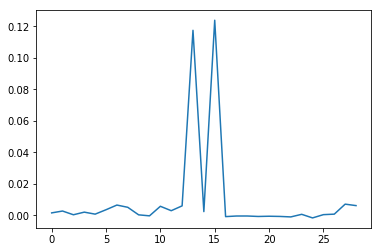

In [77]:
grouped_stats.rmse_delta.plot()

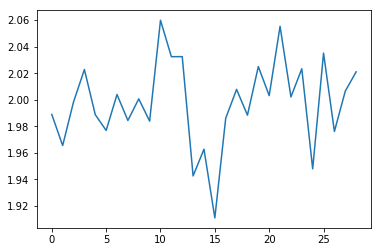

In [78]:
grouped_stats.val_mean_rmse.plot()

In [83]:
grouped_stats = grouped_stats.sort_values(by='rmse_delta', ascending=False)

In [88]:
selected_cols = grouped_stats[grouped_stats.rmse_delta > 0]['col_name'].tolist()

##### First simple way to make validation 

In [56]:
# valid_index = full_train[full_train.fullVisitorId.isin(validationIds)].index

In [57]:
# train_index = full_train[~full_train.fullVisitorId.isin(validationIds)].index

In [58]:
# def split_vals_array(a, train_index, val_index):
#     return a[train_index].copy(), a[val_index].copy()

# def split_vals_df(a, train_index, val_index):
#     return a.iloc[train_index].copy(), a.iloc[val_index].copy()


# raw_train, raw_valid = split_vals_df(full_train, train_index, valid_index)
# X_train, X_valid = split_vals_df(df, train_index, valid_index)
# y_train, y_valid = split_vals_array(y, train_index, valid_index)

# X_train.shape, y_train.shape, X_valid.shape

((681849, 321), (681849,), (221804, 321))

In [59]:
# y_train.mean(), y_valid.mean()

(0.20146147902692166, 0.3059895624328279)

In [60]:
# y_train.max(), y_valid.max()

(23.497337833653027, 23.86437469605166)

#### CV and test

In [105]:
trn_sample_sz = 100000
# trn_sample_sz = len(full_train)

tst_sample_sz = 100000
# tst_sample_sz = len(test_df)

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

In [88]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

In [89]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)
    return res

In [90]:
def my_proc_fn(df, y_fld, skip_flds):
    
    skip = skip_flds.copy()
    if y_fld:
        y = df[y_fld].copy()
        skip.append(y_fld)
    
    X = df.drop(columns=skip).copy()
    
    for c in X.columns:
        if X[c].dtype.name == 'category':
            X[c] = X[c].cat.codes
            
    if y_fld:
        return X, y
    else:
        return X
    

##### Freq encoding

In [91]:
def cat_column_names(df, min_cat):
    return [c for c in df.columns
            if df[c].dtype.name == 'category' and df[c].nunique() > min_cat]

In [92]:
def frq_encoding(df, col):
    freq_encoding  = df.groupby(col).size() / df.shape[0]
    freq_encoding = freq_encoding.reset_index().rename(columns={0:f'{col}_frequency'})
    return df.merge(freq_encoding, on=col, how='left')

In [93]:
def encode_catrgorical(df):
    for c in df.columns:
        if df[c].dtype.name == 'category':
            df = frq_encoding(df, c)
    return df

In [94]:
class FreqEncoder:

    def __init__(self, cols):
        self._cols = cols
        self._freq_dict = {}

    def _frq_encoding(self, df, col):
        freq_encoding = df.groupby(col).size() / df.shape[0]
        freq_encoding = freq_encoding.reset_index().rename(
            columns={0: f'{col}_frequency'})
        return freq_encoding

    def fit(self, df):
        for col in self._cols:
            self._freq_dict[col] = self._frq_encoding(df, col)

    def transform(self, df, drop=False):
        for col, freq_encoding in self._freq_dict.items():
            df = df.merge(freq_encoding, on=col, how='left')
        
        if drop:
            df = df.drop(columns=self._cols)
        return df

In [95]:
class MeanEncoder:

    def __init__(self, cols, target_name):
        self._cols = cols
        self._target_name = target_name
        self._mean_dict = {}

    def _mean_encoding(self, df, col):
        mean_encoding = df\
            .groupby([col])[self._target_name]\
                .agg({f'{col}_Mean':'mean',
                      f'{col}_Std':'std', 
                      f'{col}_Size':'size', 
                      f'{col}_Sum':'sum'})\
            .reset_index()
        return mean_encoding

    def fit(self, df):
        for col in self._cols:
            self._mean_dict[col] = self._mean_encoding(df, col)

    def transform(self, df, drop=False):
        for col, mean_encoding in self._mean_dict.items():
            df = df.merge(mean_encoding, on=col, how='left')
        
        if drop:
            df = df.drop(columns=self._cols)
        return df

#####  Building lgbm workflow

In [140]:
selected_cols = ['channelGrouping', 'visitNumber', 'device_browser',
                 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
                 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
                 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
                 'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
                 'totals_newVisits', 'totals_pageviews', 'trafficSource_adContent',
                 'trafficSource_adwordsClickInfo.adNetworkType',
                 'trafficSource_adwordsClickInfo.gclId',
                 'trafficSource_adwordsClickInfo.isVideoAd',
                 'trafficSource_adwordsClickInfo.page',
                 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
                 'trafficSource_isTrueDirect', 'trafficSource_keyword',
                 'trafficSource_medium', 'trafficSource_referralPath',
                 'trafficSource_source','visitStartTimeYear', 'visitStartTimeMonth', 
                 'visitStartTimeDayofweek', 'visitStartTimeHour']

In [141]:
# add column names you want to use for experiment here
test_cols = ['visitStartTime', 'fullVisitorId'] + selected_cols
train_cols = test_cols +['totals_transactionRevenue']

In [142]:
full_train_smpl = full_train[train_cols].iloc[:trn_sample_sz].copy()
test_smpl = test_df[test_cols].iloc[:tst_sample_sz].copy()

In [143]:
cat_names = cat_column_names(full_train_smpl, min_cat=10)

In [144]:
max_depth = 6

In [145]:
lgb_params = {'learning_rate':0.05,
             'max_depth':max_depth,
             'num_leaves':2**(max_depth - 1)}

In [146]:
lgb_params = {'learning_rate':0.05}

In [147]:
stats_cols = ['experiment'] + [f'val_rmse_{i}' for i in range(N_SPLITS)] +\
             ['val_mean_rmse', 'val_var_rmse', 'best_iter', 'submission_fname']

stats_dict = {name:[] for name in stats_cols}

In [148]:
stats_dict['experiment'].append(f"LGB+mean_encod, params: {lgb_params}, smpl: {trn_sample_sz}")

# TODO!!! should change fname according to experiment
submission_fname = "no_sub"
stats_dict['submission_fname'].append(submission_fname)

In [151]:
def train_valid_test(model_params, encode, cat_names, drop_coded, is_test=False):
    """
    Base function for validation and test
    purposes. Should be updated to be more
    flexible.
    TODO: add param dict for model
    """
    
    full_train_smpl = full_train[train_cols].iloc[:trn_sample_sz].copy()
    test_smpl = test_df[test_cols].iloc[:tst_sample_sz].copy()

    if is_test:
        test_preds = np.zeros(len(test_smpl))

    # create array to collect metrics for every new data sample
    metrics = np.zeros((N_SPLITS, 2))

    for i, (tr_index, val_index) in enumerate(tscv.split(full_train_smpl.visitStartTime)):
        
        full_train_smpl = full_train[train_cols].iloc[:trn_sample_sz].copy()
        
        if encode:
            mean_encoder = MeanEncoder(cols=cat_names, target_name='totals_transactionRevenue')
            mean_encoder.fit(full_train_smpl.iloc[tr_index].copy())
            full_train_smpl = mean_encoder.transform(full_train_smpl, drop=drop_coded)

        logger.debug(f'Process train split on fold {i}{LN_SPLITTER}')
        X_train, y_train, nans = proc_df(df=full_train_smpl.iloc[tr_index],
                                         y_fld='totals_transactionRevenue',
                                         skip_flds=['fullVisitorId',
                                                    'visitStartTime'],
                                         max_n_cat=None)
            
#         if encode:
            
#             logger.debug('Freq encoding')
#             freq_coder = FreqEncoder(cols=cat_names)
#             freq_coder.fit(X_train)
#             X_train = freq_coder.transform(X_train, drop=drop_coded)

        
        logger.debug(f'Process valid split on fold {i}{LN_SPLITTER}')
        X_valid, y_valid, _ = proc_df(df=full_train_smpl.iloc[val_index],
                                      y_fld='totals_transactionRevenue',
                                      skip_flds=['fullVisitorId',
                                                 'visitStartTime'],
                                      max_n_cat=None, na_dict=nans)
        
#         if encode:
            
#             logger.debug('Freq encoding')
#             X_valid = freq_coder.transform(X_valid, drop=drop_coded)

        if is_test:
            logger.debug(f'Process test_set on fold {i}{LN_SPLITTER}')
            X_test, _, _ = proc_df(df=test_smpl, y_fld=None,
                                   skip_flds=['fullVisitorId',
                                              'visitStartTime'],
                                   max_n_cat=None, na_dict=nans)
#             if encode:
                
#                 logger.debug('Freq encoding')
#                 X_test = freq_coder.transform(X_test, drop=drop_coded)

            if i == 0:
                print('Sanity check for column names and types for train and test')
                print(f'{check_columns_and_types_same_in(X_train, X_test)}')

                
        logger.debug(f'Number of features used: {len(X_train.columns)}')
        print('Sanity check for column names and types for train and valid')
        print(f'{check_columns_and_types_same_in(X_train, X_valid)}')

        # log(y) for training the model IMPORTANT!!!
        y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

        # train model
        m = lgb.LGBMRegressor(n_estimators=10000, **model_params)
        if i == 0:
            print(m)

        m.fit(X_train, y_train, eval_metric='rmse',
              early_stopping_rounds=200,
              eval_set=[(X_valid, y_valid),
                        (X_train, y_train)],
              eval_names=['valid', 'train'], verbose=100)

        # Record the best iteration
        best_iteration = m.best_iteration_
        stats_dict['best_iter'] = best_iteration

        metrics[i] = [m.best_score_['train']
                      ['rmse'], m.best_score_['valid']['rmse']]
        stats_dict[f'val_rmse_{i}'].append(metrics[i, 1])

        if is_test:
            logger.debug(f'Predicting test on iteration: {i}{LN_SPLITTER}')
            y_hat = m.predict(X_test, num_iteration=best_iteration)
            y_hat[y_hat < 0] = 0
            y_hat[X_test['totals_pageviews'] < 7] = 0
            test_preds += y_hat / N_SPLITS
            
        y_val_hat = m.predict(X_valid, num_iteration=best_iteration)
        y_val_hat[y_val_hat < 0] = 0
        y_val_hat[X_valid['totals_pageviews'] < 7] = 0
        
        logger.debug(f'validation rmse after post-processing: {rmse(y_val_hat, y_valid)}')

    stats_dict['val_mean_rmse'].append(metrics[:, 1].mean())
    stats_dict['val_var_rmse'].append(metrics[:, 1].var())

    if is_test:
        return test_preds

In [152]:
test_preds = train_valid_test(lgb_params, encode=True, cat_names=cat_names, drop_coded=True, is_test=False)

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':


2018-10-16 23:25:49,565 - new - DEBUG - Process train split on fold 0
====

2018-10-16 23:25:49,715 - new - DEBUG - Process valid split on fold 0
====

2018-10-16 23:25:49,856 - new - DEBUG - Number of features used: 103
Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.977992	valid's rmse: 2.09196
[200]	train's rmse: 0.832175	valid's rmse: 2.11419
Early stopping, best iteration is:
[74]	train's rmse: 1.0309	valid's rmse: 2.08548
2018-10-16 23:25:52,267 - new - DEBUG - validation rmse after 

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':


2018-10-16 23:25:53,386 - new - DEBUG - Process train split on fold 1
====

2018-10-16 23:25:53,581 - new - DEBUG - Process valid split on fold 1
====

2018-10-16 23:25:53,724 - new - DEBUG - Number of features used: 101
Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 1.29899	valid's rmse: 2.02934
[200]	train's rmse: 1.17456	valid's rmse: 2.04848
Early stopping, best iteration is:
[76]	train's rmse: 1.34623	valid's rmse: 2.02567
2018-10-16 23:25:56,617 - new - DEBUG - validation rmse after post-processing: 2.0234796707306826


/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':


2018-10-16 23:25:57,781 - new - DEBUG - Process train split on fold 2
====

2018-10-16 23:25:58,080 - new - DEBUG - Process valid split on fold 2
====

2018-10-16 23:25:58,257 - new - DEBUG - Number of features used: 99
Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 1.44903	valid's rmse: 2.01942
[200]	train's rmse: 1.32562	valid's rmse: 2.01681
[300]	train's rmse: 1.23448	valid's rmse: 2.02991
Early stopping, best iteration is:
[154]	train's rmse: 1.37233	valid's rmse: 2.01338
2018-10-16 23:26:02,263 - new - DEBUG - validation rmse after post-processing: 2.011629002273541


/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':


2018-10-16 23:26:03,408 - new - DEBUG - Process train split on fold 3
====

2018-10-16 23:26:03,752 - new - DEBUG - Process valid split on fold 3
====

2018-10-16 23:26:03,892 - new - DEBUG - Number of features used: 100
Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 1.52126	valid's rmse: 1.68554
[200]	train's rmse: 1.40203	valid's rmse: 1.69085
Early stopping, best iteration is:
[77]	train's rmse: 1.56389	valid's rmse: 1.68365
2018-10-16 23:26:07,814 - new - DEBUG - validation rmse after post-processing: 1.6833508380413356


/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':


2018-10-16 23:26:08,922 - new - DEBUG - Process train split on fold 4
====

2018-10-16 23:26:09,282 - new - DEBUG - Process valid split on fold 4
====

2018-10-16 23:26:09,419 - new - DEBUG - Number of features used: 99
Sanity check for column names and types for train and valid
(True, True)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 1.53627	valid's rmse: 1.70895
[200]	train's rmse: 1.42435	valid's rmse: 1.72283
Early stopping, best iteration is:
[55]	train's rmse: 1.62719	valid's rmse: 1.70543
2018-10-16 23:26:13,546 - new - DEBUG - validation rmse after post-processing: 1.7045888422075655


In [153]:
stats_df = pd.DataFrame(stats_dict)
os.makedirs('../log', exist_ok=True)

In [154]:
stats_df

,experiment,val_rmse_0,val_rmse_1,val_rmse_2,val_rmse_3,val_rmse_4,val_mean_rmse,val_var_rmse,best_iter,submission_fname
0,"LGB+mean_encod, params: {'learning_rate': 0.05...",2.085478,2.025673,2.013383,1.683646,1.705427,1.902722,0.029536,55,no_sub


In [68]:
# it's ONLY for the first time
# stats_df.to_csv('../log/lgb_experiments.csv', index=False, header=True)

In [69]:
# this for the rest of experiments
with open('../log/lgb_experiments.csv', mode='a') as fin:
    stats_df.to_csv(fin, index=False, header=False)

In [70]:
stats_df = pd.read_csv('../log/lgb_experiments.csv')

In [71]:
stats_df

,experiment,val_rmse_0,val_rmse_1,val_rmse_2,val_rmse_3,val_rmse_4,val_mean_rmse,val_var_rmse,best_iter,submission_fname
0,"LGB, params: {}, smpl: 100000",2.025238,1.982883,1.968489,1.700631,1.687969,1.873042,0.021663,35,no_submission
1,"LGB, params: {}, smpl: 903653",1.376993,1.682095,1.560613,1.740512,1.685184,1.609080,0.016922,94,lgb_default.csv
2,"LGB, params: {'learning_rate': 0.05}, smpl: 10...",2.035140,1.988831,1.962878,1.694892,1.682653,1.872879,0.023148,78,no_submission
3,"LGB+Nans params: {'learning_rate': 0.1}, smpl:...",2.027873,1.983381,1.964140,1.700631,1.689582,1.873121,0.021566,39,no_submission
4,"LGB+Nans params: {'learning_rate': 0.1, 'baggi...",2.051981,2.012089,1.980790,1.710983,1.677076,1.886584,0.025342,46,no_submission
5,"LGB+Nans params: {'learning_rate': 0.1, 'baggi...",2.047129,2.019600,1.978597,1.704850,1.676447,1.885325,0.025822,49,no_submission
6,"LGB+Nans params: {'learning_rate': 0.1, 'max_d...",2.026527,1.981429,1.970780,1.703080,1.690389,1.874441,0.021420,47,no_submission
7,"LGB+freq, params: {'learning_rate': 0.1}, smpl...",2.034909,1.986182,1.968960,1.699720,1.690288,1.876012,0.022319,43,no_submission
8,"LGB+freq, params: {'learning_rate': 0.1}, smpl...",2.031612,1.987809,1.964265,1.699951,1.682309,1.873189,0.022595,43,no_submission
9,"LGB+freq, params: {'learning_rate': 0.1}, smpl...",1.379223,1.682419,1.557640,1.735862,1.686953,1.608419,0.016599,98,lgb_default_frq_encoded.csv


In [72]:
stats_df[stats_df.val_mean_rmse < 1.733256].experiment.tolist()

['LGB, params: {}, smpl: 903653',
 "LGB+freq, params: {'learning_rate': 0.1}, smpl: 903653",
 "LGB+freq+drop high_cord=5, params: {'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 32}, smpl: 903653",
 "LGB+freq+drop+p_proc, params: {'learning_rate': 0.1}, smpl: 903653",
 "LGB+selected, params: {'learning_rate': 0.05}, smpl: 903653",
 "LGB+selected, params: {'learning_rate': 0.05}, smpl: 903653"]

In [73]:
# Sanity check for test prediction: should be around 0.20-0.30
test_preds.mean()

0.13630400921869137

####  Test flow

In [74]:
test_grouped = test_df[['fullVisitorId']].copy()
test_grouped['y_hat'] = np.expm1(test_preds)

In [75]:
test_grouped = test_grouped.groupby('fullVisitorId', as_index=False).sum()
test_grouped['y_hat'] = np.log1p(test_grouped['y_hat'])

In [76]:
test_grouped.y_hat.mean()

0.14402690162480591

In [77]:
submit = pd.read_csv('../data/sample_submission.csv')

In [78]:
test_grouped.fullVisitorId.tolist() == submit.fullVisitorId.tolist()

True

In [79]:
submit['fullVisitorId'] = test_grouped['fullVisitorId']

In [80]:
submit['PredictedLogRevenue'] = test_grouped['y_hat']

In [81]:
os.makedirs('../submissions', exist_ok=True)

In [82]:
submit.to_csv(f'../submissions/{submission_fname}', header=True, index=False)